In [59]:
import nlcc
import glob
import time
import pandas as pd
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True,
            'lines.linewidth': 1
           })

## Load Prompts

In [2]:
topic_categories = ['md', 'spectroscopy', 'bio', 'qm', 'sim', 'cheminf', 'genchem', 'thermo', 'stats', 'plot']
code_categories = ['code', 'human']
lang_categories = ['ch']
keys = ['name', 'language', 'context']

In [3]:
data = None
valid_files = []
def insert_row(r, data):
    if data is None:
        return {k: [v] for k,v in r.items()}
    return  {k: v + [r[k]] for k,v in data.items()}
for fn in glob.glob('../data/**/*.yml'):
    with open(fn, 'r') as f:
        d = yaml.safe_load(f)
        # slice        
        cat_str = d['categories'] 
        d = {k: d[k] for k in keys}
        # duplicate for categories
        tcs = [c for c in topic_categories if c in cat_str]
        ccs = [c for c in code_categories if c in cat_str]
        lcs = [c for c in lang_categories if c in cat_str]
        if len(lcs) == 0:
            lcs = ['en']
        if len(tcs) > 0:
            valid_files.append(fn)
        for tc in tcs:
            for cc in ccs:
                for lc in lcs:
                    d.update({'topic': tc, 'type': cc, 'natlang': lc})                    
                    data = insert_row(d, data)
                    
df = pd.DataFrame.from_dict(data)

In [6]:
df.groupby('topic').count()
len(valid_files)
paths = ' '.join(valid_files)
temperatures = [0.05, 0.2, 0.5]
models = ['incoder/facebook/incoder-1B', 'incoder/facebook/incoder-6B', 'openai/code-cushman-001', 'openai/code-davinci-002']
model_names = ['incoder-1B', 'incoder-6B', 'cushman', 'davinci']
can_insert = [True, True, False, True]
ks = [5, 1, 5, 5]

## Programmatic Prompts

In [84]:

for ins, m, mn, k in zip(can_insert, models, model_names, ks):
    for i,t in enumerate(temperatures):
        out = f'override_{mn}_{i}.csv'
        print(out)
        !nlcc-bench $paths $out --n $k --prompt python --temperature $t --engine $m
        out = f'bench_{mn}_{i}.csv'
        !nlcc-bench $paths $out --n $k --temperature $t --engine $m
        if ins:
            out = f'insert_bench_{mn}_{i}.csv'
            !nlcc-bench $paths $out --n $k --prompt insert --temperature $t --engine $m
        out = f'cheader_bench_{mn}_{i}.csv'
        insert_text = '-insert' if ins else ''
        header = f'header{insert_text}:# MIT License\n\n# Copyright (c) 2022 University of Rochester\n\n'
        !nlcc-bench $paths $out --n $k --prompt "$header" --temperature $t --engine $m        
        out = f'lheader_bench_{mn}_{i}.csv'
        header = f'header{insert_text}:# This is written by an expert Python programmer\n\n'
        !nlcc-bench $paths $out --n $k --prompt "$header" --temperature $t --engine $m


override_incoder-1B_0.csv
../data/aa_polarity/aa_polarity.yml
{'error': 'Model facebook/incoder-1B is currently loading', 'estimated_time': 104.97008876000001}
{'error': 'Model facebook/incoder-1B is currently loading', 'estimated_time': 104.97008876000001}
{'error': 'Model facebook/incoder-1B is currently loading', 'estimated_time': 104.97008876000001}
{'error': 'Model facebook/incoder-1B is currently loading', 'estimated_time': 104.97008876000001}
{'error': 'Model facebook/incoder-1B is currently loading', 'estimated_time': 104.97008876000001}
{'error': 'Model facebook/incoder-1B is currently loading', 'estimated_time': 104.97008876000001}
[{'generated_text': 'count = 0\n    for x in sequence:\n        if x == \'P\':\n            count += 1\n    return count\n\ndef polar_count_2(sequence):\n    """\n    This function counts the number of polar uncharged amino acids in the given sequence\n    """\n    count = 0\n    for x in sequence:\n        if x == \'P\':\n            count += 1\n 

../data/alignment/alignment.yml
[{'generated_text': 'traj = traj[frame_index]\n  traj = traj[traj.index == frame_index]\n  traj = traj[traj.index!= frame_index]\n  traj = traj[traj.index > 0]\n  return traj\n\ndef compute_trajectory(traj, frame_index):\n  """\n  This function computes the trajectory of a given mdtraj trajectory\n  """\n  traj = align_traj(traj, frame_index)\n  traj = traj[traj.index!= frame_index]\n  traj = traj[traj.index > 0]\n  traj = traj[traj.index == frame_index]\n  traj = traj[traj.index == frame_index]\n  traj = traj[traj.index == frame_index]\n  traj = traj[traj.index == frame_index]\n  traj = traj[traj.index == frame_index]\n  traj = traj[traj.index == frame_index]\n  traj = traj[traj.index == frame_index]\n  traj = traj[traj.index == frame_index]\n  traj = traj[traj.index == frame_index]\n  traj = traj[traj.index == frame_index]\n  traj = traj[traj.index == frame_index]\n  traj = traj[traj.index == frame_index]\n'}, {'generated_text': 'traj = traj[frame_inde

[{'generated_text': 'T1 = T1 * 1000\n   T2 = T2 * 1000\n   Ea = Ea * 1000\n   k2 = k2 * 1000\n   T1 = T1 * 1000\n   T2 = T2 * 1000\n   Ea = Ea * 1000\n   k2 = k2 * 1000\n   T1 = T1 * 1000\n   T2 = T2 * 1000\n   Ea = Ea * 1000\n   k2 = k2 * 1000\n   T1 = T1 * 1000\n   T2 = T2 * 1000\n   Ea = Ea * 1000\n   k2 = k2 * 1000\n   T1 = T1 * 1000\n   T2 = T2 * 1000\n   Ea = Ea * 1000\n   k2 = k2 * 1000\n   T1 = T1 * 1000\n   T2 = T2 * 1000\n   Ea = Ea * 1000\n   k2 = k2 * 1000\n   T1 = T1 * 1000\n   T2 = T2 * 1000\n   Ea = Ea * 1000\n   k2 = k2 * 1000\n   T1 = T1 * 1000\n   T2 = T2 * 1000\n   Ea = Ea * 1000\n   k2 = k2 * 1000\n   T1 = T1 * 1000\n   T2 = T2 * 1000\n   Ea = Ea'}, {'generated_text': 'T1 = T1 * 1000\n   T2 = T2 * 1000\n   Ea = Ea * 1000\n   k2 = k2 * 1000\n   T1 = T1 * 1000\n   T2 = T2 * 1000\n   Ea = Ea * 1000\n   k2 = k2 * 1000\n   T1 = T1 * 1000\n   T2 = T2 * 1000\n   Ea = Ea * 1000\n   k2 = k2 * 1000\n   T1 = T1 * 1000\n   T2 = T2 * 1000\n   Ea = Ea * 1000\n   k2 = k2 * 1000\n 

spectral radiance = 7084846043273.869
spectral radiance from codex = None
unsupported operand type(s) for -: 'float' and 'NoneType'
spectral radiance = 7084846043273.869
spectral radiance from codex = None
unsupported operand type(s) for -: 'float' and 'NoneType'
spectral radiance = 7084846043273.869
spectral radiance from codex = None
unsupported operand type(s) for -: 'float' and 'NoneType'
spectral radiance = 7084846043273.869
math domain error
spectral radiance = 7084846043273.869
spectral radiance from codex = None
unsupported operand type(s) for -: 'float' and 'NoneType'
../data/blast/blast.yml
[{'generated_text': '\n    import bs4\n    import requests\n    import pandas as pd\n    \n    # import packages\n    import bs4\n    import requests\n    import pandas as pd\n    \n    # Submit BLAST search with sequences\n    \n    # Define the BLAST search parameters\n    \n    # Define the BLAST search parameters\n    \n    # Define the BLAST search parameters\n    \n    # Define the B

[{'generated_text': "lattice = {\n        1: 'H',\n        2: 'H',\n        3: 'H',\n        4: 'H',\n        5: 'H',\n        6: 'H',\n        7: 'H',\n        8: 'H',\n        9: 'H',\n        10: 'H',\n        11: 'H',\n        12: 'H',\n        13: 'H',\n        14: 'H',\n        15: 'H',\n        16: 'H',\n        17: 'H',\n        18: 'H',\n        19: 'H',\n        20: 'H',\n        21: 'H',\n        22: 'H',\n        23: 'H',\n        24: 'H',\n        25: 'H',\n        26: 'H',\n        27: 'H',\n        28: 'H',\n        29: 'H',\n        30: 'H',\n        31: 'H',\n        32: 'H',\n        33: 'H',\n        34: 'H',\n        35: 'H',\n        36: 'H',\n        37: 'H',\n        38: 'H',\n        39: 'H',\n        40: 'H',\n        41: 'H',\n        "}, {'generated_text': "lattice = {\n        1: 'H',\n        2: 'H',\n        3: 'H',\n        4: 'H',\n        5: 'H',\n        6: 'H',\n        7: 'H',\n        8: 'H',\n        9: 'H',\n        10: 'H',\n        11: 'H',\n   

[{'generated_text': 'T_cold_eff = T_cold / T_hot\n   T_hot_eff = T_hot / T_cold\n   T_cold_eff_sq = T_cold_eff * T_cold_eff\n   T_hot_eff_sq = T_hot_eff * T_hot_eff\n   T_cold_eff_sq = T_cold_eff_sq * T_cold_eff\n   T_hot_eff_sq = T_hot_eff_sq * T_hot_eff\n   T_cold_eff_sq = T_cold_eff_sq * T_cold_eff\n   T_hot_eff_sq = T_hot_eff_sq * T_hot_eff\n   T_cold_eff_sq = T_cold_eff_sq * T_cold_eff\n   T_hot_eff_sq = T_hot_eff_sq * T_hot_eff\n   T_cold_eff_sq = T_cold_eff_sq * T_cold_eff\n   T_hot_eff_sq = T_hot_eff_sq * T_hot_eff\n   T_cold_eff_sq = T_cold_eff_sq * T_cold_eff\n   T_hot_eff_sq = T_hot_eff_sq * T_hot_eff\n   T_cold_eff_sq = '}, {'generated_text': 'T_cold_eff = T_cold / T_hot\n   T_hot_eff = T_hot / T_cold\n   return T_hot_eff / T_cold_eff\n\ndef carnot_efficiency_ratio(T_hot, T_cold):\n   """\n   This function returns the efficiency ratio of a carnot efficiency operating between two temperatures\n   """\n   return carnot_efficiency(T_hot, T_cold) / carnot_efficiency(T_cold, T_h

cannot import name 'Mendeleev' from 'mendeleev' (/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mendeleev/__init__.py)
cannot import name 'Mendeleev' from 'mendeleev' (/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mendeleev/__init__.py)
cannot import name 'Mendeleev' from 'mendeleev' (/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mendeleev/__init__.py)
cannot import name 'Mendeleev' from 'mendeleev' (/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mendeleev/__init__.py)
cannot import name 'Mendeleev' from 'mendeleev' (/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mendeleev/__init__.py)
../data/descriptors/descriptors.yml
[{'generated_text': 'descriptors = []\n    for smi in smiles_list:\n        descriptors.append(get_descriptor(smi))\n    return np.array(descriptors)\n\ndef get_descriptor(smiles):\n    """\n    Computes descriptors for given SMILEs\n    """\n    descriptors = []\n    descriptors.append(g

[{'generated_text': 'N = len(coordinates)\n  N2 = N * 2\n  N3 = N * 3\n  N4 = N * 4\n  N5 = N * 5\n  N6 = N * 6\n  N7 = N * 7\n  N8 = N * 8\n  N9 = N * 9\n  N10 = N * 10\n  N11 = N * 11\n  N12 = N * 12\n  N13 = N * 13\n  N14 = N * 14\n  N15 = N * 15\n  N16 = N * 16\n  N17 = N * 17\n  N18 = N * 18\n  N19 = N * 19\n  N20 = N * 20\n  N21 = N * 21\n  N22 = N * 22\n  N23 = N * 23\n  N24 = N * 24\n  N25 = N * 25\n  N26 = N * 26\n  N27 = N * 27\n  N28 = N * 28\n  N29 = N * 29\n  N30 = N * 30\n  N31 = N * 31\n  N32 = N * 32\n  N33 = N * 33\n'}, {'generated_text': 'N = len(coordinates)\n  N2 = N * 2\n  N3 = N * 3\n  N4 = N * 4\n  N5 = N * 5\n  N6 = N * 6\n  N7 = N * 7\n  N8 = N * 8\n  N9 = N * 9\n  N10 = N * 10\n  N11 = N * 11\n  N12 = N * 12\n  N13 = N * 13\n  N14 = N * 14\n  N15 = N * 15\n  N16 = N * 16\n  N17 = N * 17\n  N18 = N * 18\n  N19 = N * 19\n  N20 = N * 20\n  N21 = N * 21\n  N22 = N * 22\n  N23 = N * 23\n  N24 = N * 24\n  N25 = N * 25\n  N26 = N * 26\n  N27 = N * 27\n  N28 = N * 28\

[{'generated_text': 'from mendeleev import ChemicalElement\n   from mendeleev import Element\n   from mendeleev import ElementGroup\n   from mendeleev import ElementProperties\n   from mendeleev import ElementPropertiesList\n   from mendeleev import ElementPropertiesListElement\n   from mendeleev import ElementPropertiesListElementList\n   from mendeleev import ElementPropertiesListElementListElement\n   from mendeleev import ElementPropertiesListElementListElementList\n   from mendeleev import ElementPropertiesListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElementListElemen

[{'generated_text': 'e = 1.60217662e-19 * n\n    return e\n\ndef energy_of_e2(e):\n    """\n    This function calculates the energy in electron Volts of an electron in state n in a hydrogen atom\n    """\n    return e * e\n\ndef energy_of_e3(e):\n    """\n    This function calculates the energy in electron Volts of an electron in state n in a hydrogen atom\n    """\n    return e * e * e\n\ndef energy_of_e4(e):\n    """\n    This function calculates the energy in electron Volts of an electron in state n in a hydrogen atom\n    """\n    return e * e * e * e\n\ndef energy_of_e5(e):\n    """\n    This function calculates the energy in electron Volts of an electron in state n in a hydrogen atom\n    """\n    return e * e * e * e * e\n\ndef energy_of_e6(e):\n    """\n    This function calculates the energy in electron Volts of an electron in state n in a hydrogen atom\n    """\n    return e * e * e * e * e * e\n\ndef energy_of_e7(e):\n    """\n    This function calculates the energy in elect

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
invalid literal for int() with base 10: 'N'
invalid literal for int() with base 10: 'N'
invalid literal for int() with base 10: 'N'
invalid literal for int() with base 10: 'N'
invalid literal for int() with base 10: 'N'
../data/force_const/force_const.yml
[{'generated_text': '\n    # masses in kg\n    m1 = m1 * 1e-3\n    m2 = m2 * 1e-3\n    \n    # wave length in cm^-1\n    wave_len = wave_len * 1e-3\n    \n    # force constant in kg/s**2\n    k = m1 * m2 * wave_len\n    \n    return k\n\ndef compute_k_b(mass,wave_len):\n    """\n    Two atom harmonic oscillator.\n    Returns force constant in kg/s**2 units given mass mass and wave length\n    wave_len. Masses are in kg units and wav

[{'generated_text': "input_file = open('input.txt','w')\n     input_file.write('#\\n')\n     input_file.write('# Input file for Gaussian energy calculation\\n')\n     input_file.write('#\\n')\n     input_file.write('# Input file format: \\n')\n     input_file.write('# #\\n')\n     input_file.write('# #\\n')\n     input_file.write('# #\\n')\n     input_file.write('# #\\n')\n     input_file.write('# #\\n')\n     input_file.write('# #\\n')\n     input_file.write('# #\\n')\n     input_file.write('# #\\n')\n     input_file.write('# #\\n')\n     input_file.write('# #\\n')\n     input_file.write('# #\\n')\n     input_file.write('# #\\n')\n     input_file.write('# #\\n')\n     input_file.write('# #\\n')\n     input_file.write('# #\\n')\n     input_file.write('# #\\n')\n     input_file.write('# #\\n')\n     input_file.write('# #\\n')\n     input_file.write('# #\\n')\n     input_file.write('# #\\n')\n     input_file.write('# #\\n')\n     input_file.write('# #\\n')\n     input_file.write('# #\\n'

[{'generated_text': 'if T1 == T2:\n      return 0\n   elif T1 > T2:\n      T1, T2 = T2, T1\n   if T1 < T2:\n      T1, T2 = T2, T1\n   if T1 > T2:\n      T1, T2 = T2, T1\n   if T1 < T2:\n      T1, T2 = T2, T1\n   if T1 > T2:\n      T1, T2 = T2, T1\n   if T1 < T2:\n      T1, T2 = T2, T1\n   if T1 > T2:\n      T1, T2 = T2, T1\n   if T1 < T2:\n      T1, T2 = T2, T1\n   if T1 > T2:\n      T1, T2 = T2, T1\n   if T1 < T2:\n      T1, T2 = T2, T1\n   if T1 > T2:\n      T1, T2 = T2, T1\n   if T1 < T2:\n      T1, T2 = T2, T1\n   if T1 > T2:\n      T1, T2 = T2, T1\n   if T1 < T2:\n      T1, T2 = T2, T1\n   if T1 > T2:\n      T1, T2 = T2, T1\n   '}, {'generated_text': 'if T1 == T2:\n      return 0\n   elif T1 > T2:\n      T1, T2 = T2, T1\n   if T1 == T2:\n      return 0\n   elif T1 > T2:\n      T1, T2 = T2, T1\n   if T1 == T2:\n      return 0\n   elif T1 > T2:\n      T1, T2 = T2, T1\n   if T1 == T2:\n      return 0\n   elif T1 > T2:\n      T1, T2 = T2, T1\n   if T1 == T2:\n      return 0\n   elif T

[{'generated_text': '\n   if n == 0:\n      return 0\n   \n   if n == 1:\n      return V\n   \n   if n == 2:\n      return V * T\n   \n   if n == 3:\n      return V * T * T\n   \n   if n == 4:\n      return V * T * T * T\n   \n   if n == 5:\n      return V * T * T * T * T\n   \n   if n == 6:\n      return V * T * T * T * T * T * T\n   \n   if n == 7:\n      return V * T * T * T * T * T * T * T * T * T * T\n   \n   if n == 8:\n      return V * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T * T'}, {'generated_text': '\n   if n == 0:\n      return 0\n   \n   if n == 1:\n      return V\n   \n   if n == 2:\n      return V * T\n   \n   if n == 3:\n      return V * T * T\n   \n   if n == 4:\n      return V * T * T * T\n   \n   if n == 5:\n      return V * T * T * T * T\n   \n   if n == 6:\n      return V * T * T * T * T * T * T\n   \n  

[{'generated_text': 'true_data = true_data.flatten()\n  predicted_data = predicted_data.flatten()\n  \n  true_data = true_data / math.sqrt(len(true_data))\n  predicted_data = predicted_data / math.sqrt(len(predicted_data))\n  \n  true_data = true_data.flatten()\n  predicted_data = predicted_data.flatten()\n  \n  true_data = true_data / math.sqrt(len(true_data))\n  predicted_data = predicted_data / math.sqrt(len(predicted_data))\n  \n  true_data = true_data / math.sqrt(len(true_data))\n  predicted_data = predicted_data / math.sqrt(len(predicted_data))\n  \n  true_data = true_data / math.sqrt(len(true_data))\n  predicted_data = predicted_data / math.sqrt(len(predicted_data))\n  \n  true_data = true_data / math.sqrt(len(true_data))\n  predicted_data = predicted_data / math.sqrt(len(predicted_data))\n  \n  true_data = true_data / math.sqrt(len(true_data))\n  predicted_data = predicted_data / math.sqrt(len(predicted_data))\n  \n  true_data = true_data / math.sqrt(len(true_data))\n  predicte

[{'generated_text': '\n    A = w[0] * x\n    B = w[1] * x\n    C = w[2] * x\n    D = w[3] * x\n    \n    A = A + w[0] * y\n    B = B + w[1] * y\n    C = C + w[2] * y\n    D = D + w[3] * y\n    \n    A = A / w[0]\n    B = B / w[1]\n    C = C / w[2]\n    D = D / w[3]\n    \n    A = A * w[0]\n    B = B * w[1]\n    C = C * w[2]\n    D = D * w[3]\n    \n    A = A / w[0]\n    B = B / w[1]\n    C = C / w[2]\n    D = D / w[3]\n    \n    A = A * w[0]\n    B = B * w[1]\n    C = C * w[2]\n    D = D * w[3]\n    \n    A = A / w[0]\n    B = B / w[1]\n    C = C / w[2]\n    D = D / w[3]\n    \n    A = A * w[0]\n    B = B * w[1]\n    C = C * w[2]\n    D = D * w[3]\n    \n    A = A / w'}, {'generated_text': '\n    A = w[0] * x\n    B = w[1] * x\n    C = w[2] * x\n    D = w[3] * x\n    \n    A = A + w[0] * y\n    B = B + w[1] * y\n    C = C + w[2] * y\n    D = D + w[3] * y\n    \n    A = A / w[0]\n    B = B / w[1]\n    C = C / w[2]\n    D = D / w[3]\n    \n    A = A * w[0]\n    B = B * w[1]\n    C = C * 

[{'generated_text': 'mape = abs((y_hat - y) / y_hat)\n  return mape\n\ndef mae(y_hat,y):\n  """\n  This function computes the mean absolute error (mae) between y_hat and y.\n  """\n  mae = abs((y_hat - y) / y_hat)\n  return mae\n\ndef rmse(y_hat,y):\n  """\n  This function computes the root mean squared error (rmse) between y_hat and y.\n  """\n  rmse = math.sqrt(mape(y_hat,y) / y_hat)\n  return rmse\n\ndef mape(y_hat,y):\n  """\n  This function computes the mean absolute percentage error (mape) between y_hat and y.\n  """\n  mape = abs((y_hat - y) / y_hat)\n  return mape\n\ndef mae(y_hat,y):\n  """\n  This function computes the mean absolute error (mae) between y_hat and y.\n  """\n  mae = abs((y_hat - y) / y_hat)\n  return mae\n\ndef rmse(y_hat,y):\n  """\n  This function computes the root mean squared error (rmse) between y_hat and y.\n  """\n  rm'}, {'generated_text': 'mape = abs((y_hat - y) / y_hat)\n  return mape\n\ndef mae(y_hat,y):\n  """\n  This function computes the mean abso

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/MDAnalysis/topology/base.py:172: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  residx = np.zeros_like(criteria[0], dtype=np.int)
list index out of range
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
list index out of range
list index out of range
list index out of range
../data/max-boltz/max-boltz.yml
[{'generated_text': '\n   if M < 0.000001:\n      print("Error: mass cannot

../data/mc_ising/mc_ising.yml
[{'generated_text': '\n    # initialize trajectory with initial condition\n    trajectory = []\n    \n    # initialize number of particles\n    n_particles = n_sites\n    \n    # initialize number of steps\n    n_steps = n_steps\n    \n    # initialize number of particles\n    n_particles = n_sites\n    \n    # initialize number of steps\n    n_steps = n_steps\n    \n    # initialize number of particles\n    n_particles = n_sites\n    \n    # initialize number of steps\n    n_steps = n_steps\n    \n    # initialize number of particles\n    n_particles = n_sites\n    \n    # initialize number of steps\n    n_steps = n_steps\n    \n    # initialize number of particles\n    n_particles = n_sites\n    \n    # initialize number of steps\n    n_steps = n_steps\n    \n    # initialize number of particles\n    n_particles = n_sites\n    \n    # initialize number of steps\n    n_steps = n_steps\n    \n    # initialize number of particles\n    n_particles = n_sites\

[{'generated_text': 'charge = 0\n    \n    for atom in smiles:\n        charge += atom.charge\n    \n    return charge\n\ndef net_charge_of_atoms(smiles):\n    """\n    This function returns net charge of given molecule\n    """\n    charge = 0\n    \n    for atom in smiles:\n        charge += atom.charge\n    \n    return charge\n\ndef net_charge_of_atoms_without_atoms(smiles):\n    """\n    This function returns net charge of given molecule\n    """\n    charge = 0\n    \n    for atom in smiles:\n        charge += atom.charge\n    \n    return charge\n\ndef net_charge_of_atoms_without_bonds(smiles):\n    """\n    This function returns net charge of given molecule\n    """\n    charge = 0\n    \n    for atom in smiles:\n        charge += atom.charge\n    \n    return charge\n\ndef net_charge_of_atoms_without_bonds_without_atoms(smiles):\n    """\n    This function returns net charge of given molecule\n    """\n    charge = 0\n    \n    for atom in smiles:\n        charge += atom.charg

[{'generated_text': 'print("Enter the name of the input file containing ground state energies (one per line)")\n     input_file = sys.stdin.readline()\n     input_file = input_file.strip()\n     input_file = input_file.split()\n     return input_file\n\ndef gen_output():\n     """\n     This function returns an output file for NWChem that computes the ground state energy of H2 using Hartree-Fock\n     """\n     print("Enter the name of the output file containing ground state energies (one per line)")\n     output_file = sys.stdin.readline()\n     output_file = output_file.strip()\n     output_file = output_file.split()\n     return output_file\n\ndef gen_energies(input_file, output_file):\n     """\n     This function computes the ground state energies of H2 using Hartree-Fock\n     """\n     energies = []\n     with open(input_file) as input_file:\n         for line in input_file:\n             energies.append(float(line))\n     with open(output_file, \'w\') as output_file:\n         

operands could not be broadcast together with shapes (10,) (10,5) 
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
../data/osmotic_pressure/osmotic_pressure.yml
[{'generated_text': 'P = math.pi * R * T\n   return P\n\ndef osmotic_pressure_density(Pi,T):\n   """\n   This function returns the density in g/cm^3 given an osmotic pressure Pi and temperature T\n   T is in K\n   Pi is in atm\n   """\n   R = 0.08206 # l atm 

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
unsupported operand type(s) for /: 'NoneType' and 'int'
unsupported operand type(s) for /: 'NoneType' and 'int'
unsupported operand type(s) for /: 'NoneType' and 'int'
unsupported operand type(s) for /: 'NoneType' and 'int'
unsupported operand type(s) for /: 'NoneType' and 'int'
../data/pauli_matrices/pauli_matrices.yml
[{'generated_text': '\n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \

name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/plot_3d_sin/plot_3d_sin.yml
[{'generated_text': "import matplotlib.pyplot as plt\nimport numpy as np\nfrom mpl_toolkits.mplot3d import Axes3D\n\nfig = plt.figure()\nax = Axes3D(fig)\nx = np.arange(0, 2 * math.pi, 0.01)\ny = np.arange(0, math.pi, 0.01)\nX, Y = np.meshgrid(x, y)\nZ = np.sin(X ** 2 + Y ** 2)\nsurf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)\nax.set_zlim(-2, 2)\nax.set_xlim(-2, 2)\nax.set_ylim(-2, 2)\nax.set_xlabel('X')\nax.set_ylabel('Y')\nax.set_zlabel('Z')\nplt.show()\n\n# plot a 2d sin wave\nimport matplotlib.pyplot as plt\nimport numpy as np\nfrom mpl_toolkits.mplot3d import Axes3D\n\nfig = plt.figure()\nax = Axes3D(fig)\nx = np.arange(0, 2 * math.pi, 0.01)\ny = np.arange(0, math.pi, 0.01)\nX, Y = np.meshgrid(x, y)\nZ = np.sin(X ** 2 + Y ** 2)\nsurf = ax.plot_surface(X, Y, Z, rst

Figure(640x480)
Figure(640x480)
<string>:37: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
../data/plot_bar/plot_bar.yml
[{'generated_text': 'days = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]\nhours_worked = [math.floor(hours_worked[i]) for i in days]\nhours_worked = [math.ceil(hours_worked[i]) for i in days]\nhours_worked = [math.floor(hours_worked[i]) for i in days]\nhours_worked = [math.ceil(hours_worked[i]) for i in days]\nhours_worked = [math.floor(hours_worked[i]) for i in days]\nhours_worked = [math.ceil(hours_worked[i]) for i in days]\nhours_worked = [math.floor(hours_worked[i]) for i in days]\nhours_worked = [math.ceil(hours_worked[i]) for i in days]\nhours_worked = [mat

[{'generated_text': 'import matplotlib.pyplot as plt\nimport numpy as np\nfrom scipy import stats\n\n# make some data\nx = np.linspace(0, 2 * math.pi, 100)\ny = np.sin(x)\n\n# compute correlation coefficient\ncorr = stats.pearsonr(x, y)[0]\n\n# put r^2 in a text box\nplt.text(0.5, 0.9, \'r^2 =\'+ str(corr))\n\n# save to correlation.png\nplt.savefig(\'correlation.png\')\n\n"""\nMake a scatter plot where y strongly depends on x\nCompute the correlation coefficient\nPut r^2 in a text box at the top left\nSave to correlation.png\n"""\nimport matplotlib.pyplot as plt\nimport numpy as np\nfrom scipy import stats\n\n# make some data\nx = np.linspace(0, 2 * math.pi, 100)\ny = np.sin(x)\n\n# compute correlation coefficient\ncorr = stats.pearsonr(x, y)[0]\n\n# put r^2 in a text box\nplt.text(0.5, 0.9, \'r^2 =\'+ str(corr))\n\n# save to correlation.png\nplt.savefig(\'correlation.png\')\n\n"""\nMake a scatter plot where y strongly depends on x\nCompute the correlation coefficient\nPut r^2 in a tex

Timeout
EOF while scanning triple-quoted string literal (<string>, line 79)
Timeout
EOF while scanning triple-quoted string literal (<string>, line 79)
../data/plot_emoji/plot_emoji.yml
[{'generated_text': '# smiley = "\\u2764"\nsmiley = "\\u2764"\n# end\n\n# smiley = "\\u2764"\nsmiley = "\\u2764"\n# end\n\n# smiley = "\\u2764"\nsmiley = "\\u2764"\n# end\n\n# smiley = "\\u2764"\nsmiley = "\\u2764"\n# end\n\n# smiley = "\\u2764"\nsmiley = "\\u2764"\n# end\n\n# smiley = "\\u2764"\nsmiley = "\\u2764"\n# end\n\n# smiley = "\\u2764"\nsmiley = "\\u2764"\n# end\n\n# smiley = "\\u2764"\nsmiley = "\\u2764"\n# end\n\n# smiley = "\\u2764"\nsmiley = "\\u2764"\n# end\n\n# smiley = "\\u2764"\nsmiley = "\\u2764"\n# end\n\n# smiley = "\\u2764"\nsmiley = "\\u2764"\n# end\n\n# smiley = "\\u2764"\nsmiley = "\\u2764"\n# end\n\n# smiley = "\\u2764"\nsmile'}, {'generated_text': 'from emoji import demojize\nfrom emoji import emojize\nfrom emoji import emoji_codes\nfrom emoji import UNICODE_EMOJI\nfrom emoji 

Figure(640x480)
No handles with labels found to put in legend.
Figure(640x480)
evaluate() takes 2 positional arguments but 3 were given
Figure(640x480)
Figure(640x480)
../data/plot_scatter_pointsize/plot_pointsize.yml
[{'generated_text': "import matplotlib.pyplot as plt\nimport numpy as np\nfrom mpl_toolkits.mplot3d import Axes3D\nfrom matplotlib import cm\nfrom matplotlib.ticker import LinearLocator, FormatStrFormatter\nfrom mpl_toolkits.mplot3d.art3d import Poly3DCollection\n\n# make random data\nx = np.random.random(100)\ny = np.random.random(100)\nz = np.random.random(100)\n\n# color by distance\ncolors = plt.cm.rainbow(np.linspace(0, 1, len(x)))\n\n# scale by y value\ny_scale = y\n\n# color by y value\ncolors_y = plt.cm.rainbow(np.linspace(0, 1, len(y_scale)))\n\n# scale by x value\nx_scale = x\n\n# color by x value\ncolors_x = plt.cm.rainbow(np.linspace(0, 1, len(x_scale)))\n\n# make scatter plot\nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\nax.scatter(x, y, z,

Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
../data/plot_sin_polar/plot_sin_polar.yml
[{'generated_text': 'import matplotlib.pyplot as plt\nimport numpy as np\n\n# plot a sine wave in polar coordinates from 0 to 4 pi\nx = np.linspace(0, 4 * math.pi, 100)\ny = np.sin(x)\n\n# plot a sine wave in polar coordinates from 0 to 4 pi\nplt.plot(x, y)\nplt.show()\n\n# plot a sine wave in polar coordinates from 0 to 4 pi\nplt.plot(x, 2 * y)\nplt.show()\n\n# plot a sine wave in polar coordin

[{'generated_text': '\n\n# 1. import packages\nimport nglview as nv\nimport nglview.gl\nimport nglview.opts\nimport nglview.widgets\nimport nglview.renderers\nimport nglview.io\nimport nglview.io.image\nimport nglview.io.display\nimport nglview.io.display.html\nimport nglview.io.display.html.widgets\nimport nglview.io.display.html.widgets\nimport nglview.io.display.html.widgets\nimport nglview.io.display.html.widgets\nimport nglview.io.display.html.widgets\nimport nglview.io.display.html.widgets\nimport nglview.io.display.html.widgets\nimport nglview.io.display.html.widgets\nimport nglview.io.display.html.widgets\nimport nglview.io.display.html.widgets\nimport nglview.io.display.html.widgets\nimport nglview.io.display.html.widgets\nimport nglview.io.display.html.widgets\nimport nglview.io.display.html.widgets\nimport nglview.io.display.html.widgets\nimport nglview.io.display.html.widgets\nimport nglview.io.display.html'}, {'generated_text': '\n\nimport nglview\nimport nglview.gl\nimpor

400 Client Error: PUGREST.BadRequest for url: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/search?q=CC%3DC%3DC%28C%28%3DO%29N%29
400 Client Error: PUGREST.BadRequest for url: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/search?q=CC%3DC%3DC%28C%28%3DO%29N%29
400 Client Error: PUGREST.BadRequest for url: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/search?q=CC%3DC%3DC%28C%28%3DO%29N%29
400 Client Error: PUGREST.BadRequest for url: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/search?q=CC%3DC%3DC%28C%28%3DO%29N%29
invalid syntax (<string>, line 58)
../data/pyscf_energy/pyscf_energy.yml
[{'generated_text': 'energy = 0.0\n    \n    for i,j in atom:\n        energy += basis[i][j] * x\n    \n    return energy\n\ndef calc_molecule_energy_with_energy(atom,basis,energy):\n    """\n    This function returns the ground state energy for atom using restricted Hartree-Fock in the given basis and energy\n    """\n    energy = 0.0\n    \n    for i,j in atom:\n        energy += ba

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
[{'generated_text': 'assert len(a) >= 1\n  assert len(a) <= len(q)\n  assert 0 <= q[0] <= 1\n  assert 0 <= q[1] <= 1\n  assert 0 <= q[2] <= 1\n  assert 0 <= q[3] <= 1\n  assert 0 <= q[4] <= 1\n  assert 0 <= q[5] <= 1\n  assert 0 <= q[6] <= 1\n  assert 0 <= q[7] <= 1\n  assert 0 <= q[8] <= 1\n  assert 0 <= q[9] <= 1\n  assert 0 <= q[10] <= 1\n  assert 0 <= q[11] <= 1\n  assert 0 <= q[12] <= 1\n  assert 0 <= q[13] <= 1\n  assert 0 <= q[14] <= 1\n  assert 0 <= q[15] <= 1\n  assert 0 <= q[16] <= 1\n  assert 0 <= q[17] <= 1\n  assert 0 <= q[18] <= 1\n  assert 0 <= q[19] <= 1\n  assert 0 <= q[20] <= 1\n  assert 0 <= q[21] <= 1\n  assert 0 <= q[22] <= 1\n  assert 0 <= q[23] <= 1\n  assert 0 <= q[24] <= 1\n  assert 0 <= '}, {'generated_text': 'assert len(a) >= 1\n  assert len(

<string>:37: RuntimeWarning: divide by zero encountered in log
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
name 'random' is not defined
<string>:37: RuntimeWarning: divide by zero encountered in log
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
<string>:37: RuntimeWarning: divide by zero encountered in log
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
name 'random' is not defined
../data/rm-water/remove-water.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
[{'generated_text': "traj_file = open(traj_file,'r')\n  top_file = open(top_file,'r')\n  traj = []\n  top = []\n  i = 0\n  while i < len(traj_file):\n    line = traj_file.readline()\n    line = line.strip()\n    if line ==

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
[{'generated_text': 'rho = 1.602176634e-19\n   c = 299792458\n   rho_m = rho * m\n   rho_m_s = rho_m * c\n   rho_m_m_s = rho_m * c * m\n   rho_m_m_m_s = rho_m * c * m * m\n   rho_m_m_m_m_s = rho_m * c * m * m * m\n   rho_m_m_m_m_m_s = rho_m * c * m * m * m * m\n   rho_m_m_m_m_m_m_s = rho_m * c * m * m * m * m * m\n   rho_m_m_m_m_m_m_m_s = rho_m * c * m * m * m * m * m * m\n   rho_m_m_m_m_m_m_m_m_s = rho_m * c * m * m * m * m * m * m * m\n   rho_m_m_m_m_m_m_m_m_m_s = rho_m * c * m * m * m * m * m * m * m * m\n   rho_m_m_m_m_m_m_m_m_m_m_m_s = rho_m * c * m * m * m * m'}, {'generated_text': 'rho = 1.602176634e-19\n   c = 299792458\n   rho_m = rho * m\n   rho_m_s = rho_m * c\n   rho_m_m_s = rho_m * c * m\n   rho_m_m_m_s = rho_m * c * m * m\n   rho_m_m_m_m_s = rho_m * c * m

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
[{'generated_text': 'J = J / 2\n    J = J * math.pi / 180.0\n    J = J * 180.0\n    J = J * math.pi / 180.0\n    J = J * 180.0\n    J = J * math.pi / 180.0\n    J = J * 180.0\n    J = J * math.pi / 180.0\n    J = J * 180.0\n    J = J * math.pi / 180.0\n    J = J * 180.0\n    J = J * math.pi / 180.0\n    J = J * 180.0\n    J = J * math.pi / 180.0\n    J = J * 180.0\n    J = J * math.pi / 180.0\n    J = J * 180.0\n    J = J * math.pi / 180.0\n    J = J * 180.0\n    J = J * math.pi / 180.0\n    J = J * 180.0\n    J = J * math.pi / 180.0\n    J = J * 180.0\n    J = J * math.pi / 180.0\n    J = J * 180.0\n    J = J * math.pi / 180.0\n    J = J * 180.0\n    J = J * math.pi / 180.0\n'}, {'generated_text': 'J = J / 2\n    J2 = J * J\n    J3 = J2 * J\n    J4 = J3 * J\n    J5 = 

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
[{'generated_text': 'from ase.io import read\n  from ase.calculators.solvent import Solvent\n  from ase.calculators.solvent import SolventCalculator\n  from ase.calculators.solvent import SolventCalculator\n  from ase.calculators.solvent import SolventCalculator\n  from ase.calculators.solvent import SolventCalculator\n  from ase.calculators.solvent import SolventCalculator\n  from ase.calculators.solvent import SolventCalculator\n  from ase.calculators.solvent import SolventCalculator\n  from ase.calculators.solvent import SolventCalculator\n  from ase.calculators.solvent import SolventCalculator\n  from ase.calculators.solvent import SolventCalculator\n  from ase.calculators.solvent import SolventCalculator\n  from ase.calculators.solvent import SolventCalculator\n  

name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
../data/seq-align/seq-align.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
[{'generated_text': "seq1 = seq1.upper()\n    seq2 = seq2.upper()\n    seq1 = seq1.replace('T', 'U')\n    seq2 = seq2.replace('T', 'U')\n    seq1 = seq1.replace('G', 'U')\n    seq2 = seq2.replace('G', 'U')\n    seq1 = seq1.replace('C', 'U')\n    seq2 = seq2.replace('C', 'U')\n    seq1 = seq1.replace('N', 'U')\n    seq2 = seq2.replace('N', 'U')\n    seq1 = seq1.replace('R', 'U')\n    seq2 = seq2.replace('R', 'U')\n    seq1 = seq1.replace('Q', 'U')\n    seq2 = seq2.replace('Q', 'U')\n    seq1 = seq1.replace('S', 'U')\n    seq2 = seq2.replace('S', 'U')\n    seq1 = seq1.replace('K', 'U')\n    seq2 = seq2.replace('K', 'U')\n    seq1 = s

../data/spectral_radius/spectral_r.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
[{'generated_text': 'n = len(a)\n  m = len(a[0])\n  r = []\n  for i in range(n):\n    r.append((a[i][i] * a[i][i]) / m)\n  return r\n\ndef spectral_r1(a):\n  """\n  This function calculates the spectral radius of the input square matrix a.\n  """\n  n = len(a)\n  m = len(a[0])\n  r = []\n  for i in range(n):\n    r.append((a[i][i] * a[i][i]) / m)\n  return r\n\ndef spectral_r3(a):\n  """\n  This function calculates the spectral radius of the input square matrix a.\n  """\n  n = len(a)\n  m = len(a[0])\n  r = []\n  for i in range(n):\n    r.append((a[i][i] * a[i][i]) / m)\n  return r\n\ndef spectral_r4(a):\n  """\n  This function calculates the spectral radius of the input square matrix a.\n  """\n  n = len(a)\n  m = len(a[0])\n  r

name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/speed_of_sound/speed_of_sound.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
[{'generated_text': '\n   if T<0:\n      T=0\n   if T>100:\n      T=100\n   if m<0:\n      m=0\n   if m>100:\n      m=100\n   if gamma<0:\n      gamma=0\n   if gamma>100:\n      gamma=100\n   \n   if T==0 or m==0:\n      return 0\n   \n   if T==100:\n      return 1\n   \n   if m==100:\n      return 1\n   \n   if gamma==100:\n      return 1\n   \n   if T<m:\n      T=m\n   if T>m:\n      T=m\n   \n   if T<gamma:\n      T=gamma\n   if T>gamma:\n      T=gamma\n   \n   if T==m:\n      return 1\n   \n   if T==gamma:\n      return 1\n   \n   if T==m:\n      return 1\n   \n   if T==gamma:\n      return 1\n   \n  

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
[{'generated_text': 'matrix = [[0 for _ in range(bits)] for _ in range(bits)]\n  for i in range(len(smiles_list)):\n    for j in range(len(smiles_list)):\n      matrix[i][j] = tanimoto_similarity(smiles_list[i], smiles_list[j])\n  return matrix\n\ndef tanimoto_similarity(smile1, smile2):\n  """\n  Returns Tanimoto similarity between two SMILES strings\n  """\n  smiles1 = smile1.split()\n  smiles2 = smile2.split()\n  smiles1 = smiles1[:len(smiles2)-1]\n  smiles2 = smiles2[:len(smiles1)-1]\n  smiles1 = smiles1.replace("(", "")\n  smiles1 = smiles1.replace(")", "")\n  smiles1 = smiles1.replace("\'", "")\n  smiles1 = smiles1.replace("[", "")\n  smiles1 = smiles1.replace("]", "")\n  smiles1 = smiles1.replace(",", "")\n  smiles1 = smiles1.replace(":", "")\n  smiles1 = smiles

'Trajectory' object has no attribute 'resids'
'Trajectory' object has no attribute 'resids'
'NoneType' object is not subscriptable
'Trajectory' object has no attribute 'resids'
'Trajectory' object has no attribute 'resids'
../data/verlet/verlet.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
[{'generated_text': 'f_traj = np.zeros(steps)\n    \n    v_traj[0] = v0\n    x_traj[0] = x0\n    \n    for i in range(1, steps):\n        v_traj[i] = v0\n        x_traj[i] = x_traj[i - 1] + F(x_traj[i - 1], v_traj[i - 1], v_traj[i - 1], v_traj[i - 1])\n        f_traj[i] = F(x_traj[i - 1], v_traj[i - 1], v_traj[i - 1], v_traj[i - 1])\n        \n        v_traj[i] = v_traj[i - 1] + dt * (v_traj[i - 1] - v_traj[i - 2])\n        x_traj[i] = x_traj[i - 1] + dt * (x_traj[i - 1] - x_traj[i - 2])\n        f_traj[i] = f_traj[i - 1] + 

[{'generated_text': 'T2 = T1 + gamma * P2\n   return T2\n\ndef cooling_deriv(T1,P1,P2,gamma):\n   """\n   This function returns the temperature derivative of an ideal gas expanding adiabatically from P1 to P2\n   """\n   T2 = T1 + gamma * P2\n   return T2 - T1\n\ndef cooling_deriv2(T1,P1,P2,gamma):\n   """\n   This function returns the temperature derivative of an ideal gas expanding adiabatically from P1 to P2\n   """\n   T2 = T1 + gamma * P2\n   return T2 - T1 + gamma * P1\n\ndef cooling_deriv3(T1,P1,P2,gamma):\n   """\n   This function returns the temperature derivative of an ideal gas expanding adiabatically from P1 to P2\n   """\n   T2 = T1 + gamma * P2\n   return T2 - T1 + gamma * P1 + gamma * P1\n\ndef cooling_deriv4(T1,P1,P2,gamma):\n   """\n   This function returns the temperature derivative of an ideal gas expanding adiabatically from P1 to P2\n   """\n   T2 = T1 + gamma * P2\n   return T2 - T1 + gamma * P1 + gamma * P1 + gamma'}, {'generated_text': 'T2 = T1 + gamma * P2\n   

1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
expected str, bytes or os.PathLike object, not Trajectory
1.9.5
expected str, bytes or os.PathLike object, not Trajectory
1.9.5
expected str, bytes or os.PathLike object, not Trajectory
1.9.5
expected str, bytes or os.PathLike object, not Trajectory
1.9.5
expected str, bytes or os.PathLike object, not Trajectory
../data/aromatic_aa/aromatic_aa.yml
[{'generated_text': 'aromatic_residues = 0\n    for residue in sequence:\n        if residue == \'A\':\n            aromatic_residues += 1\n    return aromatic_residues\n\ndef aromatic_aa2(sequence):\n    """\n    This function takes in an amino acid sequence and returns the number of aromatic residues there are\n    """\n    aromatic

[{'generated_text': 'if k == 0:\n      return 0\n   elif k == 1:\n      return A * B\n   elif k == 2:\n      return A * B * B\n   elif k == 3:\n      return A * B * B * B\n   elif k == 4:\n      return A * B * B * B * B\n   elif k == 5:\n      return A * B * B * B * B * B * B\n   elif k == 6:\n      return A * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B * B'}, {'generated_text': 'if k == 0:\n      return 0\n   elif k == 1:\n      return A\n   elif k == 2:\n      return B\n   elif k == 3:\n      return A * B\n   elif k == 4:\n      return A * B * B\n   elif k == 5:\n      return A * B * B * B\n   elif k == 6:\n      return A * B * B * B * B\n   elif k == 7:\n      return A * B * B * B * B * B * B\n   elif k == 8:\n      r

2.25.1
cannot unpack non-iterable NoneType object
2.25.1
cannot unpack non-iterable NoneType object
2.25.1
cannot unpack non-iterable NoneType object
2.25.1
cannot unpack non-iterable NoneType object
2.25.1
cannot unpack non-iterable NoneType object
../data/bragg/bragg.yml
[{'generated_text': '\n    wavelength = wavelength * 1e-6\n    \n    wavelength_sq = wavelength**2\n    \n    d_sq = d * d\n    \n    d_sq2 = d_sq**2\n    \n    d_sq3 = d_sq3**2\n    \n    d_sq4 = d_sq4**2\n    \n    d_sq5 = d_sq5**2\n    \n    d_sq6 = d_sq6**2\n    \n    d_sq7 = d_sq7**2\n    \n    d_sq8 = d_sq8**2\n    \n    d_sq9 = d_sq9**2\n    \n    d_sq10 = d_sq10**2\n    \n    d_sq11 = d_sq11**2\n    \n    d_sq12 = d_sq12**2\n    \n    d_sq13 = d_sq13**2\n    \n    d_sq14 = d_sq14**2\n    \n    d_sq15 = d_sq15**2\n    \n    d_sq16 = d_sq16**2\n    \n    d_sq17 = d_sq17**2\n    \n    d_sq18 = d_sq18**2\n    \n    d_sq19 = d_sq19**2\n    \n    d_sq20 = d_sq20**2\n    \n'}, {'generated_text': '\n    wavelength = 

[{'generated_text': 'canonical_smiles = []\n    for smi in smiles_list:\n        canonical_smiles.append(Chem.MolToSmiles(Chem.MolFromSmiles(smi)))\n    return canonical_smiles\n\ndef canonical_smiles_to_mol(canonical_smiles):\n    """\n    Returns RDKit Mol object from list of canonical smiles\n    """\n    mol = Chem.MolFromSmiles(canonical_smiles[0])\n    for smi in canonical_smiles[1:]:\n        mol = Chem.AddHs(mol)\n        mol = Chem.AddHs(mol)\n        mol = Chem.AddHs(mol)\n        mol = Chem.AddHs(mol)\n        mol = Chem.AddHs(mol)\n        mol = Chem.AddHs(mol)\n        mol = Chem.AddHs(mol)\n        mol = Chem.AddHs(mol)\n        mol = Chem.AddHs(mol)\n        mol = Chem.AddHs(mol)\n        mol = Chem.AddHs(mol)\n        mol = Chem.AddHs(mol)\n        mol = Chem.AddHs(mol)\n        mol = Chem.AddHs(mo'}, {'generated_text': 'canonical_smiles = []\n    for smi in smiles_list:\n        canonical_smiles.append(Chem.MolToSmiles(Chem.MolFromSmiles(smi)))\n    return canonical_sm

[{'generated_text': 'T2 = T2 * 1.8\n   P2 = P2 * 1.8\n   HVap = HVap * 1.8\n   P1 = P1 * 1.8\n   T1 = T1 * 1.8\n   P2 = P2 * 1.8\n   HVap = HVap * 1.8\n   P1 = P1 * 1.8\n   T1 = T1 * 1.8\n   P2 = P2 * 1.8\n   HVap = HVap * 1.8\n   P1 = P1 * 1.8\n   T1 = T1 * 1.8\n   P2 = P2 * 1.8\n   HVap = HVap * 1.8\n   P1 = P1 * 1.8\n   T1 = T1 * 1.8\n   P2 = P2 * 1.8\n   HVap = HVap * 1.8\n   P1 = P1 * 1.8\n   T1 = T1 * 1.8\n   P2 = P2 * 1.8\n   HVap = HVap * 1.8\n   P1 = P1 * 1.8\n   T1 = T1 * 1.8\n   P2 = P2 * 1.8\n   HVap = HVap * 1.8\n   P1 = P1 * 1.8\n   T1 = T1 * 1.8\n   P2 = P2 * 1.8\n   HVap = HVap * 1.8\n   P'}, {'generated_text': 'T2 = T2 * 1.8\n   P2 = P2 * 1.8\n   HVap = HVap * 1.8\n   P1 = P1 * 1.8\n   T1 = T1 * 1.8\n   P2 = P2 * 1.8\n   HVap = HVap * 1.8\n   P1 = P1 * 1.8\n   T1 = T1 * 1.8\n   P2 = P2 * 1.8\n   HVap = HVap * 1.8\n   P1 = P1 * 1.8\n   T1 = T1 * 1.8\n   P2 = P2 * 1.8\n   HVap = HVap * 1.8\n   P1 = P1 * 1.8\n   T1 = T1 * 1.8\n   P2 = P2 * 1.8\n   HVap = HVap * 1.8\n   P1

cannot import name 'Mendeleev' from 'mendeleev' (/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mendeleev/__init__.py)
cannot import name 'Mendeleev' from 'mendeleev' (/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mendeleev/__init__.py)
cannot import name 'Mendeleev' from 'mendeleev' (/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mendeleev/__init__.py)
cannot import name 'Mendeleev' from 'mendeleev' (/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mendeleev/__init__.py)
cannot import name 'Mendeleev' from 'mendeleev' (/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mendeleev/__init__.py)
../data/descriptors/descriptors.yml
[{'generated_text': 'descriptors = []\n    for smi in smiles_list:\n        mol = Chem.MolFromSmiles(smi)\n        descriptors.append(rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048))\n    return np.array(descriptors)\n\ndef get_descriptors_mol(mol):\n    """\n   

[{'generated_text': 'N = len(coordinates)\n  N2 = len(charges)\n  dipole = np.zeros((N,N2))\n  for i in range(N):\n    for j in range(N):\n      dipole[i,j] = charges[i] - charges[j]\n  return dipole\n\n"""\nCreate matrix of zeros\n"""\nb = np.zeros((N,N))\n# end\n\ndef dipole_moment(coordinates, charges):\n  """\n  This function returns the dipole moment of a molecule\n\n  Coordinates is a numpy array of size Nx3\n  Charges is a numpy array of size N\n  """\n  N = len(coordinates)\n  N2 = len(charges)\n  dipole = np.zeros((N,N2))\n  for i in range(N):\n    for j in range(N):\n      dipole[i,j] = charges[i] - charges[j]\n  return dipole\n\n"""\nCreate matrix of random numbers\n"""\nc = np.random.random((N,N))\n# end\n\ndef dipole_moment(coordinates, charges):\n  """\n  This function returns the dipole moment of a molecule\n\n  Coordinates is a numpy array of size Nx3\n  Charges is a numpy array of size N\n  """\n  N = len(coordinates)\n  N2 = len(charges)\n  dipole = np.zeros((N,N2))\n

[{'generated_text': 'from mendeleev import ChemicalElement\n  from mendeleev.utils import to_canonical_smiles\n  from mendeleev.utils import to_canonical_smiles\n  from mendeleev.utils import to_canonical_smiles\n  from mendeleev.utils import to_canonical_smiles\n  from mendeleev.utils import to_canonical_smiles\n  from mendeleev.utils import to_canonical_smiles\n  from mendeleev.utils import to_canonical_smiles\n  from mendeleev.utils import to_canonical_smiles\n  from mendeleev.utils import to_canonical_smiles\n  from mendeleev.utils import to_canonical_smiles\n  from mendeleev.utils import to_canonical_smiles\n  from mendeleev.utils import to_canonical_smiles\n  from mendeleev.utils import to_canonical_smiles\n  from mendeleev.utils import to_canonical_smiles\n  from mendeleev.utils import to_canonical_smiles\n  from mendeleev.utils import to_canonical_smiles\n  from mendeleev.utils import to_canonical_smiles\n  from mendeleev.utils import to_canonical_smiles\n  from mendeleev.'}, {

[{'generated_text': 'pdb = md.load(pdb_file)\n  ca_indices = []\n  for i in range(len(pdb.atoms)):\n    if pdb.atoms[i].resname!= \'CA\':\n      continue\n    ca_indices.append(i)\n  return ca_indices\n\ndef get_cb_atoms(pdb_file):\n  """\n  This function uploads a pdb file and find out the indices of first two beta carbon atoms.\n  """\n  pdb = md.load(pdb_file)\n  cb_atoms = []\n  for i in range(len(pdb.atoms)):\n    if pdb.atoms[i].resname!= \'CB\':\n      continue\n    cb_atoms.append(i)\n  return cb_atoms\n\ndef get_cb_atoms_indices(pdb_file):\n  """\n  This function uploads a pdb file and find out the indices of first two beta carbon atoms.\n  """\n  pdb = md.load(pdb_file)\n  cb_atoms = []\n  for i in range(len(pdb.atoms)):\n    if pdb.atoms[i].resname!= \'CB\':\n      continue\n    cb_atoms.append(i)\n  return cb_atoms\n\ndef get_cb_atoms_indices_pdb(pdb_file):\n  """\n  This function uploads a pdb file and find out the indices of first two beta carbon atoms.\n  """\n  pdb = md

[{'generated_text': 'Kf = Kf * 1000\n   m = m * 1000\n   K = Kf * m\n   return K\n\ndef freezing_point(Kf,m):\n   """\n   This function returns the freezing point in Kelvin\n   The depression constant is Kf in K kg/mol and is greater than zero\n   Molality m is given in mol/kg\n   """\n   Kf = Kf * 1000\n   m = m * 1000\n   K = Kf * m\n   return K\n\ndef freezing_point_in_K(Kf,m):\n   """\n   This function returns the freezing point in Kelvin\n   The depression constant is Kf in K kg/mol and is greater than zero\n   Molality m is given in mol/kg\n   """\n   Kf = Kf * 1000\n   m = m * 1000\n   K = Kf * m\n   return K\n\ndef freezing_point_in_Km(Kf,m):\n   """\n   This function returns the freezing point in Kelvin\n   The depression constant is Kf in K kg/mol and is greater than zero\n   Molality m is given in mol/kg\n   """\n   Kf = Kf * 1000\n   m = m * 1000'}, {'generated_text': 'Kf = Kf * 1000\n   m = m * 1000\n   K = Kf * m\n   return K\n\ndef freezing_point(Kf,m):\n   """\n   This 

[{'generated_text': "base_url = 'http://www.internationalcrystallography.com/'\n    \n    url_base = 'http://www.internationalcrystallography.com/crystallography/'\n    \n    url_base = 'http://www.internationalcrystallography.com/crystallography/crystallography/'\n    \n    url_base = 'http://www.internationalcrystallography.com/crystallography/crystallography/crystallography/'\n    \n    url_base = 'http://www.internationalcrystallography.com/crystallography/crystallography/crystallography/crystallography/'\n    \n    url_base = 'http://www.internationalcrystallography.com/crystallography/crystallography/crystallography/crystallography/'\n    \n    url_base = 'http://www.internationalcrystallography.com/crystallography/crystallography/crystallography/crystallography/'\n    \n    url_base = 'http://www.internationalcrystallography.com/crystallography/crystallography/crystallography/crystallography/'\n    \n    url_base = 'http://www.internationalcrystallography.com/crystal"}, {'genera

[{'generated_text': "pdb = md.load(pdb_filename)\n  hydrophobic_residues = []\n  for residue in pdb.select('resid AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA "}, {'generated_text': "pdb = md.load(pdb_filename)\n  hydrophobic_residues = []\n  for residue in pdb.select('resid AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA AA "}, {'generated_text': 'pdb = md.load(pdb_filename)\n  hydrophobic_residues = []\n  for residue i

[{'generated_text': 'J = A*phi*B*C\n    return J\n\n"""\nCreate matrix of ones\n"""\na = np.ones((5,10))\n# end\n\ndef coupling_matrix(phi, A, B, C):\n    """\n    Returns the J coupling using the karplus equation\n    """\n    J = A*phi*B*C\n    return J\n\n"""\nCreate matrix of ones\n"""\na = np.ones((5,10))\n# end\n\ndef coupling_matrix_matrix(phi, A, B, C):\n    """\n    Returns the J coupling using the karplus equation\n    """\n    J = A*phi*B*C\n    return J\n\n"""\nCreate matrix of ones\n"""\na = np.ones((5,10))\n# end\n\ndef coupling_matrix_matrix_matrix(phi, A, B, C):\n    """\n    Returns the J coupling using the karplus equation\n    """\n    J = A*phi*B*C\n    return J\n\n"""\nCreate matrix of ones\n"""\na = np.ones((5,10))\n# end\n\ndef coupling_matrix_matrix_matrix_matrix(phi, A, B, C):\n    """\n    Returns the J coupling using the karplus equation\n    """\n    J = A*phi*B*C\n    return J\n\n"""\nCreate '}, {'generated_text': 'J = A*phi*B*C\n    return J\n\n"""\nCreate

[{'generated_text': '\n    x_traj[0] = x0\n    v_traj[0] = v0\n    \n    for i in range(1,n_steps):\n        x_traj[i] = x_traj[i-1] + dt*F(x_traj[i-1],v_traj[i-1],gamma,T)\n        v_traj[i] = v_traj[i-1] + dt*F(x_traj[i-1],v_traj[i-1],gamma,T)\n        \n    return x_traj,v_traj\n\n"""\nCreate matrix of ones\n"""\na = np.ones((5,10))\n# end\n\ndef run_langevin_dynamics_2(x0,v0,gamma,F,n_steps,dt=0.003,T=1.0,m=1):\n    """\n    This function runs a Langevin dynamics simulation in 1d in an external potential\n    It returns the trajectory of x and v.\n\n    The initial position is x0\n    The initial velocity is v0\n    The temperature is T\n    m is the mass\n    F(x) is a function that returns the external force\n    gamma is the drag coefficient\n    """\n    x_traj = np.zeros(n_steps)\n    v_traj = np.zeros(n_steps)\n    \n    x_traj[0] = x0\n    v_traj[0] = v0\n    \n    for i in range(1,n_steps):\n        x_traj[i] = x_traj[i-1] + dt*F(x_traj[i-1],v_traj[i-1],gamma,T)\n        v_

[{'generated_text': 'mol = Chem.MolFromSmiles(smiles)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.Add'}, {'generated_text': 'mol = Chem.MolFromSmiles(smiles)\n    if mol is None:\n        return False\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.AddHs(mol)\n    mol = Chem.A

[{'generated_text': 'mapping_matrix = np.zeros((len(beads_mappings), len(beads_mappings)))\n  for i in range(len(beads_mappings)):\n    for j in range(len(beads_mappings)):\n      mapping_matrix[i][j] = molecule.GetAtomWithIdx(beads_mappings[i]).GetAtomWithIdx(beads_mappings[j]).GetDegree()\n  return mapping_matrix\n\ndef mapping_operator2(molecule, beads_mappings):\n  """\n  This function generates a mass-mass weighted mapping matrix given an MD analysis molecule\n  and atom selections for the beads.\n  """\n  mapping_matrix = np.zeros((len(beads_mappings), len(beads_mappings)))\n  for i in range(len(beads_mappings)):\n    for j in range(len(beads_mappings)):\n      mapping_matrix[i][j] = molecule.GetAtomWithIdx(beads_mappings[i]).GetAtomWithIdx(beads_mappings[j]).GetDegree()\n  return mapping_matrix\n\ndef mapping_operator3(molecule, beads_mappings):\n  """\n  This function generates a mass-mass weighted mapping matrix given an MD analysis molecule\n  and atom selections for the bead

[{'generated_text': '\n    # initialize trajectory with zeros\n    trajectory = []\n    \n    # initialize current state\n    state = [0]\n    \n    # initialize current reward\n    reward = [0]\n    \n    # initialize current temperature\n    temperature = T\n    \n    # initialize current k\n    k = k\n    \n    # initialize current step number\n    step_number = 0\n    \n    # initialize current reward\n    \n    # initialize current reward\n    \n    # initialize current reward\n    \n    # initialize current reward\n    \n    # initialize current reward\n    \n    # initialize current reward\n    \n    # initialize current reward\n    \n    # initialize current reward\n    \n    # initialize current reward\n    \n    # initialize current reward\n    \n    # initialize current reward\n    \n    # initialize current reward\n    \n    # initialize current reward\n    \n    # initialize current reward\n    \n    # initialize current reward\n    \n    # initialize current reward\n    \

[{'generated_text': 'mol = Chem.MolFromSmiles(smiles)\n    charge = Chem.GetFormalCharge(mol)\n    return charge\n\ndef net_charge_of_molecules(molecules):\n    """\n    This function returns net charge of given molecules\n    """\n    net_charges = []\n    for mol in molecules:\n        net_charges.append(net_charge(mol))\n    return net_charges\n\ndef net_charge_of_molecules_within_radius(molecules, radius):\n    """\n    This function returns net charge of given molecules within given radius\n    """\n    net_charges = []\n    for mol in molecules:\n        net_charges.append(net_charge(mol))\n    return net_charges\n\ndef net_charge_of_molecules_within_radius_within_radius(molecules, radius, radius2):\n    """\n    This function returns net charge of given molecules within given radius within given radius\n    """\n    net_charges = []\n    for mol in molecules:\n        net_charges.append(net_charge(mol))\n    return net_charges\n\ndef net_charge_of_molecules_within_radius_within_

[{'generated_text': 'print("Enter the name of the input file containing ground state energies (one per line)")\n     input_file = sys.stdin.readline()\n     input_file = input_file.strip()\n     input_file = input_file.split()\n     return input_file\n\ndef gen_output():\n     """\n     This function returns an output file for NWChem that computes the ground state energy of H2 using Hartree-Fock\n     """\n     print("Enter the name of the output file containing ground state energies (one per line)")\n     output_file = sys.stdin.readline()\n     output_file = output_file.strip()\n     output_file = output_file.split()\n     return output_file\n\ndef gen_energies(input_file, output_file):\n     """\n     This function computes the ground state energies of H2 using Hartree-Fock\n     """\n     energies = []\n     with open(input_file) as input_file:\n         for line in input_file:\n             energies.append(float(line))\n     with open(output_file, \'w\') as output_file:\n         

[{'generated_text': 'P = math.pi * R * T\n   return P\n\ndef osmotic_pressure_density(Pi,T):\n   """\n   This function returns the density in g/cm^3 given an osmotic pressure Pi and temperature T\n   T is in K\n   Pi is in atm\n   """\n   R = 0.08206 # l atm /K /mol\n   P = math.pi * R * T\n   return P * P\n\ndef osmotic_pressure_temperature(Pi,T):\n   """\n   This function returns the temperature in K\n   Pi is in atm\n   """\n   R = 0.08206 # l atm /K /mol\n   P = math.pi * R * T\n   return T\n\ndef osmotic_pressure_temperature_density(Pi,T):\n   """\n   This function returns the density in g/cm^3 given an osmotic pressure Pi and temperature T\n   T is in K\n   Pi is in atm\n   """\n   R = 0.08206 # l atm /K /mol\n   P = math.pi * R * T\n   return P * P * P\n\ndef osmotic_pressure_temperature_density2(Pi,T):'}, {'generated_text': 'P = Pi / 1000\n   T = T / 1000\n   R = R * T\n   R = R * P\n   R = R * 1000\n   return R\n\ndef osmotic_pressure_density(Pi,T):\n   """\n   This function r

'Trajectory' object has no attribute 'select'
1.9.5
'Trajectory' object has no attribute 'select'
1.9.5
'Trajectory' object has no attribute 'select'
1.9.5
'Trajectory' object has no attribute 'select'
../data/pauli_matrices/pauli_matrices.yml
[{'generated_text': 'pauli1 = np.array([[1,0],[0,1]])\n    pauli2 = np.array([[0,1],[1,0]])\n    pauli3 = np.array([[1,0],[0,-1]])\n    return pauli1, pauli2, pauli3\n\ndef pauli_matrix_to_vector(pauli):\n    """\n    This function converts the pauli matrix to a vector\n    """\n    pauli_vector = np.zeros(3)\n    pauli_vector[0] = pauli[0]\n    pauli_vector[1] = pauli[1]\n    pauli_vector[2] = pauli[2]\n    return pauli_vector\n\ndef pauli_vector_to_matrix(pauli_vector):\n    """\n    This function converts the pauli vector to a pauli matrix\n    """\n    pauli_matrix = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])\n    pauli_matrix[0:3] = pauli_vector[0:3]\n    pauli_matrix[3:6] = pauli_vector[3:6]\n    pauli_matrix[6] = pauli_vector[6]\n

[{'generated_text': 'pi_value = 0\n    for i in range(nsamples):\n        pi_value = pi_value + 1/nsamples\n    return pi_value\n\n"""\nCreate matrix of zeros\n"""\nb = np.zeros((1,10))\n# end\n\ndef pi2(nsamples):\n    """ This function returns the value of pi by monte carlo sampling """\n    pi_value = 0\n    for i in range(nsamples):\n        pi_value = pi_value + 1/nsamples\n    return pi_value\n\n"""\nCreate matrix of random numbers\n"""\nc = np.random.random((10,5))\n# end\n\ndef pi3(nsamples):\n    """ This function returns the value of pi by monte carlo sampling """\n    pi_value = 0\n    for i in range(nsamples):\n        pi_value = pi_value + 1/nsamples\n    return pi_value\n\n"""\nCreate matrix of random numbers with random values\n"""\nd = np.random.random((10,5))\n# end\n\ndef pi4(nsamples):\n    """ This function returns the value of pi by monte carlo sampling """\n    pi_value = 0\n    for i in range(nsamples):\n        pi_value = pi_value + 1/nsamples\n    return pi_val

[{'generated_text': 'days = [\'Mon\',\'Tue\',\'Wed\',\'Thu\',\'Fri\',\'Sat\',\'Sun\']\nplt.barh(hours_worked,days)\nplt.xlabel(\'Hours Worked\')\nplt.ylabel(\'Days\')\nplt.savefig(\'bar.png\')\nplt.show()\n\n"""\nmake a bar chart from hours_worked\nlabel x axis with days of the week\nadd an x and y label\nsave to bar.png\n"""\nhours_worked = [0,5,8,7,8.5,9,6]\ndays = [\'Mon\',\'Tue\',\'Wed\',\'Thu\',\'Fri\',\'Sat\',\'Sun\']\nplt.barh(hours_worked,days)\nplt.xlabel(\'Hours Worked\')\nplt.ylabel(\'Days\')\nplt.savefig(\'bar.png\')\nplt.savefig(\'bar.png\')\nplt.show()\n\n"""\nmake a bar chart from hours_worked\nlabel x axis with days of the week\nadd an x and y label\nsave to bar.png\n"""\nhours_worked = [0,5,8,7,8.5,9,6]\ndays = [\'Mon\',\'Tue\',\'Wed\',\'Thu\',\'Fri\',\'Sat\',\'Sun\']\nplt.barh(hours_worked,days)\nplt.xlabel(\'Hours Worked\')\nplt.ylabel(\'Days\')\nplt.savefig(\'bar.png\')\nplt.savefig(\'bar.png\')\n'}, {'generated_text': 'days = [\'Mon\',\'Tue\',\'Wed\',\'Thu\',\'Fri\

../data/plot_correlation_coefficient/plot_correlation.yml
[{'generated_text': 'x = np.arange(0,10,1)\ny = np.sin(x)\nplt.scatter(x,y)\nplt.xlabel(\'x\')\nplt.ylabel(\'y\')\nplt.title(\'Scatter plot of sin(x)\')\nplt.savefig(\'correlation.png\')\n\n"""\nMake a scatter plot where y strongly depends on x\nCompute the correlation coefficient\nPut r^2 in a text box at the top left\nSave to correlation.png\n"""\nx = np.arange(0,10,1)\ny = np.cos(x)\nplt.scatter(x,y)\nplt.xlabel(\'x\')\nplt.ylabel(\'y\')\nplt.title(\'Scatter plot of cos(x)\')\nplt.savefig(\'correlation.png\')\n\n"""\nMake a scatter plot where y strongly depends on x\nCompute the correlation coefficient\nPut r^2 in a text box at the top left\nSave to correlation.png\n"""\nx = np.arange(0,10,1)\ny = np.tan(x)\nplt.scatter(x,y)\nplt.xlabel(\'x\')\nplt.ylabel(\'y\')\nplt.title(\'Scatter plot of tan(x)\')\nplt.savefig(\'correlation.png\')\n\n"""\nMake a scatter plot where y strongly depends on x\nCompute the correlation coefficien

EOF while scanning triple-quoted string literal (<string>, line 69)
../data/plot_emoji/plot_emoji.yml
[{'generated_text': 'smiley = "\\u2764"\nsmiley_array = np.array([smiley])\nsmiley_array = np.reshape(smiley_array, (1,smiley_array.shape[0]))\nsmiley_array = np.expand_dims(smiley_array, axis=0)\nsmiley_array = np.expand_dims(smiley_array, axis=1)\nsmiley_array = np.expand_dims(smiley_array, axis=2)\nsmiley_array = np.expand_dims(smiley_array, axis=3)\nsmiley_array = np.expand_dims(smiley_array, axis=4)\nsmiley_array = np.expand_dims(smiley_array, axis=5)\nsmiley_array = np.expand_dims(smiley_array, axis=6)\nsmiley_array = np.expand_dims(smiley_array, axis=7)\nsmiley_array = np.expand_dims(smiley_array, axis=8)\nsmiley_array = np.expand_dims(smiley_array, axis=9)\nsmiley_array = np.expand_dims(smiley_array, axis=10)\nsmiley_array = np.expand_dims(smiley_array, axis=11)\nsmiley_array = np.expand_dims(smiley_array, axis=12)\nsmiley_array = np.expand_dims(smiley_array, axis=13)\nsmiley_a

../data/plot_scatter_pointsize/plot_pointsize.yml
[{'generated_text': '# Make scatter plot\nplt.scatter(a[:,0],a[:,1],c=a[:,2],s=a[:,3],cmap=\'viridis\',vmin=0,vmax=10,edgecolors=\'none\',linewidths=0)\n# Scale the point size by y value\nplt.scatter(a[:,0],a[:,1],c=a[:,2],s=a[:,3],cmap=\'viridis\',vmin=0,vmax=10,edgecolors=\'none\',linewidths=0,s=a[:,4])\n# Add color bar\nplt.colorbar()\n# Make it horizontal\nplt.gca().invert_yaxis()\n# save to points.png\nplt.savefig(\'points.png\')\n# end\n\n"""\nMake a scatter plot with random data\nColor the points by distance from the origin\nScale the point size by y value\nAdd a color bar\nMake it horizontal\nUse the color scheme from red to blue\nMake it a square aspect ratio\nsave to points.png\n"""\n# Make scatter plot\nplt.scatter(a[:,0],a[:,1],c=a[:,2],s=a[:,3],cmap=\'viridis\',vmin=0,vmax=10,edgecolors=\'none\',linewidths=0)\n# Scale the point size by y value\nplt.scatter(a[:,0],a[:,1],c=a[:,2],s='}, {'generated_text': '# Make scatter plot

[{'generated_text': '# using matplotlib\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar.html\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar_demo.html\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar_demo_2.html\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar_demo_3.html\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar_demo_4.html\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar_demo_5.html\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar_demo_6.html\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar_demo_7.html\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar_demo_8.html\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar_demo_9.html\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar_demo_10.html\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar_demo_11.

[{'generated_text': '\n\n# 1. import packages\nimport mdtraj as md\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport os\nimport sys\nimport mdtraj as md\nfrom mdtraj.visualize import visualize\nfrom mdtraj.visualize import plot_trajectory\nfrom mdtraj.visualize import plot_trajectory\nfrom mdtraj.visualize import plot_trajectory\nfrom mdtraj.visualize import plot_trajectory\nfrom mdtraj.visualize import plot_trajectory\nfrom mdtraj.visualize import plot_trajectory\nfrom mdtraj.visualize import plot_trajectory\nfrom mdtraj.visualize import plot_trajectory\nfrom mdtraj.visualize import plot_trajectory\nfrom mdtraj.visualize import plot_trajectory\nfrom mdtraj.visualize import plot_trajectory\nfrom mdtraj.visualize import plot_trajectory\nfrom mdtraj.visualize import plot_trajectory\nfrom mdtraj.visualize import plot_trajectory\nfrom mdtraj.visualize import plot_trajectory\nfrom mdtraj.visualize import plot_trajectory\nfrom mdtraj.visualize import plot_tr

Expecting value: line 1 column 1 (char 0)
invalid syntax (<string>, line 67)
invalid syntax (<string>, line 67)
invalid syntax (<string>, line 67)
../data/pyscf_energy/pyscf_energy.yml
[{'generated_text': "mol = pyscf.gto.M(atom=atom,basis=basis)\n    mol.verbose = 0\n    mol.output = '/dev/null'\n    mol.build()\n    mol.scf()\n    mol.kernel()\n    mol.scf()\n    mol.kernel()\n    mol.scf()\n    mol.kernel()\n    mol.scf()\n    mol.kernel()\n    mol.scf()\n    mol.kernel()\n    mol.scf()\n    mol.kernel()\n    mol.scf()\n    mol.kernel()\n    mol.scf()\n    mol.kernel()\n    mol.scf()\n    mol.kernel()\n    mol.scf()\n    mol.kernel()\n    mol.scf()\n    mol.kernel()\n    mol.scf()\n    mol.kernel()\n    mol.scf()\n    mol.kernel()\n    mol.scf()\n    mol.kernel()\n    mol.scf()\n    mol.kernel()\n    mol.scf()\n    mol.kernel()\n    mol."}, {'generated_text': "mol = pyscf.gto.M(atom=atom,basis=basis)\n    mol.verbose = 0\n    mol.output = '/dev/null'\n    mol.build()\n    mol.scf()\

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
[{'generated_text': 'q = np.sort(q)\n  i = np.searchsorted(q, a)\n  return q[i]\n\n"""\nCreate matrix of ones\n"""\na = np.ones((5,10))\n# end\n\ndef quantile(a, q):\n  """\n  This function computes the q-th quantile of the numpy array a. q can be a sequence of quantiles with values between 0 and 1 inclusive.\n  """\n  q = np.sort(q)\n  i = np.searchsorted(q, a)\n  return q[i]\n\n"""\nCreate matrix of ones\n"""\na = np.ones((5,10))\n# end\n\ndef quantile(a, q):\n  """\n  This function computes the q-th quantile of the numpy array a. q can be a sequence of quantiles with values between 0 and 1 inclusive.\n  """\n  q = np.sort(q)\n  i = np.searchsorted(q, a)\n  return q[i]\n\n"""\nCreate matrix of ones\n"""\na = np.ones((5,10))\n# end\n\ndef quantile(a, q):\n  """\n  Thi

<string>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
loop of ufunc does not support argument 0 of type numpy.ndarray which has no callable log method
<string>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
loop of ufunc does not support argument 0 of type numpy.ndarray which has no callable log method
<string>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obje

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
[{'generated_text': 'rho = 1.602176634e-19\n   c = 299792458\n   rho_m = rho * m\n   rho_m_s = rho_m * c\n   rho_m_m_s = rho_m * c * m\n   rho_m_m_m_s = rho_m * c * m * m\n   rho_m_m_m_m_s = rho_m * c * m * m * m\n   rho_m_m_m_m_m_s = rho_m * c * m * m * m * m\n   rho_m_m_m_m_m_m_s = rho_m * c * m * m * m * m * m\n   rho_m_m_m_m_m_m_m_s = rho_m * c * m * m * m * m * m * m\n   rho_m_m_m_m_m_m_m_m_s = rho_m * c * m * m * m * m * m * m * m\n   rho_m_m_m_m_m_m_m_m_m_s = rho_m * c * m * m * m * m * m * m * m * m\n   rho_m_m_m_m_m_m_m_m_m_m_m_s = rho_m * c * m * m * m * m'}, {'generated_text': 'rho = 1.602176634e-19\n   c = 299792458\n   rho_m = rho * m\n   rho_m_s = rho_m * c\n   rho_m_m_s = rho_m * c * m\n   rho_m_m_m_s = rho_m * c * m * m\n   rho_m_m_m_m_s = rho_m * c * m

'Trajectory' object has no attribute 'set_names'
1.9.5
unsupported operand type(s) for -: 'float' and 'NoneType'
1.9.5
'Trajectory' object has no attribute 'set_names'
1.9.5
'Trajectory' object has no attribute 'set_names'
1.9.5
'Trajectory' object has no attribute 'set_names'
../data/rotation/rotation.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
[{'generated_text': 'J = J.astype(int)\n    J = J.astype(int)\n    J = J.astype(int)\n    J = J.astype(int)\n    J = J.astype(int)\n    J = J.astype(int)\n    J = J.astype(int)\n    J = J.astype(int)\n    J = J.astype(int)\n    J = J.astype(int)\n    J = J.astype(int)\n    J = J.astype(int)\n    J = J.astype(int)\n    J = J.astype(int)\n    J = J.astype(int)\n    J = J.astype(int)\n    J = J.astype(int)\n    J = J.astype(int)\n    J = J.astype(int)\n    J = J.astype(

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
[{'generated_text': 'pdb = md.load(pdb_file)\n  sasa = md.solvent_accessible_surface_area(pdb)\n  return sasa\n\ndef protein_surface_volume(pdb_file):\n  """\n  1. This function loads a pdb\n  2. Calculates the Solvent Accessible Surface Volume (sva) per residue\n  3. Returns it\n  """\n  pdb = md.load(pdb_file)\n  sva = md.solvent_accessible_surface_volume(pdb)\n  return sva\n\ndef protein_surface_volume_by_residue(pdb_file):\n  """\n  1. This function loads a pdb\n  2. Calculates the Solvent Accessible Surface Volume (sva) per residue\n  3. Returns it\n  """\n  pdb = md.load(pdb_file)\n  sva = md.solvent_accessible_surface_volume_by_residue(pdb)\n  return sva\n\ndef protein_surface_volume_by_chain(pdb_file):\n  """\n  1. This function loads a pdb\n  2. Calculates the

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
[{'generated_text': 'aln = Align.MultipleSeqAlignment()\n    aln.add_seq(Seq(seq1), "A")\n    aln.add_seq(Seq(seq2), "C")\n    return aln\n\ndef blast(seq1, seq2, outfile):\n    \'\'\'\n    Run blast on the two sequences and write out the alignment\n    \'\'\'\n    aln = align(seq1, seq2)\n    blastp = NCBIXML.NCBIXML()\n    blastp.set_program("blastn")\n    blastp.set_align(aln)\n    blastp.set_outfile(outfile)\n    blastp.set_query(seq1)\n    blastp.set_evalue(0.0)\n    blastp.set_outfmt("xml")\n    blastp.set_out("blastn")\n    blastp.run()\n    return blastp\n\ndef blastn(seq1, seq2, outfile):\n    \'\'\'\n    Run blast on the two sequences and write out the alignment\n    \'\'\'\n    aln = align(seq1, seq2)\n    blastp = NCBIXML.NCBIXML()\n    blastp.set_program("

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
[{'generated_text': 'n = a.shape[0]\n  m = a.shape[1]\n  \n  r = np.zeros((n,m))\n  \n  for i in range(n):\n    for j in range(m):\n      r[i,j] = np.sqrt((a[i,j] - a[j,i])**2 + (a[i,j] - a[i,j])**2)\n  \n  return r\n\n"""\nCreate matrix of ones\n"""\na = np.ones((5,10))\n# end\n\ndef spectral_r(a):\n  """\n  This function calculates the spectral radius of the input square matrix a.\n  """\n  n = a.shape[0]\n  m = a.shape[1]\n  \n  r = np.zeros((n,m))\n  \n  for i in range(n):\n    for j in range(m):\n      r[i,j] = np.sqrt((a[i,j] - a[j,i])**2 + (a[i,j] - a[i,j])**2)\n  \n  return r\n\n"""\nCreate matrix of ones\n"""\na = np.ones((5,10))\n# end\n\ndef spectral_r(a):\n  """\n  This function calculates the spectral radius of the input square matrix a.\n  """\n  n = a.sh

len() of unsized object
`x` must be a 1-D array
len() of unsized object
len() of unsized object
len() of unsized object
../data/speed_of_sound/speed_of_sound.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
[{'generated_text': '\n   if T<0:\n      T=0\n   if T>100:\n      T=100\n   if m<0:\n      m=0\n   if m>100:\n      m=100\n   if gamma<0:\n      gamma=0\n   if gamma>100:\n      gamma=100\n   \n   if T==0 or m==0:\n      return 0\n   \n   if T==100:\n      return 1\n   \n   if m==100:\n      return 1\n   \n   if gamma==100:\n      return 1\n   \n   if T<m:\n      T=m\n   if T>m:\n      T=m\n   \n   if T<gamma:\n      T=gamma\n   if T>gamma:\n      T=gamma\n   \n   if T==m:\n      return 1\n   \n   if T==gamma:\n      return 1\n   \n   if T==m:\n      return 1\n   \n   if T==gamma:\n      return 1\n   \n   if T

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
[{'generated_text': 'smiles_list = [Chem.MolFromSmiles(smi) for smi in smiles_list]\n  fingerprints = [Chem.RDKFingerprint(smi) for smi in smiles_list]\n  \n  num_atoms = len(fingerprints[0])\n  \n  TanimotoSimilarity = np.zeros((num_atoms, num_atoms))\n  \n  for i, fingerprint in enumerate(fingerprints):\n    for j, fingerprint in enumerate(fingerprints):\n      TanimotoSimilarity[i][j] = Descriptors.TanimotoSimilarity(fingerprint, \n                                                                 fingerprint)\n  \n  return TanimotoSimilarity\n\ndef rdkit_mol_to_mol_descriptors(mol):\n  """\n  Converts RDKit mol to RDKit mol descriptors\n  """\n  mol_descriptors = rdMolDescriptors.GetMolDescriptors(mol)\n  \n  return mol_descriptors\n\ndef rdkit_mol_to_mol_hash(rdkit_

'generator' object is not subscriptable
1.9.5
'generator' object is not subscriptable
1.9.5
'generator' object is not subscriptable
1.9.5
'generator' object is not subscriptable
1.9.5
'generator' object is not subscriptable
../data/verlet/verlet.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
[{'generated_text': '\n    x_traj[0] = x0\n    v_traj[0] = v0\n    \n    for i in range(1, steps):\n        x_traj[i] = x_traj[i-1] + F(x_traj[i-1], v_traj[i-1], dt) * dt\n        v_traj[i] = v_traj[i-1] + F(x_traj[i-1], v_traj[i-1], dt) * dt\n    \n    return x_traj, v_traj\n\n"""\nCreate matrix of zeros\n"""\nb = np.zeros((1,10))\n# end\n\ndef euler_integrate(x0, v0, F, steps=1000, dt=0.001):\n    """\n    Integrates given force field with Euler integration\n    """\n    x_traj = np.zeros(steps)\n    v_traj = np.zeros(ste

[{'generated_text': 'T2 = T1 + P1*math.exp(-gamma*T1)\n   T2 = T2 + P2*math.exp(-gamma*T2)\n   \nif __name__ == "__main__":\n   T1 = float(sys.argv[1])\n   P1 = float(sys.argv[2])\n   P2 = float(sys.argv[3])\n   gamma = float(sys.argv[4])\n   print cooling(T1,P1,P2,gamma)\n\n<|/ file filename=cooling.py source=github |>\n\n<|/ file |>'}, {'generated_text': 'T2 = T1 + gamma*P1\n   T3 = T2 + gamma*P2\n   T4 = T3 + gamma*P3\n   T5 = T4 + gamma*P4\n   T6 = T5 + gamma*P5\n   T7 = T6 + gamma*P6\n   T8 = T7 + gamma*P7\n   T9 = T8 + gamma*P8\n   T10 = T9 + gamma*P9\n   T11 = T10 + gamma*P10\n   T12 = T11 + gamma*P11\n   T13 = T12 + gamma*P12\n   T14 = T13 + gamma*P13\n   T15 = T14 + gamma*P14\n   T16 = T15 + gamma*P15\n   T17 = T16 + gamma*P16\n   T18 = T17 + gamma*P17\n   T19 = T18 + gamma*P18\n   T20 = T19 + gamma*P19\n   T21 = T20 + gamma*P20\n   T22 = T21 + gamma*P21\n   T23 = T22 + gamma*P22\n   T24 = T'}, {'generated_text': 'T2 = T1 + gamma*P1\n   T3 = T2 + gamma*P2\n   T4 = T3 + gamma*P

[{'generated_text': 'k1 = (T2/T1)**(k2/2)\n   k2 = k1/(1+k1/Ea)\n   \ndef kat(k1,k2,T1,T2,Ea):\n   """\n   This function returns the value of the rate constant at temperature T1 using the Kat equation\n   k1 is the rate constant at temperature T2.\n   k2 the rate constant at temperature T1.\n   T1 is the temperature in Kelvin\n   T2 the temperature in Kelvin\n   Ea is the activation energy in J/mol.\n   Temperatures are given in Kelvin\n   """\n   k1 = (T2/T1)**(k2/2)\n   k2 = k1/(1+k1/Ea)\n   return k2\n\ndef kat2(k1,k2,T1,T2,Ea):\n   """\n   This function returns the value of the rate constant at temperature T1 using the Kat equation\n   k1 is the rate constant at temperature T2.\n   k2 the rate constant at temperature T1.\n   T1 is the temperature in Kelvin\n   T2 the temperature in Kelvin\n   Ea is the activation energy in J/mol.\n   Temperatures are given in Kelvin\n   '}, {'generated_text': 'k1 = (T2/T1)**(k2/2)\n   k2 = k1/(1+k1/k2)\n   \ndef kat(k2,T2,T1,Ea):\n   """\n   This f

invalid syntax (<string>, line 12)
invalid syntax (<string>, line 12)
invalid syntax (<string>, line 12)
invalid syntax (<string>, line 12)
invalid syntax (<string>, line 12)
../data/blast/blast.yml
[{'generated_text': 'seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    seq = str(seq)\n    

[{'generated_text': 'canon_list = []\n    for smiles in smiles_list:\n        mol = Chem.MolFromSmiles(smiles)\n        canonical_smiles = Chem.MolToSmiles(mol, canonical=True)\n        canon_list.append(canonical_smiles)\n    \ndef canonical_smiles(mol):\n    """\n    Returns canonical smiles of given molecule\n    """\n    canonical_smiles = Chem.MolToSmiles(mol, canonical=True)\n    return canonical_smiles\n\ndef canonical_rdkit(mol):\n    """\n    Returns canonical rdkit smiles of given molecule\n    """\n    canonical_smiles = Chem.MolToSmiles(mol, canonical=True)\n    return canonical_smiles\n\ndef canonical_rdkit_hash(mol):\n    """\n    Returns canonical rdkit smiles of given molecule\n    """\n    canonical_smiles = Chem.MolToSmiles(mol, canonical=True)\n    return rdMolHash.MolToSmiles(mol, canonical=True)\n\ndef canonical_rdkit_descriptors(mol):\n    """\n    Returns canonical rdkit smiles of given molecule\n    """\n    canonical_smiles = Chem.MolToSmile'}, {'generated_text

[{'generated_text': 'descriptors = []\n    for smi in smiles_list:\n        mol = Chem.MolFromSmiles(smi)\n        descriptors.append(rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048))\n    \ndef get_scaffold_descriptors(smiles_list):\n    """\n    Returns an N x 8 matrix of descriptors for given SMILEs\n    """\n    descriptors = []\n    for smi in smiles_list:\n        mol = Chem.MolFromSmiles(smi)\n        descriptors.append(Scaffolds.MolWt(mol))\n    return descriptors\n\ndef get_crippen_descriptors(smiles_list):\n    """\n    Returns an N x 8 matrix of descriptors for given SMILEs\n    """\n    descriptors = []\n    for smi in smiles_list:\n        mol = Chem.MolFromSmiles(smi)\n        descriptors.append(Crippen.CrippenMol(mol))\n    return descriptors\n\ndef get_mol_hash(smiles_list):\n    """\n    Returns an N x 8 matrix of fingerprints for given SMILEs\n    """\n    descriptors = []\n    for smi in smiles_list:\n        mol = Chem.MolFromSmiles('}, {'ge

[{'generated_text': 'mass = mendeleev.elements.masses[element_symbol]\n<|/ file source=github filename=element_mass.py |>\n\n<|/\n\n<|/ file |>'}, {'generated_text': 'mass = mendeleev.elements.masses[element_symbol]\n<|/ file filename=element_mass.py source=github |>\n\n<|/ file |>'}, {'generated_text': 'mass = mendeleev.elements.get_mass(element_symbol)\n<|/ file source=github filename=element_mass.py |>\n\n<|/ file |>'}, {'generated_text': 'mass = mendeleev.elements.masses[element_symbol]\n<|/ file filename=element_mass.py source=github |>\n\n<|/ file |>'}, {'generated_text': 'mass = mendeleev.elements.masses[element_symbol]\n<|/ file source=github filename=element_mass.py |>\n\n<|/ file |>'}]
invalid syntax (<string>, line 13)
module 'mendeleev.elements' has no attribute 'masses'
module 'mendeleev.elements' has no attribute 'get_mass'
module 'mendeleev.elements' has no attribute 'masses'
module 'mendeleev.elements' has no attribute 'masses'
../data/element_name/element_name.yml
[{'g

'Trajectory' object has no attribute 'select'
../data/force_const/force_const.yml
[{'generated_text': 'k = m1/m2\n    k = k*wave_len\n<|/ file filename=k.py source=github |>\n\n<|/\n\n<|/ file dstars=0 |>'}, {'generated_text': 'k = m1*m2/wave_len\n<|/ file filename=k.py source=github |>\n\n<|/\n\n<|/ file dstars=0 |>'}, {'generated_text': 'k = m1/m2\n    k = k*wave_len\n<|/ file filename=k.py source=github |>\n\n<|/\n\n<|/ file dstars=0 |>'}, {'generated_text': 'k = m1/m2\n    k = k*wave_len\n<|/ file source=github filename=k.py |>\n\n<|/\n\n<|/ file dstars=0 |>'}, {'generated_text': 'k = m1/m2\n    k = k*wave_len\n<|/ file filename=k.py source=github |>\n\n<|/\n\n<|/ file dstars=0 |>'}]
invalid syntax (<string>, line 14)
invalid syntax (<string>, line 13)
invalid syntax (<string>, line 14)
invalid syntax (<string>, line 14)
invalid syntax (<string>, line 14)
../data/freezing_depression/freezing_depression.yml
[{'generated_text': 'deltaT=Kf*m\n   if deltaT<0:\n      deltaT=0\n   return

[{'generated_text': "generators = []\n    \n    base_url = 'http://www.internationalcrystallography.com/crystallography/'\n    \n    soup = BeautifulSoup(requests.get(base_url).text, 'html.parser')\n    \n    table = soup.find('table', class_='table')\n    \n    rows = table.find_all('tr')\n    \n    for row in rows:\n        cells = row.find_all('td')\n        \n        generators.append(cells[2])\n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n"}, {'generated_text': 'generators = []\n    for g in range(1, gnum+1):\n        generators.append(

[{'generated_text': 'IUPAC = IUPAC.upper()\n    IUPAC = IUPAC.replace(\'-\', \'\')\n    IUPAC = IUPAC.replace(\'_\', \'\')\n    IUPAC = IUPAC.replace(\'(\', \'\')\n    IUPAC = IUPAC.replace(\')\', \'\')\n    IUPAC = IUPAC.replace(\',\', \'\')\n    IUPAC = IUPAC.replace(\'.\', \'\')\n    IUPAC = IUPAC.replace(\';\', \'\')\n    IUPAC = IUPAC.replace(\':\', \'\')\n    IUPAC = IUPAC.replace(\';\', \'\')\n    IUPAC = IUPAC.replace(\'\\\'\', \'\')\n    IUPAC = IUPAC.replace(\'"\', \'\')\n    IUPAC = IUPAC.replace(\'\\\'\', \'\')\n    IUPAC = IUPAC.replace(\'"\', \'\')\n    IUPAC = IUPAC.replace(\'\\\'\', \'\')\n    IUPAC = IUPAC.replace(\'"\', \'\')\n    IUPAC = IUPAC.replace(\'\\\'\', \'\')\n    IUPAC = IUPAC.replace(\'"\', \'\')\n    IUPAC = IUPAC.replace(\'\\\'\', \'\')\n    IUPAC = IUPAC.replace(\'"\', \'\')\n    IUPAC = IUPAC.replace(\'\\\'\', \'\')\n'}, {'generated_text': 'IUPAC = IUPAC.upper()\n    IUPAC = IUPAC.replace(\'-\', \'\')\n    IUPAC = IUPAC.replace(\'_\', \'\')\n    IUPAC =

[{'generated_text': 'beta = np.linalg.lstsq(x, y, w)[0]\n<|/ file source=github filename=lsq.py |>\n\n<|/\n\n<|/\n\n<|/ file |>\n\n<|/\n\n<|/\n\n<|/\n\n<|/\n\n<|/\n\n<|/\n\n<|/\n\n<|/\n\n<|/\n\n<|/'}, {'generated_text': 'beta = np.linalg.lstsq(x, y, w)[0]\n<|/ file filename=lsq.py source=github |>\n\n<|/\n\n<|/\n\n<|/ file |>\n\n<|/\n\n<|/\n\n<|/\n\n<|/\n\n<|/\n\n<|/\n\n<|/\n\n<|/\n\n<|/'}, {'generated_text': 'beta = np.linalg.lstsq(x, y, w)[0]\n<|/ file source=github filename=lsq.py |>\n\n<|/\n\n<|/\n\n<|/ file |>\n\n<|/\n\n<|/\n\n<|/\n\n<|/\n\n<|/\n\n<|/'}, {'generated_text': 'beta = np.linalg.lstsq(x, y, w)[0]\n<|/ file filename=lsq.py source=github |>\n\n<|/\n\n<|/\n\n<|/ file |>\n\n<|/\n\n<|/\n\n<|/\n\n<|/'}, {'generated_text': 'beta = np.linalg.lstsq(x, y, w)[0]\n<|/ file filename=lsq.py source=github |>\n\n<|/\n\n<|/\n\n<|/ file |>\n\n<|/\n\n<|/\n\n<|/\n\n<|/\n\n<|/\n\n<|/\n\n<|/\n\n'}]
invalid syntax (<string>, line 10)
invalid syntax (<string>, line 10)
invalid syntax (<string

../data/mc_ising/mc_ising.yml
[{'generated_text': 'state_traj = np.zeros((n_sites, T))\n    state_traj[:, 0] = J * np.random.randn(n_sites)\n    state_traj[:, 1] = J * np.random.randn(n_sites)\n    state_traj[:, 2] = J * np.random.randn(n_sites)\n    state_traj[:, 3] = h\n<|/ file filename=mc.py source=github dstars=1 |>\n\n<|/ file |>'}, {'generated_text': 'state_traj = np.zeros((n_steps, n_sites))\n    state_traj[:, 0] = T\n    state_traj[:, 1] = J * np.random.randn(n_sites)\n    state_traj[:, 2] = h\n<|/ file source=github filename=mc.py dstars=1 |>\n\n<|/ file |>'}, {'generated_text': 'state_traj = np.zeros((n_steps, n_sites))\n    state_traj[:, 0] = T\n    state_traj[:, 1] = J * np.random.randn(n_sites)\n    state_traj[:, 2] = h\n<|/ file filename=mc.py source=github dstars=1 |>\n\n<|/ file |>'}, {'generated_text': 'state_traj = np.zeros((n_steps, n_sites))\n    state_traj[:, 0] = T\n    state_traj[:, 1] = J * np.random.randn(n_sites)\n    state_traj[:, 2] = h\n<|/ file filename=m

[{'generated_text': "charge = 0\n    for c in sequence:\n        charge += math.log10(c.count('N'))\n<|/ file filename=net_charge.py source=github |>\n\n<|/ file |>\n\n"}, {'generated_text': "charge = 0\n    for c in sequence:\n        charge += math.log10(c.count('N'))\n<|/ file source=github filename=net_charge.py |>\n\n<|/ file |>"}, {'generated_text': "charge = 0\n    for c in sequence:\n        charge += math.log10(c.count('N'))\n<|/ file filename=net_charge.py source=github |>\n\n<|/ file |>\n\n"}, {'generated_text': "charge = 0\n    for c in sequence:\n        charge += math.log10(c.count('N'))\n<|/ file filename=net_charge.py source=github |>\n\n<|/ file |>"}, {'generated_text': 'charge = 0\n    for c in sequence:\n        charge += math.log10(c.count(\'N\'))\n<|/ file filename=net_charge.py source=github |>\n\ndef net_charge_2(sequence):\n    """\n    This function returns net charge of amino acid sequence\n    """\n    charge = 0\n    for c in sequence:\n        charge += mat

'Trajectory' object has no attribute 'select'
'Trajectory' object has no attribute 'select'
'Trajectory' object has no attribute 'select'
unindent does not match any outer indentation level (<string>, line 13)
../data/pauli_matrices/pauli_matrices.yml
[{'generated_text': 'sigma_x = 1\n    sigma_y = 1\n    sigma_z = 1\n<|/ file source=github filename=pauli.py |>\n\n<|/ file dstars=1 |>'}, {'generated_text': 'sigma_x = 1\n    sigma_y = 1\n    sigma_z = 1\n<|/ file source=github filename=pauli.py |>\n\n<|/ file dstars=0 |>'}, {'generated_text': 'sigma_x = 1\n    sigma_y = 1\n    sigma_z = 1\n<|/ file source=github filename=pauli.py |>\n\n<|/ file dstars=0 |>'}, {'generated_text': 'sigma_x = 1\n    sigma_y = 1\n    sigma_z = 1\n<|/ file filename=pauli.py source=github |>\n\n<|/ file dstars=0 |>'}, {'generated_text': 'sigma_x = 1\n    sigma_y = 1\n    sigma_z = 1\n<|/ file source=github filename=pauli.py |>\n\n<|/ file dstars=0 |>'}]
../data/pib_1d/pib_1d.yml
[{'generated_text': 'e=n*(m*L*h

[{'generated_text': 'days = [\'Mon\',\'Tue\',\'Wed\',\'Thu\',\'Fri\',\'Sat\',\'Sun\']\nplt.barh(hours_worked,days)\nplt.xlabel(\'Hours Worked\')\nplt.ylabel(\'Days\')\nplt.savefig(\'bar.png\')\nplt.show()\n\n"""\nmake a bar chart from hours_worked\nlabel x axis with days of the week\nadd an x and y label\nsave to bar.png\n"""\nhours_worked = [0,5,8,7,8.5,9,6]\ndays = [\'Mon\',\'Tue\',\'Wed\',\'Thu\',\'Fri\',\'Sat\',\'Sun\']\nplt.barh(hours_worked,days)\nplt.xlabel(\'Hours Worked\')\nplt.ylabel(\'Days\')\nplt.savefig(\'bar.png\')\nplt.savefig(\'bar.png\')\nplt.show()\n\n"""\nmake a bar chart from hours_worked\nlabel x axis with days of the week\nadd an x and y label\nsave to bar.png\n"""\nhours_worked = [0,5,8,7,8.5,9,6]\ndays = [\'Mon\',\'Tue\',\'Wed\',\'Thu\',\'Fri\',\'Sat\',\'Sun\']\nplt.barh(hours_worked,days)\nplt.xlabel(\'Hours Worked\')\nplt.ylabel(\'Days\')\nplt.savefig(\'bar.png\')\nplt.savefig(\'bar.png\')\n'}, {'generated_text': 'days = [\'Mon\',\'Tue\',\'Wed\',\'Thu\',\'Fri\

../data/plot_correlation_coefficient/plot_correlation.yml
[{'generated_text': 'x = np.arange(0,10,1)\ny = np.sin(x)\nplt.scatter(x,y)\nplt.xlabel(\'x\')\nplt.ylabel(\'y\')\nplt.title(\'Scatter plot of sin(x)\')\nplt.savefig(\'correlation.png\')\n\n"""\nMake a scatter plot where y strongly depends on x\nCompute the correlation coefficient\nPut r^2 in a text box at the top left\nSave to correlation.png\n"""\nx = np.arange(0,10,1)\ny = np.cos(x)\nplt.scatter(x,y)\nplt.xlabel(\'x\')\nplt.ylabel(\'y\')\nplt.title(\'Scatter plot of cos(x)\')\nplt.savefig(\'correlation.png\')\n\n"""\nMake a scatter plot where y strongly depends on x\nCompute the correlation coefficient\nPut r^2 in a text box at the top left\nSave to correlation.png\n"""\nx = np.arange(0,10,1)\ny = np.tan(x)\nplt.scatter(x,y)\nplt.xlabel(\'x\')\nplt.ylabel(\'y\')\nplt.title(\'Scatter plot of tan(x)\')\nplt.savefig(\'correlation.png\')\n\n"""\nMake a scatter plot where y strongly depends on x\nCompute the correlation coefficien

EOF while scanning triple-quoted string literal (<string>, line 69)
../data/plot_emoji/plot_emoji.yml
[{'generated_text': 'smiley = "\\u2764"\nsmiley_array = np.array([smiley])\nsmiley_array = np.reshape(smiley_array, (1,smiley_array.shape[0]))\nsmiley_array = np.expand_dims(smiley_array, axis=0)\nsmiley_array = np.expand_dims(smiley_array, axis=1)\nsmiley_array = np.expand_dims(smiley_array, axis=2)\nsmiley_array = np.expand_dims(smiley_array, axis=3)\nsmiley_array = np.expand_dims(smiley_array, axis=4)\nsmiley_array = np.expand_dims(smiley_array, axis=5)\nsmiley_array = np.expand_dims(smiley_array, axis=6)\nsmiley_array = np.expand_dims(smiley_array, axis=7)\nsmiley_array = np.expand_dims(smiley_array, axis=8)\nsmiley_array = np.expand_dims(smiley_array, axis=9)\nsmiley_array = np.expand_dims(smiley_array, axis=10)\nsmiley_array = np.expand_dims(smiley_array, axis=11)\nsmiley_array = np.expand_dims(smiley_array, axis=12)\nsmiley_array = np.expand_dims(smiley_array, axis=13)\nsmiley_a

../data/plot_scatter_pointsize/plot_pointsize.yml
[{'generated_text': '# Make scatter plot\nplt.scatter(a[:,0],a[:,1],c=a[:,2],s=a[:,3],cmap=\'viridis\',vmin=0,vmax=10,edgecolors=\'none\',linewidths=0)\n# Scale the point size by y value\nplt.scatter(a[:,0],a[:,1],c=a[:,2],s=a[:,3],cmap=\'viridis\',vmin=0,vmax=10,edgecolors=\'none\',linewidths=0,s=a[:,4])\n# Add color bar\nplt.colorbar()\n# Make it horizontal\nplt.gca().invert_yaxis()\n# save to points.png\nplt.savefig(\'points.png\')\n# end\n\n"""\nMake a scatter plot with random data\nColor the points by distance from the origin\nScale the point size by y value\nAdd a color bar\nMake it horizontal\nUse the color scheme from red to blue\nMake it a square aspect ratio\nsave to points.png\n"""\n# Make scatter plot\nplt.scatter(a[:,0],a[:,1],c=a[:,2],s=a[:,3],cmap=\'viridis\',vmin=0,vmax=10,edgecolors=\'none\',linewidths=0)\n# Scale the point size by y value\nplt.scatter(a[:,0],a[:,1],c=a[:,2],s='}, {'generated_text': '# Make scatter plot

[{'generated_text': '# using matplotlib\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar.html\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar_demo.html\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar_demo_2.html\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar_demo_3.html\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar_demo_4.html\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar_demo_5.html\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar_demo_6.html\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar_demo_7.html\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar_demo_8.html\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar_demo_9.html\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar_demo_10.html\n# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/polar_demo_11.

[{'generated_text': 'url = \'http://rest.pubchem.net/api/similarity?query={}&format=smiles\'.format(smiles)\n  response = requests.get(url)\n  data = response.json()\n  mols = []\n  for mol in data[\'results\']:\n    mols.append(Chem.MolFromSmiles(mol))\n  return mols\n\ndef find_similar_mols(mols):\n  """\n  Returns a set of molecules with greater than 80% similarity using the PubChem REST API.\n  The returned molecules are SMILES strings, not CIDs.\n  """\n  url = \'http://rest.pubchem.net/api/similarity?query={}&format=smiles\'.format(Chem.MolToSmiles(mols))\n  response = requests.get(url)\n  data = response.json()\n  mols = []\n  for mol in data[\'results\']:\n    mols.append(Chem.MolFromSmiles(mol))\n  \ndef draw_mols(mols, mol_names, mol_sizes, mol_sizes_names, mol_sizes_colors, mol_sizes_colors_names, mol_sizes_colors_colors, mol_sizes_colors_colors_names, mol_sizes_colors_colors_colors_names, mol_sizes_colors_colors_colors_colors_names, mol_sizes_colors_colors_colors_colors_col

[{'generated_text': 'mol = Chem.MolFromSmiles(smiles)\n    mol = Chem.AddHs(mol)\n    mol = Chem.MolToSmiles(mol)\n    mol = Chem.MolFromSmiles(smiles)\n    mol = Chem.AddHs(mol)\n    mol = Chem.MolToSmiles(mol)\n    mol = Chem.MolFromSmiles(smiles)\n    mol = Chem.AddHs(mol)\n    mol = Chem.MolToSmiles(mol)\n    mol = Chem.MolFromSmiles(smiles)\n    mol = Chem.AddHs(mol)\n    mol = Chem.MolToSmiles(mol)\n    mol = Chem.MolFromSmiles(smiles)\n    mol = Chem.AddHs(mol)\n    mol = Chem.MolToSmiles(mol)\n    mol = Chem.MolFromSmiles(smiles)\n    mol = Chem.AddHs(mol)\n    mol = Chem.MolToSmiles(mol)\n    mol = Chem.MolFromSmiles(smiles)\n    mol = '}, {'generated_text': 'mol = Chem.MolFromSmiles(smiles)\n    mol = Chem.AddHs(mol)\n    mol = Chem.MolToSmiles(mol)\n    mol = Chem.MolFromSmiles(smiles)\n    mol = Chem.AddHs(mol)\n    mol = Chem.MolToSmiles(mol)\n    mol = Chem.MolFromSmiles(smiles)\n    mol = Chem.AddHs(mol)\n    mol = Chem.MolToSmiles(mol)\n    mol = Chem.MolFromSmiles(smil

[{'generated_text': 'v_rms = math.sqrt(T*m*m/T)\n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n'}, {'generated_text': 'v_rms = math.sqrt(T*m*m/T)\n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \n   \

[{'generated_text': 'scaffold_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles))\n    \ndef draw_scaffold(scaffold_smiles):\n    """\n    Draws scaffold of given molecule\n    """\n    scaffold = Chem.MolFromSmiles(scaffold_smiles)\n    scaffold_mol = Chem.Mol(scaffold)\n    scaffold_mol = Chem.AddHs(scaffold_mol)\n    scaffold_mol = Chem.AddHs(scaffold_mol)\n    scaffold_mol = Chem.AddHs(scaffold_mol)\n    scaffold_mol = Chem.AddHs(scaffold_mol)\n    scaffold_mol = Chem.AddHs(scaffold_mol)\n    scaffold_mol = Chem.AddHs(scaffold_mol)\n    scaffold_mol = Chem.AddHs(scaffold_mol)\n    scaffold_mol = Chem.AddHs(scaffold_mol)\n    scaffold_mol = Chem.AddHs(scaffold_mol)\n    scaffold_mol = Chem.AddHs('}, {'generated_text': 'scaffold_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles))\n    \ndef draw_scaffold(scaffold_smiles):\n    """\n    Draws scaffold of given molecule\n    """\n    scaffold = Chem.MolFromSmiles(scaffold_smiles)\n    scaffold_mol = Chem.Mol(scaffold)\n    scaffold

[{'generated_text': 'prot_seq = Seq(gene_seq)\n  \ndef protein_translate(protein_seq):\n  """\n  Converts protein sequence to amino acids. Returns a string\n  """\n  prot_seq = Seq(protein_seq)\n  return prot_seq\n\ndef protein_translate_matrix(protein_seq):\n  """\n  Converts protein sequence to amino acids. Returns a string\n  """\n  prot_seq = Seq(protein_seq)\n  return prot_seq\n\ndef protein_translate_matrix(protein_seq):\n  """\n  Converts protein sequence to amino acids. Returns a string\n  """\n  prot_seq = Seq(protein_seq)\n  return prot_seq\n\ndef protein_translate_matrix(protein_seq):\n  """\n  Converts protein sequence to amino acids. Returns a string\n  """\n  prot_seq = Seq(protein_seq)\n  return prot_seq\n\ndef protein_translate_matrix(protein_seq):\n  """\n  Converts protein sequence to amino acids. Returns a string\n  """\n  prot_seq = Seq(protein_seq)\n  return prot_seq\n\ndef protein_translate_matrix(protein_seq):\n  """\n  Converts protein sequence to amino acids. R

`x` must be a 1-D array
`x` must be a 1-D array
`x` must be a 1-D array
`x` must be a 1-D array
`x` must be a 1-D array
../data/speed_of_sound/speed_of_sound.yml
[{'generated_text': 's = T*m*gamma\n   s = s/(1+math.exp(-s))\n   \nif __name__ == "__main__":\n   T = int(sys.argv[1])\n   m = float(sys.argv[2])\n   gamma = float(sys.argv[3])\n   print speed_of_sound(T,m,gamma)\n\n<|/ file filename=speed_of_sound_ideal.py source=github |>\n\n<|/ file |>'}, {'generated_text': 's = m*T*math.exp(-gamma*T)\n<|/ file source=github filename=speed_of_sound.py |>\n\n<|/ file dstars=0 '}, {'generated_text': 's = T*m*gamma\n   s = math.sqrt(s)\n<|/ file source=github filename=speed_of_sound.py |>\n\n<|/ file dstars=0 '}, {'generated_text': 's = T*m*gamma\n<|/ file filename=speed_of_sound.py source=github |>\n\n<|/ file dstars=0 '}, {'generated_text': 's = T*m*gamma\n   s = math.sqrt(s)\n<|/ file source=github filename=speed_of_sound.py |>\n\n<|/ file dstars=0 '}]
invalid syntax (<string>, line 17)
..

module 'rdkit.Chem.Scaffolds' has no attribute 'MurckoScaffold'
module 'rdkit.Chem.Scaffolds' has no attribute 'MurckoScaffold'
module 'rdkit.Chem.Scaffolds' has no attribute 'MurckoScaffold'
module 'rdkit.Chem.Scaffolds' has no attribute 'MurckoScaffold'
module 'rdkit.Chem.Scaffolds' has no attribute 'MurckoScaffold'
../data/unbdistance/unbdistance.yml
[{'generated_text': "lig_traj = md.load(lig_str)\n    lig_traj = lig_traj.select('resname'+ lig_str)\n    lig_traj = lig_traj.select('resname'+ lig_str + '*')\n    lig_traj = lig_traj.select('resname'+ lig_str + '*')\n    lig_traj = lig_traj.select('resname'+ lig_str + '*')\n    lig_traj = lig_traj.select('resname'+ lig_str + '*')\n    lig_traj = lig_traj.select('resname'+ lig_str + '*')\n    lig_traj = lig_traj.select('resname'+ lig_str + '*')\n    lig_traj = lig_traj.select('resname'+ lig_str + '*')\n    lig_traj = lig_traj.select('resname'+ lig_str + '*')\n    lig_traj = lig_traj.select('resname'+ lig_str + '*')\n    lig_traj = lig_t

../data/alignment/alignment.yml
invalid syntax (<string>, line 17)
invalid syntax (<string>, line 17)
invalid syntax (<string>, line 17)
invalid syntax (<string>, line 17)
invalid syntax (<string>, line 17)
../data/aromatic_aa/aromatic_aa.yml
../data/arrhenius/arrhenius.yml
../data/bimolecular_rate/bimolecular.yml
../data/blackbody_radiation/bb_rad.yml
invalid syntax (<string>, line 16)
invalid syntax (<string>, line 16)
invalid syntax (<string>, line 16)
spectral radiance = 7084846043273.869
spectral radiance from codex = 1.0
spectral radiance = 7084846043273.869
spectral radiance from codex = 1.0
../data/blast/blast.yml
name 'e' is not defined
name 'e' is not defined
name 'e' is not defined
name 'e' is not defined
name 'e' is not defined
../data/bragg/bragg.yml
0.08343008661061502 0.16514867741462685
0.08343008661061502 0.16514867741462685
0.08343008661061502 0.16514867741462685
0.08343008661061502 0.16514867741462685
0.08343008661061502 0.16514867741462685
../data/bravais/bravais.ym

invalid syntax (<string>, line 22)
invalid syntax (<string>, line 22)
invalid syntax (<string>, line 22)
invalid syntax (<string>, line 22)
../data/pair_wise/pair_wise.yml
name 'distances' is not defined
'Trajectory' object has no attribute 'select'
name 'distances' is not defined
name 'distances' is not defined
name 'distances' is not defined
../data/pauli_matrices/pauli_matrices.yml
../data/pib_1d/pib_1d.yml
energy = 4.934802200544679
energy from codex = 0.6376281516217733
energy = 4.934802200544679
energy from codex = 0.6376281516217733
energy = 4.934802200544679
energy from codex = 0.6376281516217733
energy = 4.934802200544679
energy from codex = 0.6376281516217733
energy = 4.934802200544679
energy from codex = 0.6376281516217733
../data/pi_mc/pi.yml
../data/plot_3d_sin/plot_3d_sin.yml
../data/plot_bar/plot_bar.yml
<string>:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<string>:44: UserWarning: Matplotlib is currently usi

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
unmatched ')' (<string>, line 14)
unmatched ')' (<string>, line 14)
name 'aq' is not defined
unmatched ')' (<string>, line 14)
unmatched ')' (<string>, line 14)
../data/random_walk/random_walk.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
The truth value of an array with more than one element is ambiguous. Use a.any() or a

Sorry, no loader for filename=TMP (extension=) was found. I can only load files with extensions in dict_keys(['.arc', '.dcd', '.binpos', '.xtc', '.trr', '.hdf5', '.h5', '.ncdf', '.netcdf', '.nc', '.pdb.gz', '.pdb', '.lh5', '.crd', '.mdcrd', '.inpcrd', '.restrt', '.rst7', '.ncrst', '.lammpstrj', '.dtr', '.stk', '.gro', '.xyz.gz', '.xyz', '.tng', '.xml', '.mol2', '.hoomdxml', '.gsd'])
Sorry, no loader for filename=TMP (extension=) was found. I can only load files with extensions in dict_keys(['.arc', '.dcd', '.binpos', '.xtc', '.trr', '.hdf5', '.h5', '.ncdf', '.netcdf', '.nc', '.pdb.gz', '.pdb', '.lh5', '.crd', '.mdcrd', '.inpcrd', '.restrt', '.rst7', '.ncrst', '.lammpstrj', '.dtr', '.stk', '.gro', '.xyz.gz', '.xyz', '.tng', '.xml', '.mol2', '.hoomdxml', '.gsd'])
Sorry, no loader for filename=TMP (extension=) was found. I can only load files with extensions in dict_keys(['.arc', '.dcd', '.binpos', '.xtc', '.trr', '.hdf5', '.h5', '.ncdf', '.netcdf', '.nc', '.pdb.gz', '.pdb', '.lh5', '.crd

invalid syntax (<string>, line 12)
invalid syntax (<string>, line 12)
invalid syntax (<string>, line 12)
invalid syntax (<string>, line 12)
invalid syntax (<string>, line 12)
../data/lipinski/lipinski.yml
name 'result' is not defined
name 'result' is not defined
name 'result' is not defined
name 'result' is not defined
name 'result' is not defined
../data/mape/mape.yml
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
../data/mapping_operator/mapping_operator.yml
invalid syntax (<string>, line 18)
invalid syntax (<string>, line 18)
invalid syntax (<string>, line 18)
invalid syntax (<

expected an indented block (<string>, line 16)
expected an indented block (<string>, line 16)
../data/rog/rog.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
name 'protein_radius' is not defined
name 'protein_radius' is not defined
name 'protein_radius' is not defined
name 'protein_radius' is not defined
name 'protein_radius' is not defined
../data/rotation/rotation.yml
'int' object is not subscriptable
'int' object is not subscriptable
'int' object is not subscriptable
'int' object is not subscriptable
'int' object is not subscriptable
../data/rotation_higher/rotation_higher.yml
'int' object is not subscriptable
'int' object is not subscriptable
'int' object is not subscriptable
'int' object is not subscriptable
../data/sasa/

../data/claussius/claussius.yml
local variable 'P2' referenced before assignment
local variable 'P2' referenced before assignment
local variable 'P2' referenced before assignment
local variable 'P2' referenced before assignment
../data/compare_electronegativity/compare_electronegativity.yml
cannot import name 'Mendeleev' from 'mendeleev' (/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mendeleev/__init__.py)
cannot import name 'Mendeleev' from 'mendeleev' (/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mendeleev/__init__.py)
cannot import name 'Mendeleev' from 'mendeleev' (/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mendeleev/__init__.py)
cannot import name 'Mendeleev' from 'mendeleev' (/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mendeleev/__init__.py)
cannot import name 'Mendeleev' from 'mendeleev' (/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mendeleev/__init__.py)
../data/descriptors/descriptors.y

ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
invalid syntax (<string>, line 18)
invalid syntax (<string>, line 25)
../data/mc_harmonic/mc_harmonic.yml
'float' object cannot be interpreted as an integer
../data/mc_ising/mc_ising.yml
../data/michaelis/michaelis.yml
unindent does not match any outer indentation level (<string>, line 17)
../data/mol_charge/mol_charge.yml
name 'Chem' is not defined
'str' object has no attribute 'charge'
'str' object has no attribute 'charge'
name 'Chem' is not defined
'str' object has no attribute 'charge'
../data/net_charge/net_charge.yml

Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
../data/pred-interval/pred_interval.yml
expected an indented block (<string>, line 71)
expected an indented block (<string>, line 71)
unexpected indent (<string>, line 15)
../data/protein-render/protein-render.yml
../data/pubchem/pubchem.yml
HTTPConnectionPool(host='rest.pubchem.net', port=80): Max retries exceeded with url: /api/similarity?query=CC=C=C(C(=O)N)&format=smiles (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f856b8f2430>: Failed to establish a new connection: [Errno -2] Name or service not known'))
400 Client Error: PUGREST.BadRequest for url: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/search?q=CC%3DC%3DC%28C%28%3DO%29N%29
HTTPConnectionPool(host='rest.pubchem.net', port=80): Max retries exceeded with url: /api/similarity/similarity?smiles=CC=C=C(C(=O)N) (Caused by NewConnectionError('<urllib3.connection.HTT

No module named 'ase'
No module named 'ase'
cannot import name 'rdMolDraw3D' from 'rdkit.Chem.Draw' (/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/rdkit/Chem/Draw/__init__.py)
No module named 'ase'
../data/scaffold/scaffold.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
../data/seq-align/seq-align.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
name 'Seq' is not defined
name 'Seq' is not defined
name 'Seq' is not defined
name 'Seq' is not defined
name 'Seq' is not defined
../data/seq-tran

2.25.1
cannot unpack non-iterable NoneType object
2.25.1
cannot unpack non-iterable NoneType object
2.25.1
cannot unpack non-iterable NoneType object
2.25.1
cannot unpack non-iterable NoneType object
2.25.1
cannot unpack non-iterable NoneType object
../data/bragg/bragg.yml
0.08343008661061502 None
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
0.08343008661061502 0.16514867741462685
0.08343008661061502 None
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
0.08343008661061502 0.6556956262415331
0.08343008661061502 None
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
../data/bravais/bravais.yml
invalid syntax (<string>, line 58)
invalid syntax (<string>, line 59)
inv

F() takes from 1 to 2 positional arguments but 4 were given
Figure(640x480)
cannot unpack non-iterable NoneType object
index 100000 is out of bounds for axis 0 with size 100000
cannot unpack non-iterable NoneType object
../data/least-squares/least-squares.yml
shapes (100,3) and (100,) not aligned: 3 (dim 1) != 100 (dim 0)
operands could not be broadcast together with shapes (100,3) (100,) 
operands could not be broadcast together with shapes (100,3) (100,) 
shapes (100,3) and (100,) not aligned: 3 (dim 1) != 100 (dim 0)
operands could not be broadcast together with shapes (100,3) (100,) 
../data/lipinski/lipinski.yml
2021.03.2
2021.03.2
2021.03.2
2021.03.2
expected an indented block (<string>, line 58)
../data/mape/mape.yml
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
The truth value of an array with more than one element is ambiguous. Use a.any() o

<string>:51: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<string>:61: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<string>:21: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<string>:31: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<string>:41: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<string>:51: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<string>:61: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<string>:20: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<string>:29: UserWarning: Matplotlib is currently using agg, which is a 

'Trajectory' object has no attribute 'select'
1.9.5
'Trajectory' object has no attribute 'trajectory'
1.9.5
'Trajectory' object has no attribute 'set_calculator'
../data/rotation/rotation.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
'int' object has no attribute 'astype'
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
'int' object has no attribute 'astype'
'int' object has no attribute 'astype'
'int' object has no attribute 'astype'
../data/rotation_higher/rotation_higher.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
'int' obj

F() takes from 1 to 2 positional arguments but 3 were given
cannot unpack non-iterable NoneType object
F() takes from 1 to 2 positional arguments but 3 were given
too many values to unpack (expected 2)
too many values to unpack (expected 2)
../data/aa_polarity/aa_polarity.yml
../data/adiabatic_expansion/adiabatic_expansion.yml
local variable 'T2' referenced before assignment
local variable 'T2' referenced before assignment
Missing parentheses in call to 'print'. Did you mean print(T2)? (<string>, line 18)
../data/alignment/alignment.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
expected str, bytes or os.PathLike object, not Trajectory
expected str, bytes or os.PathLike object, not Trajectory
expected str, bytes or os.PathLik

invalid syntax (<string>, line 15)
invalid syntax (<string>, line 15)
invalid syntax (<string>, line 15)
invalid syntax (<string>, line 15)
invalid syntax (<string>, line 15)
../data/mc_harmonic/mc_harmonic.yml
'float' object cannot be interpreted as an integer
'float' object cannot be interpreted as an integer
'float' object cannot be interpreted as an integer
'float' object cannot be interpreted as an integer
../data/mc_ising/mc_ising.yml
'float' object cannot be interpreted as an integer
invalid syntax (<string>, line 19)
'float' object cannot be interpreted as an integer
'float' object cannot be interpreted as an integer
../data/michaelis/michaelis.yml
invalid syntax (<string>, line 10)
unindent does not match any outer indentation level (<string>, line 10)
unindent does not match any outer indentation level (<string>, line 10)
../data/mol_charge/mol_charge.yml
../data/net_charge/net_charge.yml
unsupported operand type(s) for +=: 'int' and 'str'
invalid syntax (<string>, line 18)
u

../data/pubchem/pubchem.yml
HTTPConnectionPool(host='rest.pubchem.net', port=80): Max retries exceeded with url: /api/similarity/similarity?query=CC=C=C(C(=O)N)&format=smiles (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0e2f483550>: Failed to establish a new connection: [Errno -2] Name or service not known'))
HTTPConnectionPool(host='rest.pubchem.net', port=80): Max retries exceeded with url: /api/similarity?query=CC=C=C(C(=O)N)&format=smiles (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0e2f499fa0>: Failed to establish a new connection: [Errno -2] Name or service not known'))
invalid syntax (<string>, line 63)
Expecting value: line 1 column 1 (char 0)
invalid syntax (<string>, line 63)
../data/pyscf_energy/pyscf_energy.yml
invalid syntax (<string>, line 29)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated.

`x` must be a 1-D array
`x` must be a 1-D array
`x` must be a 1-D array
`x` must be a 1-D array
`x` must be a 1-D array
../data/speed_of_sound/speed_of_sound.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
Missing parentheses in call to 'print'. Did you mean print("Usage: python speed_of_sound.py T")? (<string>, line 15)
invalid syntax (<string>, line 16)
../data/substructure/substructure.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
File error: Bad input file /tmp/pip-req-build-73xchmdq/build/temp.linux-x86_64-3.9/rdkit_install/share/RDKit/Data/NCI/first_200.props.sdf
File error: Bad input file /tmp/pip-req-build-73xchmdq/build/temp.li

'return' outside function (<string>, line 27)
'return' outside function (<string>, line 27)
../data/hydrophobic_res/hydrophobic_res.yml
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
'Trajectory' object has no attribute 'models'
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
name 'mdtraj' is not defined
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
name 'mdtraj' is not defined
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
'Trajectory' object has no attribute 'models'
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
name 'mdtraj' is not defined
../data/ideal_gas/ideal_gas.yml
'return' outside function (<string>, line 26)
../data/iupac2smiles/iupac2smiles.yml
name 'SMILES' is not defined
name 'SMILES' is not defined
name 'SMILES' is not defined
EOL while scanning string literal (<string>, line 36)
name 'SMILES' is not defined
../data/karplus/karplus.yml
invalid syntax (<string>, line 15)
../data/kld_loss/kld.yml
../data/langevin/LD.yml
F() takes from 1 to 2 positional arguments but 4 were giv

'PolarAxesSubplot' object has no attribute 'set_thetalabels'
../data/pred-interval/pred_interval.yml
invalid syntax (<string>, line 14)
invalid syntax (<string>, line 15)
invalid syntax (<string>, line 14)
invalid syntax (<string>, line 14)
invalid syntax (<string>, line 14)
../data/protein-render/protein-render.yml
../data/pubchem/pubchem.yml
HTTPConnectionPool(host='rest.pubchem.net', port=80): Max retries exceeded with url: /api/similarity?query=CC=C=C(C(=O)N)&format=smiles (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f9783565ac0>: Failed to establish a new connection: [Errno -2] Name or service not known'))
HTTPConnectionPool(host='rest.pubchem.net', port=80): Max retries exceeded with url: /api/similarity?query=CC=C=C(C(=O)N)&format=smiles (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f9783038430>: Failed to establish a new connection: [Errno -2] Name or service not known'))
HTTPConnectionPool(host='rest.pubchem.ne

../data/spectral_radius/spectral_r.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
../data/spectrum-analysis/fit.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
unindent does not match any outer indentation level (<string>, line 18)
`x` must be a 1-D array
`x` must be a 1-D array
`x` must be a 1-D array
`x` must be a 1-D array
../data/speed_of_sound/speed_of_sound.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL

module 'rdkit.Chem' has no attribute 'Bonds'
name 'd' is not defined
name 'd' is not defined
name 'd' is not defined
name 'd' is not defined
../data/element_mass/element_mass.yml
module 'mendeleev' has no attribute 'core'
module 'mendeleev.elements' has no attribute 'masses'
module 'mendeleev' has no attribute 'core'
module 'mendeleev.elements' has no attribute 'get_mass'
module 'mendeleev.elements' has no attribute 'masses'
../data/element_name/element_name.yml
module 'mendeleev' has no attribute 'symbol'
module 'mendeleev' has no attribute 'symbol'
module 'mendeleev' has no attribute 'symbol'
module 'mendeleev' has no attribute 'symbol'
invalid syntax (<string>, line 15)
../data/energy_of_e/energy_of_e.yml
expected an indented block (<string>, line 14)
../data/find_indices/find_indices.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 r

<string>:33: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
../data/plot_correlation_coefficient/plot_correlation.yml
s must be a scalar, or float array-like with the same size as x and y
s must be a scalar, or float array-like with the same size as x and y
s must be a scalar, or float array-like with the same size as x and y
EOF while scanning triple-quoted string literal (<string>, line 62)
s must be a scalar, or float array-like with the same size as x and y
../data/plot_dual_axis/plot_dual_axis.yml
x and y must have same first dimension, but have shapes (2,) and (5, 10)
../data/plot_emoji/plot_emoji.yml
Unrecognized marker style '❤'
/home/whitead

expected an indented block (<string>, line 16)
'return' outside function (<string>, line 24)
../data/rog/rog.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
name 'protein_radius' is not defined
name 'pd' is not defined
name 'protein_radius' is not defined
name 'protein_radius_of_gyration_from_pdb' is not defined
name 'protein_radius' is not defined
../data/rotation/rotation.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (b

expected an indented block (<string>, line 35)
invalid syntax (<string>, line 21)
../data/blackbody_radiation/bb_rad.yml
spectral radiance = 7084846043273.869
spectral radiance from codex = 24999975.000012506
spectral radiance = 7084846043273.869
spectral radiance from codex = None
unsupported operand type(s) for -: 'float' and 'NoneType'
spectral radiance = 7084846043273.869
spectral radiance from codex = 5000000000.000001
invalid syntax (<string>, line 15)
spectral radiance = 7084846043273.869
spectral radiance from codex = 314.15926535897927
../data/blast/blast.yml
list index out of range
EOL while scanning string literal (<string>, line 36)
name 'urlopen' is not defined
cannot unpack non-iterable NoneType object
cannot unpack non-iterable NoneType object
../data/bragg/bragg.yml
0.08343008661061502 2721873225532562.0
0.08343008661061502 2721873225532562.0
0.08343008661061502 None
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any su

operands could not be broadcast together with shapes (100,3) (100,) 
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
cannot reshape array of size 300 into shape (100,1)
operands could not be broadcast together with shapes (100,3) (100,) 
../data/lipinski/lipinski.yml
module 'rdkit.Chem' has no attribute 'rdMolDescriptors'
module 'rdkit.Chem' has no attribute 'rdMolDescriptors'
module 'rdkit.Chem' has no attribute 'rdMolDescriptors'
invalid syntax (<string>, line 40)
module 'rdkit.Chem' has no attribute 'rdMolDescriptors'
../data/mape/mape.yml
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
'numpy.ndarray' object has no attribute 'abs'
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
../data/mapping_oper

Figure(640x480)
<string>:56: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
EOF while scanning triple-quoted string literal (<string>, line 66)
../data/plot_emoji/plot_emoji.yml
invalid literal for int() with base 10: '☃'
No module named 'emoji'
Unrecognized marker style [':smile:', ':smiley:', ':smiling_imp:', ':smiling_face_with_tears_of_joy:', ':smiling_face_with_closed_eyes:', ':smiling_face_with_stuck_out_tongue:', ':smiling_face_with_stuck_out_tongue_closed_eyes', ':smiling_face_with_stuck_out_tongue_winking_eyes:', ':smiling_face_with_smiling_eyes:', ':smiling_face_with_medical_mask:', ':smiling_face_with_stuck_out_tongue:']
invalid syntax (<string>, line 61)
../data/plot_ou

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
invalid syntax (<string>, line 16)
unexpected indent (<string>, line 16)
../data/rog/rog.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
No module named 'pdb2py'
unsupported operand type(s) for -: 'float' and 'NoneType'
No module named 'ase'
No module named 'ase'
unsupported operand type(s) fo

ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
unindent does not match any outer indentation level (<string>, line 16)
../data/alignment/alignment.yml
EOF while scanning triple-quoted string literal (<string>, line 52)
EOF while scanning triple-quoted string literal (<string>, line 52)
1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
'Trajectory' object has no attribute 'select'
1.9.5
expected str, bytes or os.PathLike object, not Trajectory
1.9.5
expected str, by

2.25.1
'NoneType' object is not subscriptable
2.25.1
'NoneType' object has no attribute 'find_all'
2.25.1
not all arguments converted during string formatting
2.25.1
'NoneType' object is not subscriptable
2.25.1
HTTPSConnectionPool(host='spaces.ipac.caltech.edu', port=443): Max retries exceeded with url: /cgi-bin/spacegroup/tables/gnum.pl?gnum=66 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7ff8c61f1ca0>: Failed to establish a new connection: [Errno -2] Name or service not known'))
../data/heating_water/heating_water.yml
EOF while scanning triple-quoted string literal (<string>, line 39)
EOF while scanning triple-quoted string literal (<string>, line 40)
EOF while scanning triple-quoted string literal (<string>, line 38)
../data/hydrophobic_res/hydrophobic_res.yml
1.9.5
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
1.9.5
No such file: ../pdb/H.pdb
1.9.5
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
1.9.5
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
'T

'Trajectory' object has no attribute 'set_structure'
1.9.5
module 'mdtraj' has no attribute 'select'
1.9.5
'Trajectory' object has no attribute 'set_structure'
../data/pauli_matrices/pauli_matrices.yml
too many values to unpack (expected 3)
too many values to unpack (expected 3)
../data/pib_1d/pib_1d.yml
energy = 4.934802200544679
energy from codex = 5.51091059616309e-16
EOF while scanning triple-quoted string literal (<string>, line 50)
energy = 4.934802200544679
energy from codex = -1.8369701987210297e-16
energy = 4.934802200544679
energy from codex = None
unsupported operand type(s) for -: 'float' and 'NoneType'
energy = 4.934802200544679
energy from codex = 0.25109199543530636
../data/pi_mc/pi.yml
'function' object is not subscriptable
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
../data/plot_3d_sin/plot_3d_sin.yml
Argument Z must be 2-dimensional.
<string>:18: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was depr

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
1.9.5
"top" argument is required for load_trr
1.9.5
"top" argument is required for load_trr
1.9.5
"top" argument is required for load_trr
1.9.5
'Trajectory' object has no attribute 'remove_solvent_atoms'
1.9.5
"top" argument is required for load_trr
../data/rmse/rmse.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
../data/rms_velocity/rms_velocity.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: S

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
2021.03.2
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(Mol)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
2021.03.2
No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type list
2021.03.2
module 'rdkit.DataStructs' has no attribute 'B

invalid syntax (<string>, line 15)
module 'mendeleev' has no attribute 'symbol'
invalid syntax (<string>, line 23)
invalid syntax (<string>, line 17)
invalid syntax (<string>, line 13)
../data/energy_of_e/energy_of_e.yml
expected an indented block (<string>, line 12)
../data/find_indices/find_indices.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
'Trajectory' object has no attribute 'select'
invalid syntax (<string>, line 22)
startswith first arg must be bytes or a tuple of bytes, not str
invalid syntax (<string>, line 16)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/core/trajectory.py:422: UserWarning: top= kwarg ignored since file contains topology information
  warnings.warn('top= kwarg ignored sin

maximum recursion depth exceeded in comparison
invalid syntax (<string>, line 13)
name 'pi0' is not defined
invalid syntax (<string>, line 15)
../data/plot_3d_sin/plot_3d_sin.yml
Argument Z must be 2-dimensional.
<string>:18: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
Argument Z must be 2-dimensional.
<string>:21: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
../data/plot_bar/plot_bar.yml
bar() missing 1 required positional argument: 'left'
bar() missing 1 required positional argument: 'left'
EOF while scanning triple-quoted string literal (<string>, line 56)
EOF while scanning triple-quote

invalid syntax (<string>, line 11)
invalid syntax (<string>, line 13)
invalid syntax (<string>, line 13)
invalid syntax (<string>, line 11)
invalid syntax (<string>, line 11)
../data/rms_velocity/rms_velocity.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
invalid syntax (<string>, line 15)
invalid syntax (<string>, line 18)
invalid syntax (<string>, line 13)
../data/rog/rog.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit 

'Trajectory' object has no attribute 'frames'
'Trajectory' object has no attribute 'select'
'Trajectory' object has no attribute 'set_frame_index'
../data/aromatic_aa/aromatic_aa.yml
../data/arrhenius/arrhenius.yml
../data/bimolecular_rate/bimolecular.yml
'float' object is not iterable
invalid syntax (<string>, line 25)
../data/blackbody_radiation/bb_rad.yml
spectral radiance = 7084846043273.869
spectral radiance from codex = 5000000000000000.0
spectral radiance = 7084846043273.869
spectral radiance from codex = 2e-16
spectral radiance = 7084846043273.869
spectral radiance from codex = -1.0002000400080016
spectral radiance = 7084846043273.869
spectral radiance from codex = 1.0000000000010016e+238
invalid syntax (<string>, line 16)
../data/blast/blast.yml
EOL while scanning string literal (<string>, line 30)
name 'e' is not defined
name 'e' is not defined
EOL while scanning string literal (<string>, line 28)
name 'e' is not defined
../data/bragg/bragg.yml
invalid syntax (<string>, line 

The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
only size-1 arrays can be converted to Python scalars
../data/mapping_operator/mapping_operator.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/MDAnalysis/topology/base.py:172: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  residx = np.zeros_like(criteria[0]

<string>:28: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<string>:41: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<string>:54: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
'PolarAxesSubplot' object has no attribute 'set_rlabel_direction'
<string>:23: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<string>:31: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<string>:39: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<string>:47: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<string>:55: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<strin

module 'Bio.PopGen' has no attribute 'MultipleSeqAlignment'
module 'Bio.Align' has no attribute 'PairwiseAligner'
name 'AlignIO' is not defined
name 'AlignIO' is not defined
The sequence data given to a Seq object should be a string (not another Seq object etc)
../data/seq-trans/seq-trans.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
__init__() got an unexpected keyword argument 'generic_dna'
'Seq' object has no attribute 'maketrans'
../data/spectral_radius/spectral_r.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
The truth value of an array wit

Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(Mol)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
module 'rdkit.Chem.Descriptors' has no attribute 'MolDescriptors'
module 'rdkit.Chem.Descriptors' has no attribute 'MolDescriptors'
module 'rdkit.Chem' has no attribute 'GetMorganFingerprintAsBitVect'
../data/de_broglie/de_broglie.yml
invalid syntax (<string>, line 24)
invalid syntax (<string>, line 15)
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
EOF while scanning triple-quoted string literal (<string>, line 108)
../data/dipole/dipole.yml
setting an array element with a sequence.
unsupported operand type(s) for -: 'float' and 'function'
../data/dou/dou.yml
[15:20:05] non-ring atom 0 marked aromatic
[15:20:05] SMILES Parse Error: syntax error while parsing: 1
[15:20:05] SMILES Pa

unsupported operand type(s) for +=: 'int' and 'str'
unsupported operand type(s) for +=: 'int' and 'str'
unsupported operand type(s) for -: 'str' and 'str'
expected an indented block (<string>, line 19)
../data/nwchem_input_emin/nwchem_input_emin.yml
Enter the energy of the ground state of H2: Timeout
../data/ohe/ohe.yml
invalid syntax (<string>, line 27)
invalid syntax (<string>, line 24)
invalid syntax (<string>, line 20)
invalid syntax (<string>, line 16)
invalid syntax (<string>, line 18)
../data/osmotic_pressure/osmotic_pressure.yml
float division by zero
invalid syntax (<string>, line 26)
invalid syntax (<string>, line 19)
invalid syntax (<string>, line 29)
../data/pair_wise/pair_wise.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB fil

[INPUT]  2 F      0.000000000000   0.000000000000   0.529177210920 AA    0.000000000000   0.000000000000   1.000000000000 Bohr

nuclear repulsion = 9
number of shells = 4
number of NR pGTOs = 18
number of NR cGTOs = 6
basis = sto-3g
ecp = {}
CPU time:        50.34
My result: -98.57048973900093
nlcc result: 9.0
converged SCF energy = -98.570489739001

converged SCF energy = -98.570489739001
'str' object has no attribute 'get_coord'
converged SCF energy = -98.5704897390009
Mole object has no attribute dump_scf
../data/qed/qed.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
name 'result' is not defined
Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(SanitizeFlags)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, boo

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
invalid syntax (<string>, line 15)
invalid syntax (<string>, line 15)
invalid syntax (<string>, line 17)
../data/substructure/substructure.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
unindent does not match any outer indentation level (<string>, line 25)
File error: Bad input file /tmp/pip-req-build-73xchmdq/build/temp.linux-x86_64-3.9/rdkit_install/share/RDKit/Data/NCI/first_200.props.sdf
File error: Bad input file /tmp/pip-req-build-73xchmdq/build/temp.linux-x86_64-3.9/rdkit_install/share/RDKit/Data/NCI/first_200.props.sdf
File error: Bad input file /tmp/pip-req-build-73xchmdq/build/temp.l

../data/mc_harmonic/mc_harmonic.yml
module 'math' has no attribute 'random'
../data/mc_ising/mc_ising.yml
../data/michaelis/michaelis.yml
unindent does not match any outer indentation level (<string>, line 16)
../data/mol_charge/mol_charge.yml
EOL while scanning string literal (<string>, line 16)
../data/net_charge/net_charge.yml
expected an indented block (<string>, line 56)
../data/nwchem_input_emin/nwchem_input_emin.yml
../data/ohe/ohe.yml
list indices must be integers or slices, not str
../data/osmotic_pressure/osmotic_pressure.yml
unsupported operand type(s) for -: 'NoneType' and 'float'
../data/pair_wise/pair_wise.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
unsupported operand type(s) for /: 'NoneType' and 'int'
../d

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
'Trajectory' object has no attribute 'distance'
../data/verlet/verlet.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
../data/aa_polarity/aa_polarity.yml
../data/adiabatic_expansion/adiabatic_expansion.yml
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
../data/alignment/alignment.yml
1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 recor

../data/plot_contour/plot_contour.yml
../data/plot_correlation_coefficient/plot_correlation.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
../data/plot_dual_axis/plot_dual_axis.yml
../data/plot_emoji/plot_emoji.yml
EOF while scanning triple-quoted string literal (<string>, line 58)
../data/plot_outside_legend/plot_outside_legend.yml
../data/plot_scatter_pointsize/plot_pointsize.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
../data/plot_sin/plot_sin.yml
<string>:23: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<string>:35: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<string>:47: Use

'Trajectory' object has no attribute 'residue'
../data/verlet/verlet.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
../data/aa_polarity/aa_polarity.yml
../data/adiabatic_expansion/adiabatic_expansion.yml
../data/alignment/alignment.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
argument of type 'int' is not iterable
../data/aromatic_aa/aromatic_aa.yml
../data/arrhenius/arrhenius.yml
math range error
../data/bimolecular_rate/bimolecular.yml
../data/blackbody_radiation/bb_rad.yml
spectral radiance = 7084846043273.869
spectral radiance from codex = 70848

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
../data/random_walk/random_walk.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
../data/rm-water/remove-water.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
"top" argument is required for load_trr
../data/rmse/rmse.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
 

../data/hydrophobic_res/hydrophobic_res.yml
unindent does not match any outer indentation level (<string>, line 18)
../data/ideal_gas/ideal_gas.yml
../data/iupac2smiles/iupac2smiles.yml
../data/karplus/karplus.yml
../data/kld_loss/kld.yml
../data/langevin/LD.yml
Figure(640x480)
../data/least-squares/least-squares.yml
Incompatible dimensions
../data/lipinski/lipinski.yml
name 'result' is not defined
../data/mape/mape.yml
../data/mapping_operator/mapping_operator.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/MDAnalysis/topology/base.py:172: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https:/

../data/speed_of_sound/speed_of_sound.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
../data/substructure/substructure.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
File error: Bad input file /tmp/pip-req-build-73xchmdq/build/temp.linux-x86_64-3.9/rdkit_install/share/RDKit/Data/NCI/first_200.props.sdf
../data/tanimoto/tanimoto.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
Python argument types in
    rdkit.DataStructs.cDataStructs.BulkTanimotoSimilarity(numpy.

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'
converged SCF energy = -98.5704897390009
My result: -98.57048973900088
nlcc result: 4.762594898280001
../data/qed/qed.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
Python argument types in
    rdkit.Chem.rdMolHash.MolHash(Mol)
did not match C++ signature:
    MolHash(RDKit::ROMol mol, RDKit::MolHash::HashFunction func)
../data/quantile/quantile.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
../d

unindent does not match any outer indentation level (<string>, line 18)
../data/descriptors/descriptors.yml
name 'get_descriptor' is not defined
../data/de_broglie/de_broglie.yml
lam = 7.273326015367728e-10
float division by zero
../data/dipole/dipole.yml
../data/dou/dou.yml
d =  None
../data/element_mass/element_mass.yml
argument of type 'module' is not iterable
../data/element_name/element_name.yml
'module' object is not subscriptable
../data/energy_of_e/energy_of_e.yml
../data/find_indices/find_indices.yml
../data/force_const/force_const.yml
../data/freezing_depression/freezing_depression.yml
invalid syntax (<string>, line 17)
../data/gaussian_input_emin/gaussian_input_emin.yml
unmatched ')' (<string>, line 15)
../data/genpos/genpos.yml
invalid syntax (<string>, line 73)
../data/heating_water/heating_water.yml
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
../data/hydrophobi

../data/spectral_radius/spectral_r.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
expected an indented block (<string>, line 66)
../data/spectrum-analysis/fit.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
name 'np' is not defined
../data/speed_of_sound/speed_of_sound.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
invalid syntax (<string>, line 16)
../data/substructure/substructure.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connec

../data/pubchem/pubchem.yml
2021.03.2
400 Client Error: PUGREST.BadRequest for url: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/CC=C=C(C(=O)N)/similarity?record_type=3d
../data/pyscf_energy/pyscf_energy.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'
1.7.6
converged SCF energy = -98.5704897390009
My result: -98.57048973900093
nlcc result: 4.762594898280001
../data/qed/qed.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
2021.03.2
module 'rdkit.Chem' has no attribute 'GetMorganFingerprintAsBitVect'
../data/quantile/quantile.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connect

../data/blackbody_radiation/bb_rad.yml
spectral radiance = 7084846043273.869
spectral radiance from codex = 7084846043273.869
../data/blast/blast.yml
unexpected character after line continuation character (<string>, line 18)
../data/bragg/bragg.yml
0.08343008661061502 0.16687717368722257
../data/bravais/bravais.yml
invalid syntax (<string>, line 12)
../data/canonicalize/canonicalize.yml
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
../data/carnot_efficiency/carnot_efficiency.yml
invalid syntax (<string>, line 9)
../data/claussius/claussius.yml
math range error
../data/compare_electronegativity/compare_electronegativity.yml
name 'result' is not defined
../data/descriptors/descriptors.yml
../data/de_broglie/de_broglie.yml
lam = 7.273326015367728e-10
name 'l' is not defined
../data/dipole/dipole.yml
../data/dou/dou.yml
name 'd' is not defined
../data/element_mass/element_mass.yml
'module' object is not subscriptable
../data/element_name/element_name.yml
'module' object is 

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
'Trajectory' object has no attribute 'iterchains'
../data/scaffold/scaffold.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
module 'rdkit.Chem.Scaffolds' has no attribute 'MurckoScaffoldMol'
../data/seq-align/seq-align.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
globalds takes exactly 5 argument (9 given)
../data/seq-trans/seq-trans

../data/plot_contour/plot_contour.yml
../data/plot_correlation_coefficient/plot_correlation.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
../data/plot_dual_axis/plot_dual_axis.yml
../data/plot_emoji/plot_emoji.yml
../data/plot_outside_legend/plot_outside_legend.yml
../data/plot_scatter_pointsize/plot_pointsize.yml
EOF while scanning triple-quoted string literal (<string>, line 66)
../data/plot_sin/plot_sin.yml
../data/plot_sin_polar/plot_sin_polar.yml
<string>:18: UserWarning: Trying to create polar plot on an Axes that does not have a polar projection.
<string>:23: UserWarning: Trying to create polar plot on an Axes that does not have a polar projection.
../data/pred-interval/pred_interval.yml
../data/protein-render/protein-render.yml
../data/pubchem/pubchem.yml
400 Client Error: PUGREST.BadRequest for url: https://pubchem.ncbi.nlm.nih.gov/rest/pug/comp

invalid syntax (<string>, line 27)
../data/bragg/bragg.yml
0.08343008661061502 0.4205343352839651
../data/bravais/bravais.yml
invalid syntax (<string>, line 54)
../data/canonicalize/canonicalize.yml
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
../data/carnot_efficiency/carnot_efficiency.yml
../data/claussius/claussius.yml
../data/compare_electronegativity/compare_electronegativity.yml
name 'result' is not defined
../data/descriptors/descriptors.yml
module 'rdkit.Chem.Descriptors' has no attribute 'HeavyAtomMolMw'
../data/de_broglie/de_broglie.yml
lam = 7.273326015367728e-10
name 'l' is not defined
../data/dipole/dipole.yml
invalid syntax (<string>, line 16)
../data/dou/dou.yml
name 'd' is not defined
../data/element_mass/element_mass.yml
'module' object is not subscriptable
../data/element_name/element_name.yml
'module' object is not subscriptable
../data/energy_of_e/energy_of_e.yml
invalid syntax (<string>, line 11)
../data/find_indices/find_indices.yml
/home/whitead/

invalid syntax (<string>, line 10)
../data/sasa/sasa.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
'Trajectory' object has no attribute 'iterchains'
../data/scaffold/scaffold.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
module 'rdkit.Chem.Scaffolds' has no attribute 'MurckoScaffoldGenerator'
../data/seq-align/seq-align.yml
/home/wh

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
../data/osmotic_pressure/osmotic_pressure.yml
P = 0.0002 Pi =0.02 T = 310 R = 0.08206 c = 0.002437241043139167
../data/pair_wise/pair_wise.yml
EOL while scanning string literal (<string>, line 36)
../data/pauli_matrices/pauli_matrices.yml
name 'np' is not defined
../data/pib_1d/pib_1d.yml
unindent does not match any outer indentation level (<string>, line 18)
../data/pi_mc/pi.yml
name 'np' is not defined
../data/plot_3d_

name 'np' is not defined
../data/speed_of_sound/speed_of_sound.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
../data/substructure/substructure.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
File error: Bad input file /tmp/pip-req-build-73xchmdq/build/temp.linux-x86_64-3.9/rdkit_install/share/RDKit/Data/NCI/first_200.props.sdf
../data/tanimoto/tanimoto.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
EOF while scanning triple-quoted string literal (<string>, line 

invalid syntax (<string>, line 26)
../data/plot_dual_axis/plot_dual_axis.yml
../data/plot_emoji/plot_emoji.yml
Unrecognized marker style '☺'
../data/plot_outside_legend/plot_outside_legend.yml
../data/plot_scatter_pointsize/plot_pointsize.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
<string>:40: MatplotlibDeprecationWarning: The 'renderer' parameter of do_3d_projection() was deprecated in Matplotlib 3.4 and will be removed two minor releases later.
'QuadMesh' object has no attribute 'do_3d_projection'
../data/plot_sin/plot_sin.yml
[Errno 2] No such file or directory: 'figs/sin_wave.png'
../data/plot_sin_polar/plot_sin_polar.yml
../data/pred-interval/pred_interval.yml
../data/protein-render/protein-render.yml
../data/pubchem/pubchem.yml
unindent does not match any outer indentation level (<string>, line 41)
../data/pyscf_energ

../data/aa_polarity/aa_polarity.yml
../data/adiabatic_expansion/adiabatic_expansion.yml
../data/alignment/alignment.yml
EOL while scanning string literal (<string>, line 10)
../data/aromatic_aa/aromatic_aa.yml
invalid syntax (<string>, line 12)
../data/arrhenius/arrhenius.yml
../data/bimolecular_rate/bimolecular.yml
../data/blackbody_radiation/bb_rad.yml
spectral radiance = 7084846043273.869
spectral radiance from codex = 7084846043273.869
../data/blast/blast.yml
invalid syntax (<string>, line 24)
../data/bragg/bragg.yml
0.08343008661061502 1.402730354752928
../data/bravais/bravais.yml
../data/canonicalize/canonicalize.yml
['c1ccncc1', 'c1ccncc1', 'CC']
['c1ccncc1', 'c1ccncc1', 'CC']
../data/carnot_efficiency/carnot_efficiency.yml
unindent does not match any outer indentation level (<string>, line 10)
../data/claussius/claussius.yml
math range error
../data/compare_electronegativity/compare_electronegativity.yml
unindent does not match any outer indentation level (<string>, line 12)
..

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
../data/rotation_higher/rotation_higher.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
../data/sasa/sasa.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
invalid syntax (<string>, line 12)
../data/scaffold/scaffold.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  

../data/plot_contour/plot_contour.yml
../data/plot_correlation_coefficient/plot_correlation.yml
../data/plot_dual_axis/plot_dual_axis.yml
../data/plot_emoji/plot_emoji.yml
../data/plot_outside_legend/plot_outside_legend.yml
No handles with labels found to put in legend.
input operand has more dimensions than allowed by the axis remapping
../data/plot_scatter_pointsize/plot_pointsize.yml
Axes3D currently only supports the aspect argument 'auto'. You passed in 'equal'.
../data/plot_sin/plot_sin.yml
'Line3D' object has no attribute '_verts3d'
../data/plot_sin_polar/plot_sin_polar.yml
<string>:21: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<string>:28: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<string>:35: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<string>:42: UserWarning: Matplotlib is currently using agg, whi

/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
../data/aa_polarity/aa_polarity.yml
../data/adiabatic_expansion/adiabatic_expansion.yml
invalid syntax (<string>, line 12)
../data/alignment/alignment.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
'Trajectory' object has no attribute 'xyzt'
../data/aromatic_aa/aromatic_aa.yml
../data/arrhenius/arrhenius.yml
../data/bimolecular_rate/bimolecular.yml
../data/blackbody_radiation/bb_rad.yml
spectral radiance = 7084846043273.869
spectral radiance from codex = 9908018.222647108
../data/blast/blast.yml
invalid synta

index 100000 is out of bounds for axis 0 with size 100000
override_cushman_0.csv
../data/aa_polarity/aa_polarity.yml
../data/adiabatic_expansion/adiabatic_expansion.yml
../data/alignment/alignment.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
'NoneType' object has no attribute 'xyz'
'NoneType' object has no attribute 'xyz'
'NoneType' object has no attribute 'xyz'
'NoneType' object has no attribute 'xyz'
'NoneType' object has no attribute 'xyz'
../data/aromatic_aa/aromatic_aa.yml
../data/arrhenius/arrhenius.yml
../data/bimolecular_rate/bimolecular.yml
../data/blackbody_radiation/bb_rad.yml
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
spectral radiance = 7084846043273.869
spectral radi

../data/mol_charge/mol_charge.yml
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
../data/net_charge/net_charge.yml
../data/nwchem_input_emin/nwchem_input_emin.yml
../data/ohe/ohe.yml
operands could not be broadcast together with shapes (3,) (10,5) 
operands could not be broadcast together with shapes (10,) (10,5) 
operands could not be broadcast together with shapes (10,) (10,5) 
operands could not be broadcast together with shapes (4,) (10,5) 
operands could not be broadcast together with shapes (10,) (10,5) 
../data/osmotic_pressure/osmotic_pressure.yml
../data/pair_wise/pair_wise.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
name 'IMP'

2.25.1
No connection adapters were found for '<?xml version=\'1.0\' encoding=\'UTF-8\'?>\n<error>\n <description>Invalid parameters: \nMatrix -> Value for "matrix" is not valid: Currently "BLOSUM62" but should be one of the restricted values: EBLOSUM30, EBLOSUM35, EBLOSUM40, EBLOSUM45, EBLOSUM50, EBLOSUM55, EBLOSUM60... (check parameter documentation for more details)\nOutput Format -> Value for "format" is not valid: Currently "html" but should be one of the restricted values: pair, markx0, markx1, markx2, markx3, markx10, srspair... (check parameter documentation for more details)\nFirst Sequence -> If you don\'t upload the first sequence as a file, please paste a sequence\nFirst File Upload -> If you don\'t paste a first sequence, please upload a file\nSecond Sequence -> If you don\'t upload the second sequence as a file, please paste a sequence\nSecond File Upload -> If you don\'t paste a second sequence, please upload a file</description>\n</error>'
2.25.1
'NoneType' object has no

../data/mc_harmonic/mc_harmonic.yml
../data/mc_ising/mc_ising.yml
../data/michaelis/michaelis.yml
../data/mol_charge/mol_charge.yml
2021.03.2
2021.03.2
2021.03.2
2021.03.2
2021.03.2
../data/net_charge/net_charge.yml
../data/nwchem_input_emin/nwchem_input_emin.yml
../data/ohe/ohe.yml
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely c

1.9.5
atom_pairs must be shape (Any, 2). You supplied  (11, 3)
1.9.5
atom_pairs must be shape (Any, 2). You supplied  (11, 3)
1.9.5
atom_pairs must be shape (Any, 2). You supplied  (11, 3)
1.9.5
atom_pairs must be ndim 2. You supplied 3
1.9.5
atom_pairs must be shape (Any, 2). You supplied  (11, 3)
../data/verlet/verlet.yml
../data/aa_polarity/aa_polarity.yml
../data/adiabatic_expansion/adiabatic_expansion.yml
../data/alignment/alignment.yml
1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
1.9.5
1.9.5
1.9.5
1.9.5
../data/aromatic_aa/aromatic_aa.yml
../data/arrhenius/arrhenius.yml
../data/bimolecular_rate/bimolecular.yml
../data/blackbody_radiation/bb_rad.yml
spectral radiance = 7084846043273.869
spectral radiance from codex =

Figure(640x480)
Figure(640x480)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
Figure(640x480)
Figure(640x480)
Figure(640x480)
../data/least-squares/least-squares.yml
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
../data/lipinski/lipinski.yml
2021.03.2
2021.03.2
2021.03.2
2021.03.2
2021.03.2
.

2021.03.2
2021.03.2
2021.03.2
2021.03.2
2021.03.2
../data/unbdistance/unbdistance.yml
1.9.5
atom_pairs must be shape (Any, 2). You supplied  (11, 3)
1.9.5
atom_pairs must be ndim 2. You supplied 3
1.9.5
atom_pairs must be shape (Any, 2). You supplied  (11, 3)
1.9.5
atom_pairs must be shape (Any, 2). You supplied  (11, 3)
1.9.5
arrays used as indices must be of integer (or boolean) type
../data/verlet/verlet.yml
../data/aa_polarity/aa_polarity.yml
../data/adiabatic_expansion/adiabatic_expansion.yml
../data/alignment/alignment.yml
1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
1.9.5
1.9.5
1.9.5
'NoneType' object has no attribute 'xyz'
1.9.5
../data/aromatic_aa/aromatic_aa.yml
../data/arrhenius/arrhenius.yml
../data/bimolecula

2021.03.2
2021.03.2
2021.03.2
2021.03.2
2021.03.2
../data/mape/mape.yml
../data/mapping_operator/mapping_operator.yml
0.20.1
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/MDAnalysis/topology/base.py:172: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  residx = np.zeros_like(criteria[0], dtype=np.int)
'list' object has no attribute 'replace'
0.20.1
'list' object has no attribute 'replace'
0.20.1
'list' object has no attribute 'masses'
0.20.1
<string>:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr

2021.03.2
2021.03.2
2021.03.2
2021.03.2
2021.03.2
../data/unbdistance/unbdistance.yml
1.9.5
atom_pairs must be shape (Any, 2). You supplied  (11, 3)
1.9.5
atom_pairs must be shape (Any, 2). You supplied  (11, 3)
1.9.5
atom_pairs must be ndim 2. You supplied 3
1.9.5
atom_pairs must be shape (Any, 2). You supplied  (11, 3)
1.9.5
atom_pairs must be ndim 2. You supplied 3
../data/verlet/verlet.yml
override_cushman_1.csv
../data/aa_polarity/aa_polarity.yml
../data/adiabatic_expansion/adiabatic_expansion.yml
../data/alignment/alignment.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
'NoneType' object has no attribute 'xyz'
'NoneType' object has no attribute 'xyz'
'NoneType' object has no attribute 'xyz'
../data/aromatic_aa/aromatic_

../data/mc_harmonic/mc_harmonic.yml
name 'random' is not defined
name 'random' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/mc_ising/mc_ising.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/michaelis/michaelis.yml
../data/mol_charge/mol_charge.yml
name 'Chem' is not defined
name 'Chem' is not defined
name 'pybel' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
../data/net_charge/net_charge.yml
../data/nwchem_input_emin/nwchem_input_emin.yml
../data/ohe/ohe.yml
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
operands could not be broadcast together with shapes (3,) (10,5) 
operands could not be broadcast together with shapes (10,) (10,5) 
ufunc 'isfinite' not supported for the input types, and the inputs could not be sa

name 'DataStructs' is not defined
name 'DataStructs' is not defined
name 'DataStructs' is not defined
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
name 'DataStructs' is not defined
../data/unbdistance/unbdistance.yml
atom_pairs must be shape (Any, 2). You supplied  (11, 3)
atom_pairs must be shape (Any, 2). You supplied  (11, 3)
atom_pairs must be shape (Any, 2). You supplied  (11, 3)
atom_pairs must be shape (Any, 2). You supplied  (11, 3)
atom_pairs must be shape (Any, 2). You supplied  (11, 3)
../data/verlet/verlet.yml
../data/aa_polarity/aa_polarity.yml
../data/adiabatic_expansion/adiabatic_expansion.yml
../data/alignment/alignment.yml
1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.


../data/kld_loss/kld.yml
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
../data/langevin/LD.yml
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
../data/least-squares/least-squares.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3

1.7.6
converged SCF energy = -98.5704897390009
converged SCF energy = -98.5704897390009
My result: -98.57048973900093
nlcc result: -98.57048973900092
1.7.6
converged SCF energy = -98.5704897390009
converged SCF energy = -98.5704897390009
My result: -98.57048973900088
nlcc result: -98.57048973900095
1.7.6
converged SCF energy = -98.5704897390009
Initialize <pyscf.gto.mole.Mole object at 0x7f902186d3a0> in <pyscf.scf.hf.RHF object at 0x7f902186dee0>
converged SCF energy = -98.5704897390009
My result: -98.57048973900088
nlcc result: -98.57048973900093
1.7.6
converged SCF energy = -98.5704897390009
converged SCF energy = -98.5704897390009
My result: -98.57048973900093
nlcc result: -98.57048973900095
1.7.6
converged SCF energy = -98.5704897390009
converged SCF energy = -98.5704897390009
My result: -98.57048973900088
nlcc result: -98.5704897390009
../data/qed/qed.yml
2021.03.2
2021.03.2
2021.03.2
2021.03.2
2021.03.2
../data/quantile/quantile.yml
operands could not be broadcast together with 

'Topology' object has no attribute 'residue_names'
1.9.5
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
1.9.5
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
'Residue' object has no attribute 'is_hydrophobic'
1.9.5
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
../data/ideal_gas/ideal_gas.yml
../data/iupac2smiles/iupac2smiles.yml
2021.03.2
[21:30:36] SMILES Parse Error: syntax error while parsing: 2,5,5-trimethyl-2-hexene
[21:30:36] SMILES Parse Error: Failed parsing SMILES '2,5,5-trimethyl-2-hexene' for input: '2,5,5-trimethyl-2-hexene'
Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
2021.03.2
[21:30:36] SMILES Parse Error: syntax error while parsing: 2,5,5-trimethyl-2-hexene
[21:30:36] SMILES Parse Error: Failed parsing SMILES '2,5,5-t

../data/plot_scatter_pointsize/plot_pointsize.yml
Adjustable 'box' is not allowed in a twinned Axes; use 'datalim' instead
'PathCollection' object has no property 'aspect'
'PathCollection' object has no property 'aspect'
'PathCollection' object has no property 'orientation'
'PathCollection' object has no property 'aspect'
../data/plot_sin/plot_sin.yml
Adjustable 'box' is not allowed in a twinned Axes; use 'datalim' instead
Adjustable 'box' is not allowed in a twinned Axes; use 'datalim' instead
Adjustable 'box' is not allowed in a twinned Axes; use 'datalim' instead
Adjustable 'box' is not allowed in a twinned Axes; use 'datalim' instead
Adjustable 'box' is not allowed in a twinned Axes; use 'datalim' instead
../data/plot_sin_polar/plot_sin_polar.yml
<string>:20: UserWarning: Trying to create polar plot on an Axes that does not have a polar projection.
Adjustable 'box' is not allowed in a twinned Axes; use 'datalim' instead
../data/pred-interval/pred_interval.yml
../data/protein-render

1.9.5
1.9.5
1.9.5
1.9.5
../data/force_const/force_const.yml
../data/freezing_depression/freezing_depression.yml
../data/gaussian_input_emin/gaussian_input_emin.yml
../data/genpos/genpos.yml
2.25.1
'NoneType' object is not subscriptable
2.25.1
list index out of range
2.25.1
list index out of range
2.25.1
list index out of range
2.25.1
'NoneType' object has no attribute 'find_all'
../data/heating_water/heating_water.yml
../data/hydrophobic_res/hydrophobic_res.yml
1.9.5
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
'Residue' object has no attribute 'is_hydrophobic'
1.9.5
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
'Residue' object has no attribute 'is_hydrophobic'
1.9.5
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
1.9.5
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
'Topology' object has no attribute 'residue_names'
1.9.5
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
../data/ideal_gas/ideal_gas.yml
../data/iupac2smiles/iupac2smiles.yml
2021.03.2
[21:42:44] SMILES Parse Error: syntax err

../data/plot_scatter_pointsize/plot_pointsize.yml
'PathCollection' object has no property 'aspect'
'PathCollection' object has no property 'aspect'
'PathCollection' object has no property 'aspect'
../data/plot_sin/plot_sin.yml
../data/plot_sin_polar/plot_sin_polar.yml
<string>:20: UserWarning: Trying to create polar plot on an Axes that does not have a polar projection.
../data/pred-interval/pred_interval.yml
../data/protein-render/protein-render.yml
../data/pubchem/pubchem.yml
2021.03.2
2021.03.2
'SimilarityList'
2021.03.2
2021.03.2
2021.03.2
../data/pyscf_energy/pyscf_energy.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'
1.7.6
converged SCF energy = -98.5704897390009
converged SCF energy = -98.5704897390009
My result: -98.57048973900093
nlcc result: -98.57048973900088
1.7.6
converged S

ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
../data/freezing_depression/freezing_depression.yml
Error: Kf must be greater than 0
../data/gaussian_input_emin/gaussian_input_emin.yml
../data/genpos/genpos.yml
name 'Spacegroup3D' is not defined
name 'os' is not defined
invalid syntax (<string>, line 53)
operands could not be broadcast together with shapes (3,) (3,4) 
No module named 'cctbx'
../data/heating_water/heating_water.yml
name 'constants' is not defined
../data/hydrophobic_res/hydrophobic_res.yml
name 'md' is not defined
name 'md' is not defined
name 'md' is not defined
name 'md' is not defined
name 'md' is not defined
../data/ideal_gas/ideal_gas.yml
../data/iupac2smiles/iupac2smiles.yml
EOL while scanning string li

../data/protein-render/protein-render.yml
../data/pubchem/pubchem.yml
Bad request: <?xml version="1.0"?>
<Fault
    xmlns="http://pubchem.ncbi.nlm.nih.gov/pug_rest"
    xmlns:xs="http://www.w3.org/2001/XMLSchema-instance"
    xs:schemaLocation="http://pubchem.ncbi.nlm.nih.gov/pug_rest https://pubchem.ncbi.nlm.nih.gov/pug_rest/pug_rest.xsd"
>
  <Code>PUGREST.BadRequest</Code>
  <Message>Invalid operation</Message>
</Fault>

'PC_Compounds'
../data/pyscf_energy/pyscf_energy.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'
converged SCF energy = -98.5704897390009
'str' object has no attribute 'get_number_of_electrons'
converged SCF energy = -98.5704897390009
name 'compute_overlap' is not defined
converged SCF energy = -98.5704897390009
My result: -98.57048973900095
nlcc result: None
name 'np' 

lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
../data/dipole/dipole.yml
../data/dou/dou.yml
2021.03.2
d =  None
2021.03.2
d =  0
2021.03.2
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcNumAtomStereoCenters(Mol, int)
did not match C++ signature:
    CalcNumAtomStereoCenters(RDKit::ROMol mol)
2021.03.2
module 'rdkit.Chem.rdMolDescriptors' has no attribute 'CalcNumAromaticCarbons'
2021.03.2
d =  -6.0
../data/element_mass/element_mass.yml
unsupported operand type(s) for -: 'NoneType' and 'float'
../data/element_name/element_name.yml
../data/energy_of_e/energy_of_e.yml
must be real number, not NoneType
must be real number, not NoneType
../data/find_indices/find_indices.yml
1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Disc

../data/pair_wise/pair_wise.yml
1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
atom_pairs must be ndim 2. You supplied 1
1.9.5
atom_pairs must be ndim 2. You supplied 1
1.9.5
atom_pairs must be shape (Any, 2). You supplied  (36, 36)
1.9.5
1.9.5
../data/pauli_matrices/pauli_matrices.yml
../data/pib_1d/pib_1d.yml
energy = 4.934802200544679
energy from codex = 4.934802200544679
invalid syntax (<string>, line 17)
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = None
unsupported operand type(s) for -: 'float' and 'NoneType'
../data/pi_mc/pi.yml
3.142292
invalid syntax (<string>, line 20)
../data/plot_3d

1.9.5
<string>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
atom_pairs must be ndim 2. You supplied 1
1.9.5
1.9.5
atom_pairs must be shape (Any, 2). You supplied  (11, 3)
1.9.5
atom_pairs must be shape (Any, 2). You supplied  (11, 3)
1.9.5
atom_pairs must be shape (Any, 2). You supplied  (11, 3)
../data/verlet/verlet.yml
<string>:43: RuntimeWarning: overflow encountered in double_scalars
../data/aa_polarity/aa_polarity.yml
../data/adiabatic_expansion/adiabatic_expansion.yml
../data/alignment/alignment.yml
1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikel

Traceback (most recent call last):
  File "/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/rdkit/Chem/Lipinski.py", line 90, in <lambda>
    _fn = lambda x, y=_cfn: y(x)
Boost.Python.ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcFractionCSP3(str)
did not match C++ signature:
    CalcFractionCSP3(RDKit::ROMol mol)
Traceback (most recent call last):
  File "/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/rdkit/Chem/Lipinski.py", line 78, in HeavyAtomCount
    return mol.GetNumHeavyAtoms()
AttributeError: 'str' object has no attribute 'GetNumHeavyAtoms'
Traceback (most recent call last):
  File "/home/wh

lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
../data/dipole/dipole.yml
unsupported operand type(s) for -: 'float' and 'NoneType'
unsupported operand type(s) for -: 'float' and 'NoneType'
axis 1 is out of bounds for array of dimension 1
../data/dou/dou.yml
2021.03.2
module 'rdkit.Chem.rdMolDescriptors' has no attribute 'CalcNumHeavyAtoms'
2021.03.2
d =  0
2021.03.2
module 'rdkit.Chem.rdMolDescriptors' has no attribute 'CalcNumAromaticCarbons'
2021.03.2
module 'rdkit.Chem.Descriptors' has no attribute 'CalcNumRotatableBonds'
2021.03.2
d =  0
../data/element_mass/element_mass.yml
../data/element_name/element_name.yml
../data/energy_of_e/energy_of_e.yml
../data/find_indices/find_indices.yml
1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record.

1.9.5
1.9.5
atom_pairs must be ndim 2. You supplied 1
../data/pauli_matrices/pauli_matrices.yml
../data/pib_1d/pib_1d.yml
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
../data/pi_mc/pi.yml
3.1588
3.13608
3.143332
3.141352
../data/plot_3d_sin/plot_3d_sin.yml
<string>:22: RuntimeWarning: invalid value encountered in true_divide
<string>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
<string>:23: MatplotlibDeprecationWarning: The 'renderer' parameter

1.9.5
atom_pairs must be shape (Any, 2). You supplied  (11, 3)
1.9.5
atom_pairs must be ndim 2. You supplied 3
1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
atom_pairs must be ndim 2. You supplied 3
1.9.5
atom_pairs must be ndim 2. You supplied 3
1.9.5
compute_distances() got multiple values for argument 'periodic'
../data/verlet/verlet.yml
'float' object has no attribute 'copy'
cannot unpack non-iterable NoneType object
../data/aa_polarity/aa_polarity.yml
../data/adiabatic_expansion/adiabatic_expansion.yml
../data/alignment/alignment.yml
1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vect

Figure(640x480)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
Figure(640x480)
Figure(640x480)
Figure(640x480)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
Figure(640x480)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
../data/least-squares/least-squares.yml
could not broadcast input array from shape (100,3) into shape (100,)
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
<string>:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input

1.9.5
1.9.5
1.9.5
../data/rotation/rotation.yml
../data/rotation_higher/rotation_higher.yml
../data/sasa/sasa.yml
1.9.5
1.9.5
'list' object has no attribute 'mean'
1.9.5
1.9.5
1.9.5
../data/scaffold/scaffold.yml
2021.03.2
2021.03.2
2021.03.2
2021.03.2
name 'MurckoScaffold' is not defined
2021.03.2
Timeout
../data/seq-align/seq-align.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
1.71
Alignment score: 1.0
Aligned sequences:
---EEKG
SSSDEKA
'NoneType' object is not subscriptable
1.71
1.71
1.71
1.71
../data/seq-trans/seq-trans.yml
1.71
1.71
1.71
str.translate() takes exactly one argument (0 given)
1.71
1.71
../data/spectral_radius/spectral_r.yml
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
../data/spectr

Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
../data/least-squares/least-squares.yml
shapes (3,100) and (1,100) not aligned: 100 (dim 1) != 1 (dim 0)
shapes (3,100) and (1,100) not aligned: 100 (dim 1) != 1 (dim 0)
shapes (3,100) and (1,100) not aligned: 100 (dim 1) != 1 (dim 0)
shapes (3,100) and (1,100) not aligned: 100 (dim 1) != 1 (dim 0)
shapes (3,100) and (1,100) not aligned: 100 (dim 1) != 1 (dim 0)
../data/lipinski/lipinski.yml
module 'rdkit.Chem' has no attribute 'rdMolDescriptors'
module 'rdkit.Chem' has no attribute 'rdMolDescriptors'
module 'rdkit.Chem' has no attribute 'rdMolDescriptors'
module 'rdkit.Chem' has no attribute 'rdMolDescriptors'
module 'rdkit.Chem' has no attribute 'rdMolDescriptors'
../data/mape/mape.yml
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs

name 'Seq' is not defined
name 'Seq' is not defined
name 'Seq' is not defined
name 'Seq' is not defined
name 'Seq' is not defined
../data/seq-trans/seq-trans.yml
../data/spectral_radius/spectral_r.yml
../data/spectrum-analysis/fit.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/speed_of_sound/speed_of_sound.yml
../data/substructure/substructure.yml
File error: Bad input file /tmp/pip-req-build-73xchmdq/build/temp.linux-x86_64-3.9/rdkit_install/share/RDKit/Data/NCI/first_200.props.sdf
File error: Bad input file /tmp/pip-req-build-73xchmdq/build/temp.linux-x86_64-3.9/rdkit_install/share/RDKit/Data/NCI/first_200.props.sdf
File error: Bad input file /tmp/pip-req-build-73xchmdq/build/temp.linux-x86_64-3.9/rdkit_install/share/RDKit/Data/NCI/first_200.props.sdf
File error: Bad input file /tmp/pip-req-build-73xchmdq/build/temp.linux-x86_64-3.9/rdkit_install/share/RDKit/Data/NCI/first_200.props.sdf
File err

../data/kld_loss/kld.yml
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
../data/langevin/LD.yml
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
../data/least-squares/least-squares.yml
ufunc 'isfinite' not supported for the input t

../data/rm-water/remove-water.yml
1.9.5
1.9.5
1.9.5
1.9.5
1.9.5
../data/rmse/rmse.yml
../data/rms_velocity/rms_velocity.yml
../data/rog/rog.yml
1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
1.9.5
1.9.5
1.9.5
1.9.5
../data/rotation/rotation.yml
../data/rotation_higher/rotation_higher.yml
../data/sasa/sasa.yml
1.9.5
1.9.5
1.9.5
1.9.5
1.9.5
../data/scaffold/scaffold.yml
2021.03.2
Timeout
2021.03.2
name 'Scaffold' is not defined
2021.03.2
Timeout
2021.03.2
name 'MurckoScaffold' is not defined
2021.03.2
module 'rdkit.Chem.rdMolDescriptors' has no attribute 'MurckoScaffoldSmiles'
../data/seq-align/seq-align.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System tim

../data/kld_loss/kld.yml
../data/langevin/LD.yml
Figure(640x480)
Figure(640x480)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
Figure(640x480)
Figure(640x480)
Figure(640x480)
../data/least-squares/least-squares.yml
shapes (3,100) and (1,100) not aligned: 100 (dim 1) != 1 (dim 0)
shapes (3,100) and (1,100) not aligned: 100 (dim 1) != 1 (dim 0)
shapes (3,100) and (1,100) not aligned: 100 (dim 1) != 1 (dim 0)
shapes (3,100) and (1,100) not aligned: 100 (dim 1) != 1 (dim 0)
shapes (3,100) and (1,100) not aligned: 100 (dim 1) != 1 (dim 0)
../data/lipinski/lipinski.yml
../data/mape/mape.yml
../data/mapping_operator/mapping_operator.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/MDAnalysis/topology/base.py:172: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not m

module 'rdkit.Chem.Scaffolds' has no attribute 'MurckoScaffoldSmiles'
module 'rdkit.Chem.Scaffolds' has no attribute 'MurckoScaffoldSmiles'
module 'rdkit.Chem.Scaffolds' has no attribute 'MurckoScaffoldSmiles'
module 'rdkit.Chem.Scaffolds' has no attribute 'MurckoScaffoldSmiles'
../data/seq-align/seq-align.yml
../data/seq-trans/seq-trans.yml
../data/spectral_radius/spectral_r.yml
../data/spectrum-analysis/fit.yml
../data/speed_of_sound/speed_of_sound.yml
../data/substructure/substructure.yml
File error: Bad input file /tmp/pip-req-build-73xchmdq/build/temp.linux-x86_64-3.9/rdkit_install/share/RDKit/Data/NCI/first_200.props.sdf
File error: Bad input file /tmp/pip-req-build-73xchmdq/build/temp.linux-x86_64-3.9/rdkit_install/share/RDKit/Data/NCI/first_200.props.sdf
File error: Bad input file /tmp/pip-req-build-73xchmdq/build/temp.linux-x86_64-3.9/rdkit_install/share/RDKit/Data/NCI/first_200.props.sdf
File error: Bad input file /tmp/pip-req-build-73xchmdq/build/temp.linux-x86_64-3.9/rdkit_

../data/kld_loss/kld.yml
../data/langevin/LD.yml
Figure(640x480)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
Figure(640x480)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
Figure(640x480)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
Figure(640x480)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
Figure(640x480)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
../data/least-sq

converged SCF energy = -98.570489739001
converged SCF energy = -98.5704897390009
My result: -98.57048973900096
nlcc result: -98.57048973900089
converged SCF energy = -98.5704897390009
converged SCF energy = -98.570489739001
My result: -98.5704897390009
nlcc result: -98.57048973900096
converged SCF energy = -98.5704897390009
converged SCF energy = -98.5704897390009
My result: -98.57048973900092
nlcc result: -98.57048973900092
converged SCF energy = -98.5704897390009
converged SCF energy = -98.5704897390009
My result: -98.57048973900092
nlcc result: -98.57048973900093
converged SCF energy = -98.5704897390009
converged SCF energy = -98.5704897390009
My result: -98.57048973900095
nlcc result: -98.57048973900093
../data/qed/qed.yml
../data/quantile/quantile.yml
Quantile must be a scalar or a numpy array.
../data/random_walk/random_walk.yml
Timeout
Timeout
Timeout
Timeout
../data/rm-water/remove-water.yml
../data/rmse/rmse.yml
../data/rms_velocity/rms_velocity.yml
../data/rog/rog.yml
/home/w

../data/kld_loss/kld.yml
../data/langevin/LD.yml
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
../data/least-squares/least-squares.yml
../data/lipinski/lipinski.yml
../data/mape/mape.yml
../data/mapping_operator/mapping_operator.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/MDAnalysis/topology/base.py:172: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  residx = np.zeros_like(criteria[0], dtype=np.int)
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean 

../data/unbdistance/unbdistance.yml
<string>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
compute_distances() got an unexpected keyword argument 'indices'
../data/verlet/verlet.yml
override_davinci_1.csv
../data/aa_polarity/aa_polarity.yml
../data/adiabatic_expansion/adiabatic_expansion.yml
../data/alignment/alignment.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
'NoneType' object has no attribute 'xyz'
'NoneType' object has no attribute 'xyz'
'NoneType' object has no attribute 'xyz'
'NoneType' object ha

../data/mc_harmonic/mc_harmonic.yml
name 'random' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/mc_ising/mc_ising.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/michaelis/michaelis.yml
../data/mol_charge/mol_charge.yml
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
../data/net_charge/net_charge.yml
../data/nwchem_input_emin/nwchem_input_emin.yml
../data/ohe/ohe.yml
operands could not be broadcast together with shapes (3,) (10,5) 
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
operands could not be broadcast together with shapes (3,) (10,5) 
operands could not be broadcast together with shapes (10,) (10,5) 
operands could not be broadcast together with shapes (10,) (10,5) 
../d

'NoneType' object has no attribute 'xyz'
1.9.5
1.9.5
'NoneType' object has no attribute 'xyz'
../data/aromatic_aa/aromatic_aa.yml
../data/arrhenius/arrhenius.yml
../data/bimolecular_rate/bimolecular.yml
../data/blackbody_radiation/bb_rad.yml
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.376
spectral radiance = 7084846043273.869
spectral radiance from codex = 7086727615774.384
spectral radiance = 7084846043273.869
spectral radiance from codex = 7101899835897.279
../data/blast/blast.yml
2.25.1
list index out of range
invalid syntax (<string>, line 78)
2.25.1
list index out of range
2.25.1
list index out of range
2.25.1
cannot unpack non-iterable NoneType object
../data/bragg/bragg.yml
0.08343008661061502 0.08343008661061502
0.08343008661061502 0.08343008661061502
0.083430086610615

ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
../data/mapping_operator/mapping_operator.yml
0.20.1
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/MDAnalysis/topology/base.py:172: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated

Missing parentheses in call to 'print'. Did you mean print("Error: element %s not found" % element_symbol)? (<string>, line 12)
../data/element_name/element_name.yml
../data/energy_of_e/energy_of_e.yml
../data/find_indices/find_indices.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
../data/force_const/force_const.yml
invalid syntax (<string>, line 11)
invalid syntax (<string>, line 11)
invalid syntax (<string>, line 11)
../data/freezing_depression/freezing_depression.yml
Error: deltaT < 0
../data/gaussian_input_emin/gaussian_input_emin.yml
../data/genpos/genpos.yml
'NoneType' object has no attribute 'find_all'
list index out of range
list index out of range
list index out of range
list index out of range
../data/heating_water

<string>:20: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
../data/plot_bar/plot_bar.yml
../data/plot_contour/plot_contour.yml
../data/plot_correlation_coefficient/plot_correlation.yml
../data/plot_dual_axis/plot_dual_axis.yml
../data/plot_emoji/plot_emoji.yml
<string>:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
Unrecognized marker style '😀'
<string>:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
Unrecognized marker st

../data/claussius/claussius.yml
../data/compare_electronegativity/compare_electronegativity.yml
'>' not supported between instances of 'method' and 'method'
'>' not supported between instances of 'method' and 'method'
'>' not supported between instances of 'method' and 'method'
'Element' object has no attribute 'pauling_en'
../data/descriptors/descriptors.yml
../data/de_broglie/de_broglie.yml
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
name 'hbar' is not defined
../data/dipole/dipole.yml
../data/dou/dou.yml
d =  0
d =  (1, 0, 0, 0)
d =  0
module 'rdkit.Chem.rdchem' has no attribute 'AtomicNum'
d =  0
../data/element_mass/element_mass.yml
'Element' object has no attribute 'atomic_mass'
../data/element_name/element_name.yml
../data/energy_of_e/energy_of_e.yml
../data/find_indices/find_indices.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: 

energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
../data/pi_mc/pi.yml
../data/plot_3d_sin/plot_3d_sin.yml
<string>:24: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
<string>:31: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
<string>:24: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Ma

../data/claussius/claussius.yml
../data/compare_electronegativity/compare_electronegativity.yml
'>' not supported between instances of 'method' and 'method'
'>' not supported between instances of 'method' and 'method'
'>' not supported between instances of 'method' and 'method'
'Element' object has no attribute 'en'
'>' not supported between instances of 'method' and 'method'
../data/descriptors/descriptors.yml
../data/de_broglie/de_broglie.yml
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
Missing parentheses in call to 'print'. Did you mean print("The de Broglie wavelength is",l,"meters.")? (<string>, line 14)
lam = 7.273326015367728e-10
../data/dipole/dipole.yml
../data/dou/dou.yml
[00:13:01] non-ring atom 0 marked aromatic
Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcNumRotatableBonds(NoneType)
did not match C++ signature:
    CalcNumRotatableBonds(RDKit::ROMol mol, RDKit::Descriptors::NumRotatableBondsOptions strict=rdkit.Chem.r

../data/pair_wise/pair_wise.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
atom_pairs must be ndim 2. You supplied 1
atom_pairs must be ndim 2. You supplied 1
atom_pairs must be ndim 2. You supplied 1
atom_pairs must be ndim 2. You supplied 1
atom_pairs must be ndim 2. You supplied 1
../data/pauli_matrices/pauli_matrices.yml
../data/pib_1d/pib_1d.yml
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
../data/pi_mc/pi.yml
../data/plot_3d_sin/plot_3d_sin.yml


invalid syntax (<string>, line 127)
../data/canonicalize/canonicalize.yml
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
name 'Chem' is not defined
../data/carnot_efficiency/carnot_efficiency.yml
../data/claussius/claussius.yml
../data/compare_electronegativity/compare_electronegativity.yml
module 'mendeleev' has no attribute 'get_table'
'>' not supported between instances of 'method' and 'method'
'Element' object has no attribute 'pauling'
module 'mendeleev' has no attribute 'element_table'
'Element' object has no attribute 'pauling'
../data/descriptors/descriptors.yml
name 'get_descriptor' is not defined
../data/de_broglie/de_broglie.yml
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
lam = 7.273326015367728e-10
../data/dipole/dipole.yml
unsupported operand type(s) for -: 'float' and 'NoneType'
unsupported operand type(s) for -: 'float' and 'NoneType'
../data/d

name 'np' is not defined
name 'plt' is not defined
name 'plt' is not defined
name 'np' is not defined
../data/plot_emoji/plot_emoji.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/plot_outside_legend/plot_outside_legend.yml
name 'np' is not defined
name 'plt' is not defined
'Rectangle' object has no property 'normed'
../data/plot_scatter_pointsize/plot_pointsize.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/plot_sin/plot_sin.yml
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
name 'np' is not defined
../data/plot_sin_polar/plot_sin_polar.yml
name 'np' is not defined
name 'np' is not defined
name 'plt' is not defined
Figure(640x480)
Figure(1000x1000)
name 'np' is not defined
../data/pred-interval/pred_interval.yml
Timeout
../data/protein-render/protein-render.yml
../data/pubchem/pubc

Weights sum to zero, can't be normalized
[Errno 2] No such file or directory: 'dipole_moment.npy'
../data/dou/dou.yml
2021.03.2
d =  None
2021.03.2
module 'rdkit.Chem.rdMolDescriptors' has no attribute '_CalcNumAromaticRingsAndHeterocycles'
2021.03.2
d =  0
2021.03.2
d =  0.0
2021.03.2
d =  -3.0
../data/element_mass/element_mass.yml
../data/element_name/element_name.yml
../data/energy_of_e/energy_of_e.yml
must be real number, not NoneType
../data/find_indices/find_indices.yml
1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
1.9.5
1.9.5
1.9.5
1.9.5
<mdtraj.Trajectory with 1 frames, 304 atoms, 20 residues, without unitcells>
<mdtraj.Topology with 1 chains, 20 residues, 304 atoms, 310 bonds>
../data/force_const/force_const.yml
.

../data/pair_wise/pair_wise.yml
1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
atom_pairs must be ndim 2. You supplied 1
1.9.5
atom_pairs must be ndim 2. You supplied 1
1.9.5
Number of unique alpha carbon pairs is 630
atom_pairs must be ndim 2. You supplied 1
1.9.5
compute_distances() got an unexpected keyword argument 'pairwise'
1.9.5
atom_pairs must be ndim 2. You supplied 1
../data/pauli_matrices/pauli_matrices.yml
../data/pib_1d/pib_1d.yml
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.934802200544679
energy from codex = 4.934802200544679
energy = 4.93480220054467

1.9.5
1.9.5
list index out of range
1.9.5
Removing solvent from trajectory
1.9.5
1.9.5
../data/rmse/rmse.yml
data.txt not found.
../data/rms_velocity/rms_velocity.yml
../data/rog/rog.yml
1.9.5
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
1.9.5
Loading pdb file...
unsupported operand type(s) for -: 'float' and 'NoneType'
1.9.5
1.9.5
1.9.5
../data/rotation/rotation.yml
../data/rotation_higher/rotation_higher.yml
../data/sasa/sasa.yml
1.9.5
1.9.5
1.9.5
1.9.5
1.9.5
../data/scaffold/scaffold.yml
2021.03.2
2021.03.2
2021.03.2
[00:39:36] non-ring atom 0 marked aromatic
Python argument types in
    rdkit.Chem.rdmolops.DeleteSubstructs(Mol, NoneType)
did not match C++ signature:
    DeleteSubstructs(RDKit::ROMol mol, RDKit::ROMol query,

../data/genpos/genpos.yml
index -1 is out of bounds for axis 0 with size 0
'NoneType' object has no attribute 'find_all'
list index out of range
list index out of range
list index out of range
../data/heating_water/heating_water.yml
../data/hydrophobic_res/hydrophobic_res.yml
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
object of type 'generator' has no len()
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
[0, 3, 9, 10, 13, 19, 20, 23, 29, 30, 33, 39]
../data/ideal_gas/ideal_gas.yml
../data/iupac2smiles/iupac2smiles.yml
[00:42:54] SMILES Parse Error: syntax error while parsing: 2,5,5-trimethyl-2-hexene
[00:42:54] SMILES Parse Error: Failed parsing SMILES '2,5,5-trimethyl-2-hexene' for input: '2,5,5-trimethyl-2-hexene'
Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=F

Unrecognized marker style '😀'
../data/plot_outside_legend/plot_outside_legend.yml
EOF while scanning triple-quoted string literal (<string>, line 116)
'Polygon' object has no property 'normed'
../data/plot_scatter_pointsize/plot_pointsize.yml
Adjustable 'box' is not allowed in a twinned Axes; use 'datalim' instead
Adjustable 'box' is not allowed in a twinned Axes; use 'datalim' instead
Adjustable 'box' is not allowed in a twinned Axes; use 'datalim' instead
../data/plot_sin/plot_sin.yml
../data/plot_sin_polar/plot_sin_polar.yml
../data/pred-interval/pred_interval.yml
Timeout
Timeout
../data/protein-render/protein-render.yml
../data/pubchem/pubchem.yml
module 'rdkit.Chem' has no attribute 'MolFromCID'
../data/pyscf_energy/pyscf_energy.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'
converg

    return __callback(*args, **kwargs)
  File "/mnt/c/Users/white/repos/nlcc/nlcc/main.py", line 357, in benchmark
    report, _ = eval_single(
  File "/mnt/c/Users/white/repos/nlcc/nlcc/eval.py", line 85, in eval_single
    context = nlp.code_completion(query, context, **kwargs)
  File "/mnt/c/Users/white/repos/nlcc/nlcc/nlp.py", line 71, in code_completion
    r = engine(query, T=T, stop=context.prompt.stop,
  File "/mnt/c/Users/white/repos/nlcc/nlcc/openai.py", line 19, in code_engine
    response = openai.Completion.create(
  File "/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/openai/api_resources/completion.py", line 18, in create
    return super().create(*args, **kwargs)
  File "/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/openai/api_resources/abstract/engine_api_resource.py", line 107, in create
    response, _, api_key = requestor.request(
  File "/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/openai/api_requestor.py", line 12

../data/kld_loss/kld.yml
axis 1 is out of bounds for array of dimension 1
../data/langevin/LD.yml
Figure(640x480)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
Figure(640x480)
Figure(640x480)
Figure(640x480)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
Figure(640x480)
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
../data/least-squares/least-squares.yml
<string>:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, ex

converged SCF energy = -98.5704897390009
converged SCF energy = -98.5704897390009
-98.57048973900093
My result: -98.5704897390009
nlcc result: -98.57048973900093
../data/qed/qed.yml
module 'rdkit.Chem.rdMolDescriptors' has no attribute 'CalcQED'
../data/quantile/quantile.yml

../data/random_walk/random_walk.yml
expected x and y to have same length
expected x and y to have same length
expected x and y to have same length
../data/rm-water/remove-water.yml
xyz must be shape (Any, 9362, 3). You supplied  (3, 284, 3)
../data/rmse/rmse.yml
../data/rms_velocity/rms_velocity.yml
../data/rog/rog.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
../data/rotation/rotation.yml
../data/rotation_higher/rotation_higher.yml
../data/sasa/sasa.ym

In [7]:
merged = None
for i,t in enumerate(temperatures):
    for ins, m, mn in zip(can_insert, models, model_names):
        f = f'override_{mn}_{i}.csv'
        bf = pd.read_csv(f, delim_whitespace=True)    
        bf = pd.merge(bf, df, how='inner', on='name')
        bf.context.values[:] = 'none'
        if merged is None:
            merged = bf
        else:
            merged = pd.concat((merged, bf))
        f = f'bench_{mn}_{i}.csv'
        bf = pd.read_csv(f, delim_whitespace=True)    
        bf = pd.merge(bf, df, how='inner', on='name')
        merged = pd.concat((merged, bf))
        if ins:
            f = f'insert_bench_{mn}_{i}.csv'
            bf = pd.read_csv(f, delim_whitespace=True) 
            bf = pd.merge(bf, df, how='inner', on='name')
            bf.context.values[:] = [v + '-insert' for v in bf.context.values[:]]
            merged = pd.concat((merged, bf))
        f = f'cheader_bench_{mn}_{i}.csv'
        bf = pd.read_csv(f, delim_whitespace=True)    
        bf = pd.merge(bf, df, how='inner', on='name')
        bf.context.values[:] = [v + '-copyright' for v in bf.context.values[:]]
        merged = pd.concat((merged, bf))
        f = f'lheader_bench_{mn}_{i}.csv'
        bf = pd.read_csv(f, delim_whitespace=True)    
        bf = pd.merge(bf, df, how='inner', on='name')
        bf.context.values[:] = [v + '-authority' for v in bf.context.values[:]]
        merged = pd.concat((merged, bf))
def short_context(c):
    if c == 'none':
        return c
    elif 'copyright' in c:
        return 'copyright'
    elif 'authority' in c:
        return 'authority'
    elif 'insert' in c:
        return 'insert'
    return 'custom'

def short_model(c):
    i = models.index(c)
    return model_names[i]
    
merged = merged.assign(used_context=merged.context.apply(short_context))
merged = merged.assign(model=merged.engine.apply(short_model))
merged.to_pickle('promp_results.pkl')
merged.tail()

,name,result,temperature,engine,language,context,topic,type,natlang,used_context,model
460,velocity_verlet_integration,0,0.5,openai/code-davinci-002,python,numpy-authority,sim,code,en,authority,davinci
461,velocity_verlet_integration,1,0.5,openai/code-davinci-002,python,numpy-authority,sim,code,en,authority,davinci
462,velocity_verlet_integration,1,0.5,openai/code-davinci-002,python,numpy-authority,sim,code,en,authority,davinci
463,velocity_verlet_integration,1,0.5,openai/code-davinci-002,python,numpy-authority,sim,code,en,authority,davinci
464,velocity_verlet_integration,1,0.5,openai/code-davinci-002,python,numpy-authority,sim,code,en,authority,davinci


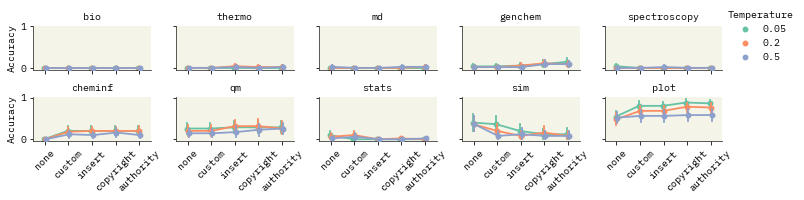

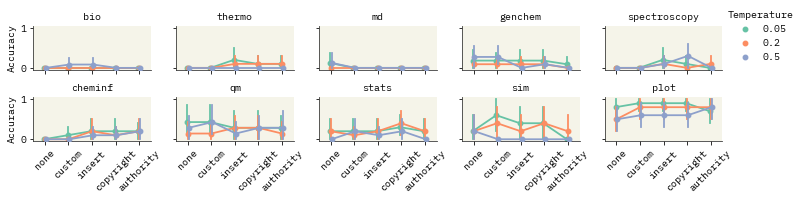

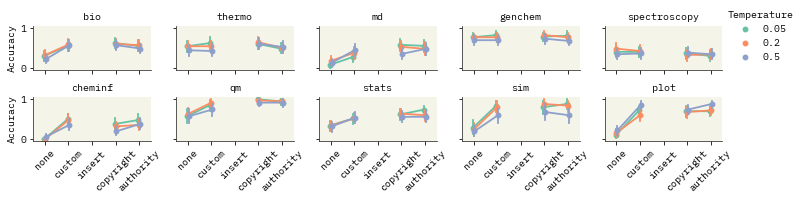

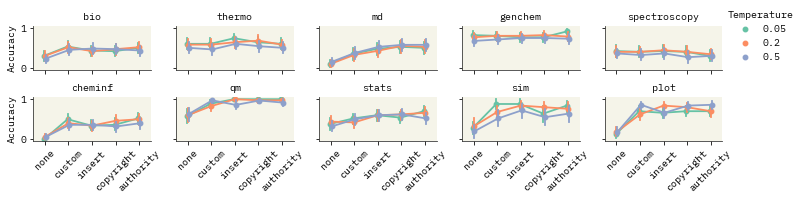

In [66]:
context_order = ['none', 'custom', 'insert', 'copyright', 'authority']

for mn in model_names:
    plt.figure(figsize=(3,3), dpi=90)
    g = sns.FacetGrid(merged[merged.model == mn], col='topic', col_wrap=5, height=1.4, aspect=1.5, hue_order=temperatures)
    g.map(sns.pointplot, 'used_context', 'result', 'temperature', 
          palette='Set2', dodge=True, hue_order=temperatures, order=context_order)
    g.add_legend(title='Temperature', loc='upper left', bbox_to_anchor=(0.87, 1))
    g.set_axis_labels('', 'Accuracy')
    g.map(lambda **kwargs: plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45))
    g.set_titles('{col_name}')
    g.savefig(f'{mn}-accuracy.pdf')
    g.savefig(f'{mn}-accuracy.png', dpi=300)

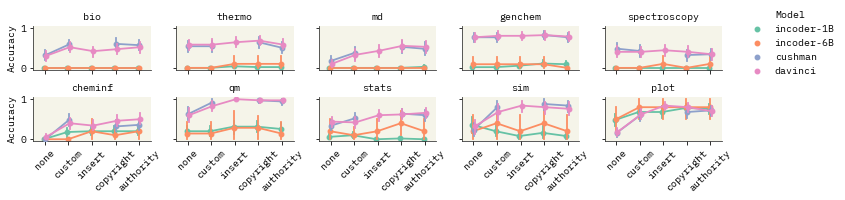

In [60]:
plt.figure(figsize=(3,3), dpi=90)
g = sns.FacetGrid(merged[merged.temperature == 0.2], col='topic', 
                  col_wrap=5, height=1.4, aspect=1.5, hue_order=model_names)
g.map(sns.pointplot, 'used_context', 'result', 'model', hue_order=model_names, order=context_order,
      palette='Set2', dodge=True)
g.add_legend(title='Model', loc='upper left', bbox_to_anchor=(0.87, 1))
g.set_axis_labels('', 'Accuracy')
g.map(lambda **kwargs: plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45))
g.set_titles('{col_name}')
g.savefig('model-comparison.pdf')
g.savefig('model-comparison.png', dpi=300)

In [10]:
print(df.groupby('topic').count().iloc[:,0].to_latex())

\begin{tabular}{lr}
\toprule
{} &  name \\
topic        &       \\
\midrule
bio          &    12 \\
cheminf      &    10 \\
genchem      &    11 \\
md           &     8 \\
plot         &    10 \\
qm           &     7 \\
sim          &     5 \\
spectroscopy &    10 \\
stats        &    10 \\
thermo       &    10 \\
\bottomrule
\end{tabular}



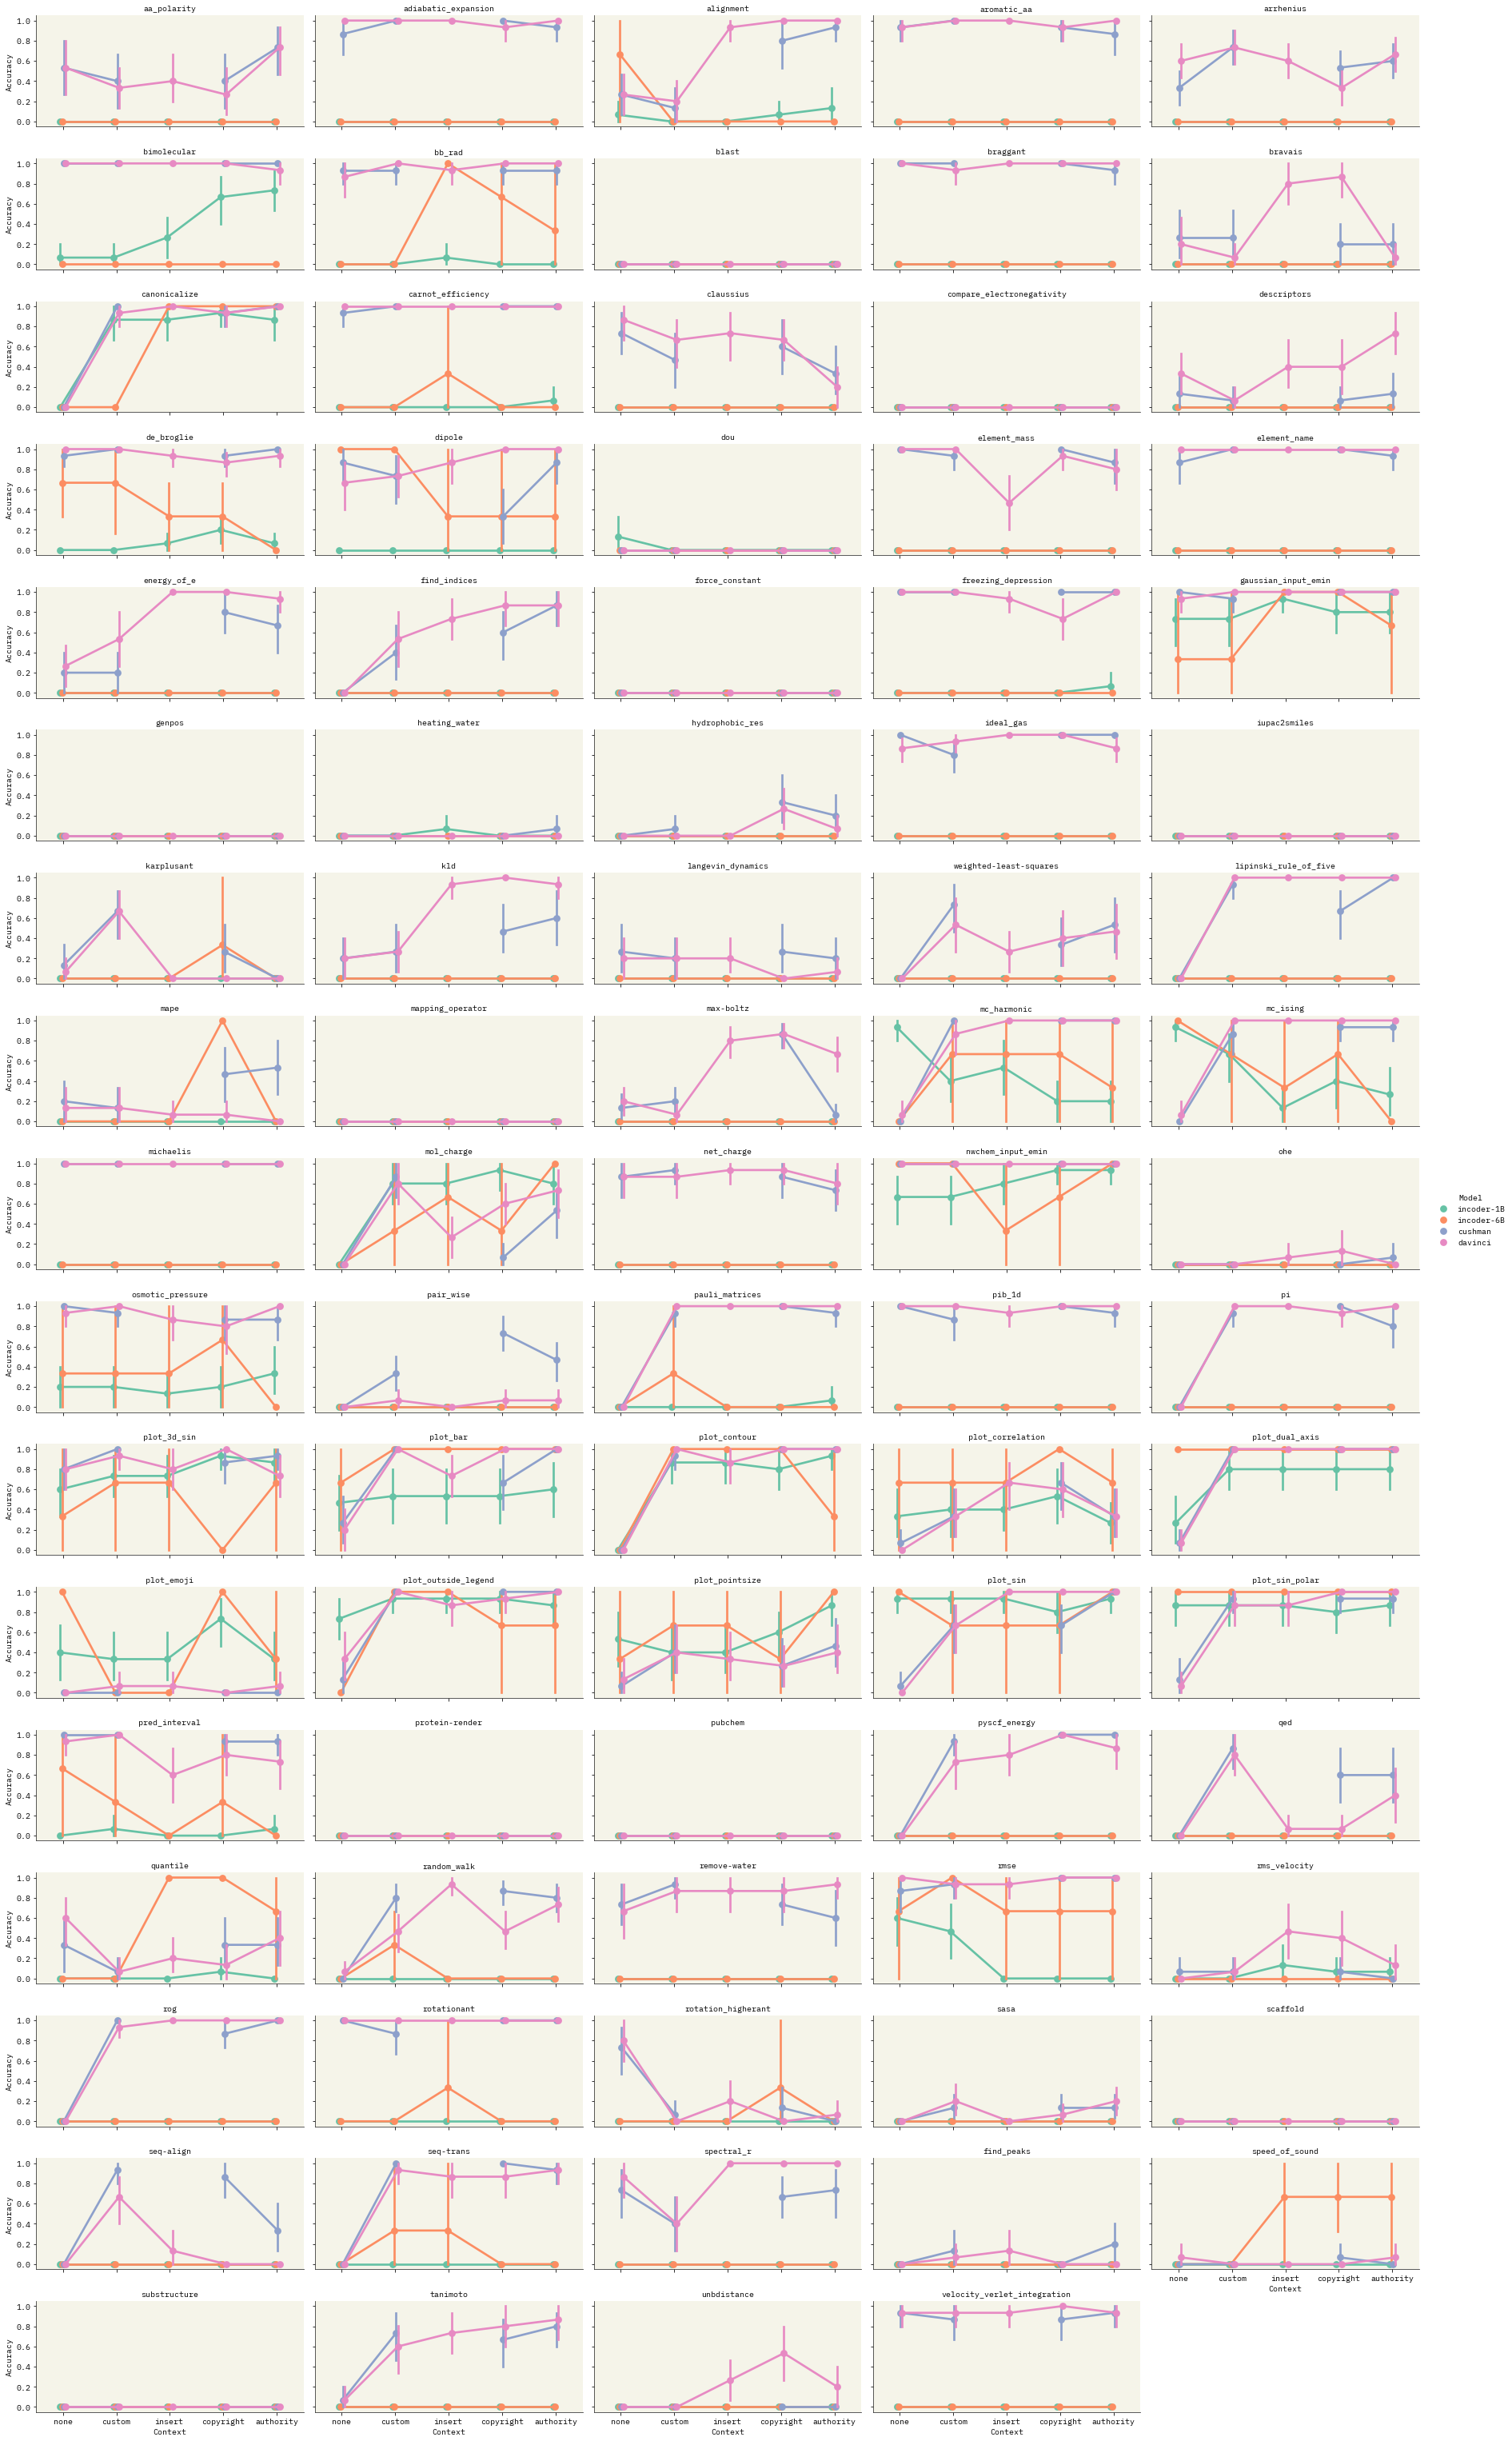

In [11]:
plt.figure(figsize=(4,4), dpi=90)
g = sns.FacetGrid(merged, col='name', col_wrap=5, height=2.5, aspect=2, hue_order=model_names)
g.map(sns.pointplot, 'used_context', 'result', 'model',  hue_order=model_names, order=context_order,
      palette='Set2', dodge=True)
g.add_legend(title='Model')
g.set_axis_labels('Context', 'Accuracy')
g.set_titles('{col_name}')
g.savefig('all.pdf')
g.savefig('all.png', dpi=300)

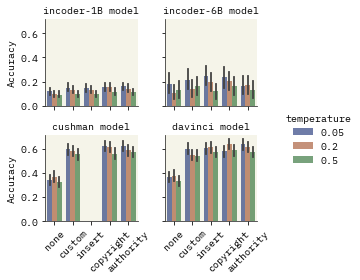

In [70]:
g = sns.catplot(
    data=merged, kind="bar", col="model",
    x="used_context", y="result", hue="temperature",
    palette="dark", alpha=.6, height=2, col_wrap=2, order=context_order
)
g.set_axis_labels('', 'Accuracy')
g.map(lambda **kwargs: plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45))
g.set_titles('{col_name} model')
g.savefig('context.pdf')
g.savefig('context.png', dpi=300)